# Kaggle - Santander Product Recommendation EDA
**Author: Chris Shin**

## Business Understanding
Santander Bank is looking to create new recommendation system to support range of financial decision toward customers. Based on the customers' information on bank usage such as credit card, mortagage insurance, saving account, etc, Santander Bank wants to create a recommendation system to suggest new financial products that will fit the customers' needs. With the new recommendation system, it wishs to accomplish better prediction and actually suggest most matching products to the existing customers. In this research, the analysis and predictive model are provided to identify lists of top 7 financial products to the existing customers based on their previous purchases or usages on the Santander Bank. The client specifically wants the Mean Average Precision evalution metrics to measure the performance of the model. 

### Note: Average Precision
Average Precision is calculated as the weighted mean of precisions at each threshold; the weight is the increase in recall from the prior threshold

For example, let's say we have 7 predictions as below\
&nbsp;&nbsp;&nbsp;&nbsp; 1 0 0 1 1 1 0

It's prediction accuracy is now.\
&nbsp;&nbsp;&nbsp;&nbsp; 1/1 0 0 2/4 3/5 4/6 0

For average precision, it calculates accuracies of corrected ones. Thus it is calculating the average of 4 instead of 7.\
&nbsp;&nbsp;&nbsp;&nbsp; (1/1 + 2/4 + 3/5 + 4/6) / 4 = 0.69

Mean Average Precision (mAP) is commonly used to analyze the performance of object detection and segmentation systems. The mean of average precision(AP) values are calculated over recall values from 0 to 1. MAP is mean value of all predicted results' average precision. MAP@7 meant that it can make prediction of 7 predictions. MAP@7 is sensitive to the order of predictions. More corrected prediciton listed in the front, it will get higher MAP@7

For example, let's say we get below prediction\
&nbsp;&nbsp;&nbsp;&nbsp; 1 1 1 1 0 0 0

It's accuracy is now\
&nbsp;&nbsp;&nbsp;&nbsp; 1/1 2/2 3/3 4/4 0 0 0

It's Average Precision is\
&nbsp;&nbsp;&nbsp;&nbsp; (1/1 + 2/2 + 3/3 + 4/4) / 4 = 1

But if the correctly predictions is made for last items.\
&nbsp;&nbsp;&nbsp;&nbsp; 0 0 0 1 1 1 1

It's accuracy is \
&nbsp;&nbsp;&nbsp;&nbsp; 0 0 0 1/4 2/5 3/6 4/7

Then it's average precision becomes\
&nbsp;&nbsp;&nbsp;&nbsp; (1/4 + 2/5 + 3/6 + 4/7) / 4 = 0.43




In [2]:
import numpy as numpy

# average precision
def apk(actual, predicted, k=7, default=0.0):
    # Since it is MAP@7, we use max 7 items to calculate
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # Rules to give a score:
        # Predicted is in the actual (p in actual)
        # predicted is not a duplicate (p no in predicted[:i])
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # if actual is empty, it return 0
    if not actual:
        return default

    # use number of actual to calculkate the average precision
    return score / min(len(actual) , k)

# mean average precision
def mapk(actual, predicted, k=7, default=0.0):
    # actual and predicted are list of list. 
    # for each customer, get the average precision and get mean using np.mean()
    return np.mean([apk(a, p, k, default) for a,p in zip(actual, predicted)])

## Data Engineering

Santander Product Recommendation data is time series data. It tells "At A time, customer B purchased C prodocuts". It contains various information about customer B such as age, jobs, address, etc. It also contains information on product such as price or types. Thus it has abundant and enormous data. However, having large quantity of data does not always mean good. It is more important to contain high quality data to make better prediction.

### Data Processing

Data processing is essential and crucial process as there might be data noise such as NAN data, outlieers, or incorrect data by human error during data collection. 

### Feature Engineering

In order to get a best result out of the machine learning model, it is necessary to do the feature engineering. For time series data, data containing weather or time information can be engineered into create weekend/weekday, existence of holidays, seasonality, school days/vacations, etc kinds of data.

In time series data, lag data that utilizes past data can be created as a derived variable. Data on products purchased by customer B a month ago, two months ago, or three months ago are used to predict which products will be purchased this month. Not all derived variables are significant to the model. The discriminating variable varies from model to model and problem to problem, so it's good to try all the possibilities.

In [3]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

trn = pd.read_csv('./data/train_ver2.csv')

C:\Users\Yuchie\AppData\Local\Temp\ipykernel_8464\2928522865.py:5: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  trn = pd.read_csv('./data/train_ver2.csv')


In [4]:
trn.shape

(13647309, 48)

In [5]:
trn.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [6]:
trn.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [7]:
trn.describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.364731e+07,1.363125e+07,1.363125e+07,1.364731e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05,1.022912e-04,2.315475e-05,6.554837e-01,3.939238e-04,8.086722e-02,9.474175e-03,9.726606e-03,1.290083e-01,4.330583e-02,1.778739e-03,1.660987e-03,4.296679e-02,8.274357e-02,1.848599e-02,5.886582e-03,9.170965e-03,2.627404e-03,5.253636e-02,4.438868e-02,2.560761e-02,3.847718e-03,5.472434e-02,5.942854e-02,1.279162e-01
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05,1.011340e-02,4.811883e-03,4.752103e-01,1.984361e-02,2.726311e-01,9.687320e-02,9.814275e-02,3.352091e-01,2.035447e-01,4.213757e-02,4.072135e-02,2.027823e-01,2.754942e-01,1.347006e-01,7.649791e-02,9.532502e-02,5.119083e-02,2.231060e-01,2.059571e-01,1.579616e-01,6.191053e-02,2.274414e-01,2.364250e-01,3.339965e-01
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
trn.std()

C:\Users\Yuchie\AppData\Local\Temp\ipykernel_8464\1704573257.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  trn.std()


ncodpers                 431565.025784
ind_nuevo                     0.236673
indrel                        4.177469
tipodom                       0.000000
cod_prov                     12.784017
ind_actividad_cliente         0.498217
renta                    230620.238822
ind_ahor_fin_ult1             0.010113
ind_aval_fin_ult1             0.004812
ind_cco_fin_ult1              0.475210
ind_cder_fin_ult1             0.019844
ind_cno_fin_ult1              0.272631
ind_ctju_fin_ult1             0.096873
ind_ctma_fin_ult1             0.098143
ind_ctop_fin_ult1             0.335209
ind_ctpp_fin_ult1             0.203545
ind_deco_fin_ult1             0.042138
ind_deme_fin_ult1             0.040721
ind_dela_fin_ult1             0.202782
ind_ecue_fin_ult1             0.275494
ind_fond_fin_ult1             0.134701
ind_hip_fin_ult1              0.076498
ind_plan_fin_ult1             0.095325
ind_pres_fin_ult1             0.051191
ind_reca_fin_ult1             0.223106
ind_tjcr_fin_ult1        

In [9]:
trn.isna().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

There are 13,647,309 rows of customer data and 48 features.

Out of 48 features, feature 1~24 is customer related and feature 25~48 is product related

#### Customer Features

##### Numerical Features

In [10]:
num_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['int64', 'float64']]
trn[num_cols].describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


Out of 24 customer features, 7 of them are numerics. Below is the noticable notes.

- ncodpers: There are unique values from min 15889 to 1553689
- ind_neuvo: 75% of data is 0 and last of it is 1
- indrel: 75 of data is 1 and last of them has up to 99.
- tipodom: All values is 1. This meant this feature do not provide meaningful information for prediction
- cod_prov: There are value from 1 to 52. It is numerical value but it can be also good to be considered as categorical variable
- ind_actividad_cliente: 50% of data is 0 and last of them is 1
- renta: There are value from 1202.73 to 28894400. Typical numerical feature.


In [ ]:
#################
#add eda on Missing values
#################

##### Categorical Feature

In [10]:
cat_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['O']]
trn[cat_cols].describe()

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


Features like age supposed to be numeric but it is currently used as object. It requires transformation.

In [11]:
for col in cat_cols:
    uniq = np.unique(trn[col].astype(str))
    print('-' * 50)
    print(f'# col {col}, n_uniq {len(uniq)}, uniq {uniq}')

--------------------------------------------------
# col fecha_dato, n_uniq 17, uniq ['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
--------------------------------------------------
# col ind_empleado, n_uniq 6, uniq ['A' 'B' 'F' 'N' 'S' 'nan']
--------------------------------------------------
# col pais_residencia, n_uniq 119, uniq ['AD' 'AE' 'AL' 'AO' 'AR' 'AT' 'AU' 'BA' 'BE' 'BG' 'BM' 'BO' 'BR' 'BY'
 'BZ' 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CZ'
 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EC' 'EE' 'EG' 'ES' 'ET' 'FI' 'FR' 'GA' 'GB'
 'GE' 'GH' 'GI' 'GM' 'GN' 'GQ' 'GR' 'GT' 'GW' 'HK' 'HN' 'HR' 'HU' 'IE'
 'IL' 'IN' 'IS' 'IT' 'JM' 'JP' 'KE' 'KH' 'KR' 'KW' 'KZ' 'LB' 'LT' 'LU'
 'LV' 'LY' 'MA' 'MD' 'MK' 'ML' 'MM' 'MR' 'MT' 'MX' 'MZ' 'NG' 'NI' 'NL'
 'NO' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PL' 'PR' 'PT' 'PY' 'Q

# Customer Features Table
| Feature | Description | Data Type | Characteristics | Notes |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| fecha_dato | Date data fetched | object | 2015 1~6 has less data than other dates | Extract Month and Year from the feature |
| ncodpers   | Unique Customer code | int64 | its a numerica variables but its a unique identification code | unique identification code cannot be used in model training |
| ind_empleado   | Employee index: A active, B ex employed, F filial, N not employee, P pasive | object | majority of data is 'N', so its feature importance may be low | |
| pais_residencia   | Customer's Country residence | Object | It is two letter alphabet for unique country code. It is hard to track which country it is. ES has high density (ES = Spain) | |
| sexo   | Customer's sex | object | There are more V which is Female | |
| age   | age | object -> int64 | | need to change to integer |
| fecha_alta   | The date in which the customer became as the first - holder of a contract in the bank | object | Data from 1995 to 2016. It has wide range. | |
| ind_nuevo   | New customer Index. 1 if the customer registered in - the last 6 months | float64 -> int64 | mostly 0 more than 75%. | Convert to Integer |
| antiguedad   | Customer seniority (in months) | object -> int64 | | Convert to int  |
| indrel   | 1 (First/Primary), 99 (Primary customer during the - month but not at the end of the month) | object -> int64 | Most of data is 0 | Convert to Integer |
| ult_fec_cli_1t   | Last date as primary customer (if he isn't at the end of the month) | object | Data from 2015/07 to 2016/05 | |
| indrel_1mes   | Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner) | object->int64 | There are two different 1.0 and 1 | Convert to Integer. There are P, and it may have to changed to 5 |
| tiprel_1mes   | Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential) | object | High Density on A and I | |
| indresi   | Residence index (S (Yes) or N (No) if the residence country is the same than the bank country) | object | High Density on S | |
| indext   | Foreigner index (S (Yes) or N (No) if the customer's = birth country is different than the bank country) | object | High Density on N | |
| conyuemp   | Spouse index. 1 if the customer is spouse of an employee | object | High Density on N | |
| canal_entrada   | channel used by the customer to join | object | 3 letter alphabet code. High Density on top 5 items | |
| indfall   | Deceased index. N/S | object | High Density on N. If customer is dead, new customer purchase would not be possible | |
| tipodom   | Addres type. 1, primary address | float64 | All values are 1 | Remove the feature |
| cod_prov   | Province code (customer's address) | float64->int64 | value from 1~52, top 5 has high density | No need to be decimals, Convert to Integer |
| nomprov   | Province name | object | It show similar plot with cod_prov. It may be considered as same data with cod_prov. | |
| ind_actividad_cliente   | Activity index (1, active customer; 0, inactive customer) | float64->int64 | | Convert to Integer |
| renta   | Gross income of the household | float64->int64 | 10^3 to 2*10^7 of wide range data. No information of the units | Convert to Integer |
| segmento   | segmentation: 01 - VIP, 02 - Individuals 03 - college graduated | object | Highest to lowest density is individual, college graduated, and VIP. | |


In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

--------------------------------------------------
col :  fecha_dato


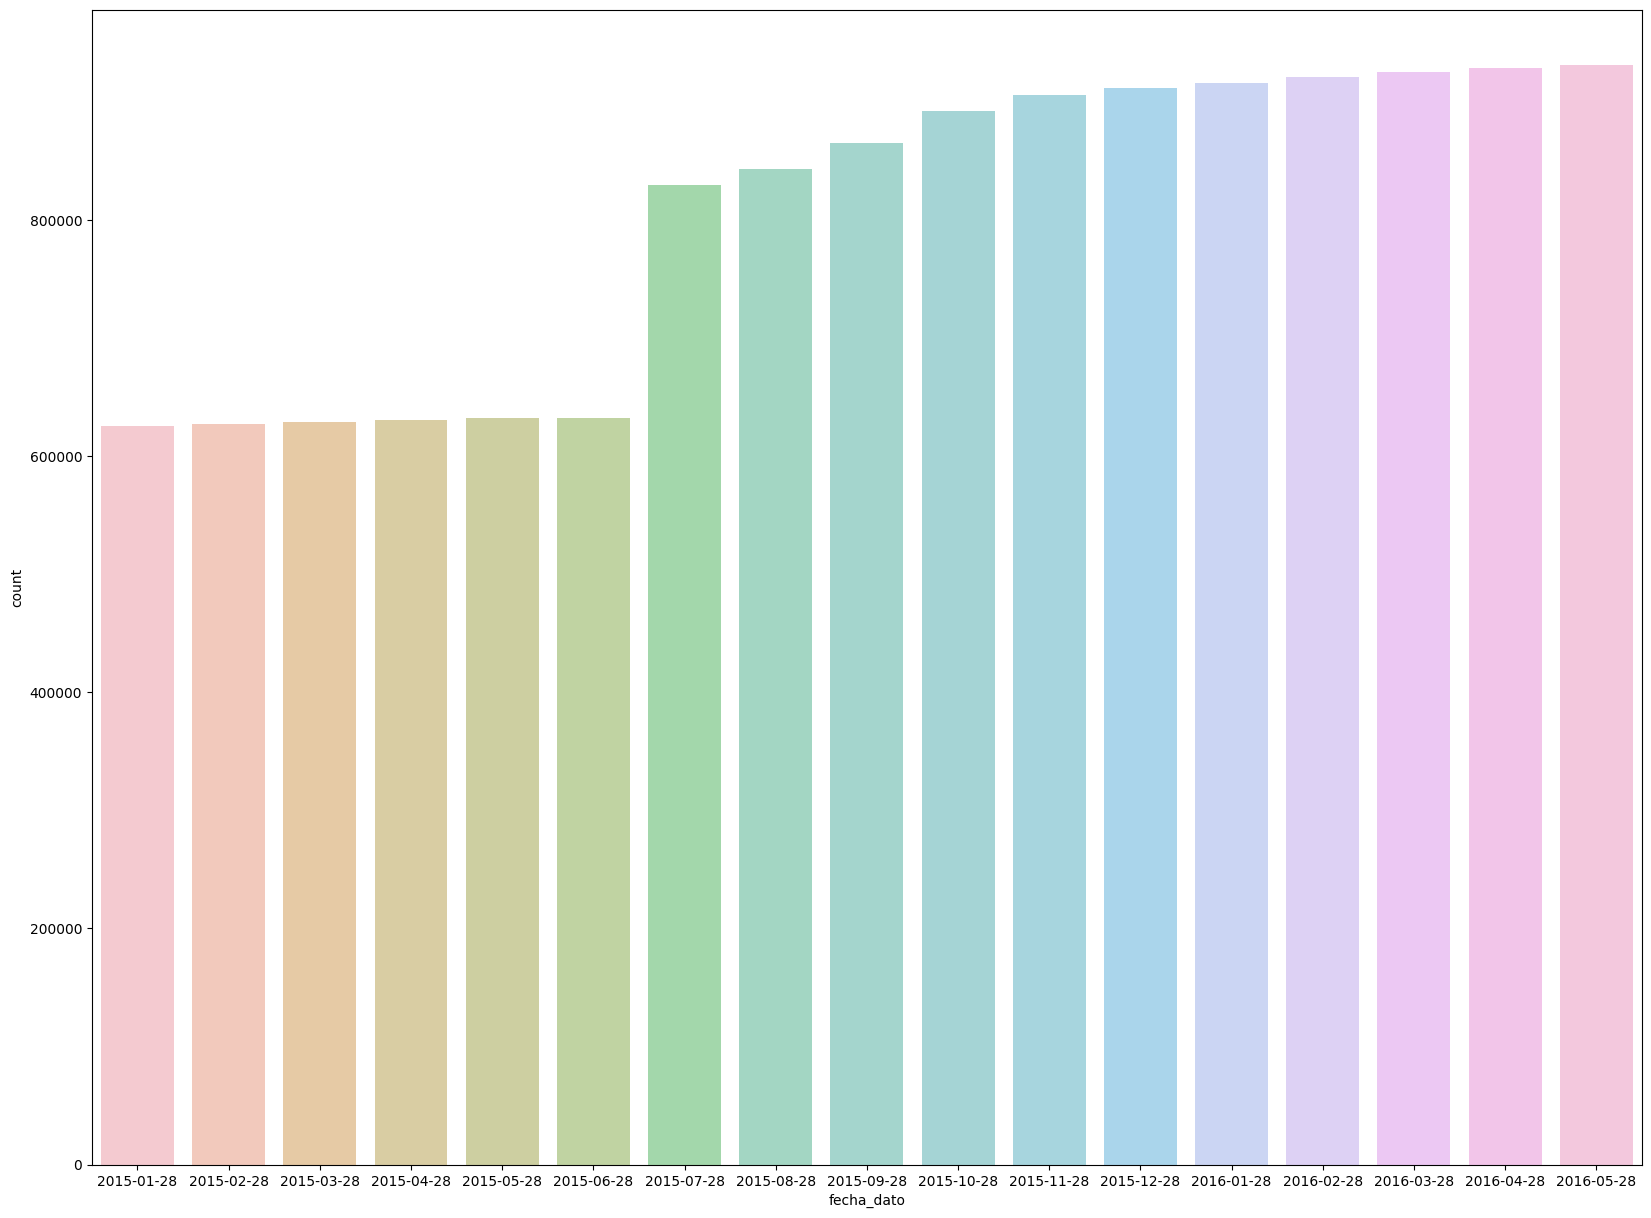

--------------------------------------------------
col :  ind_empleado


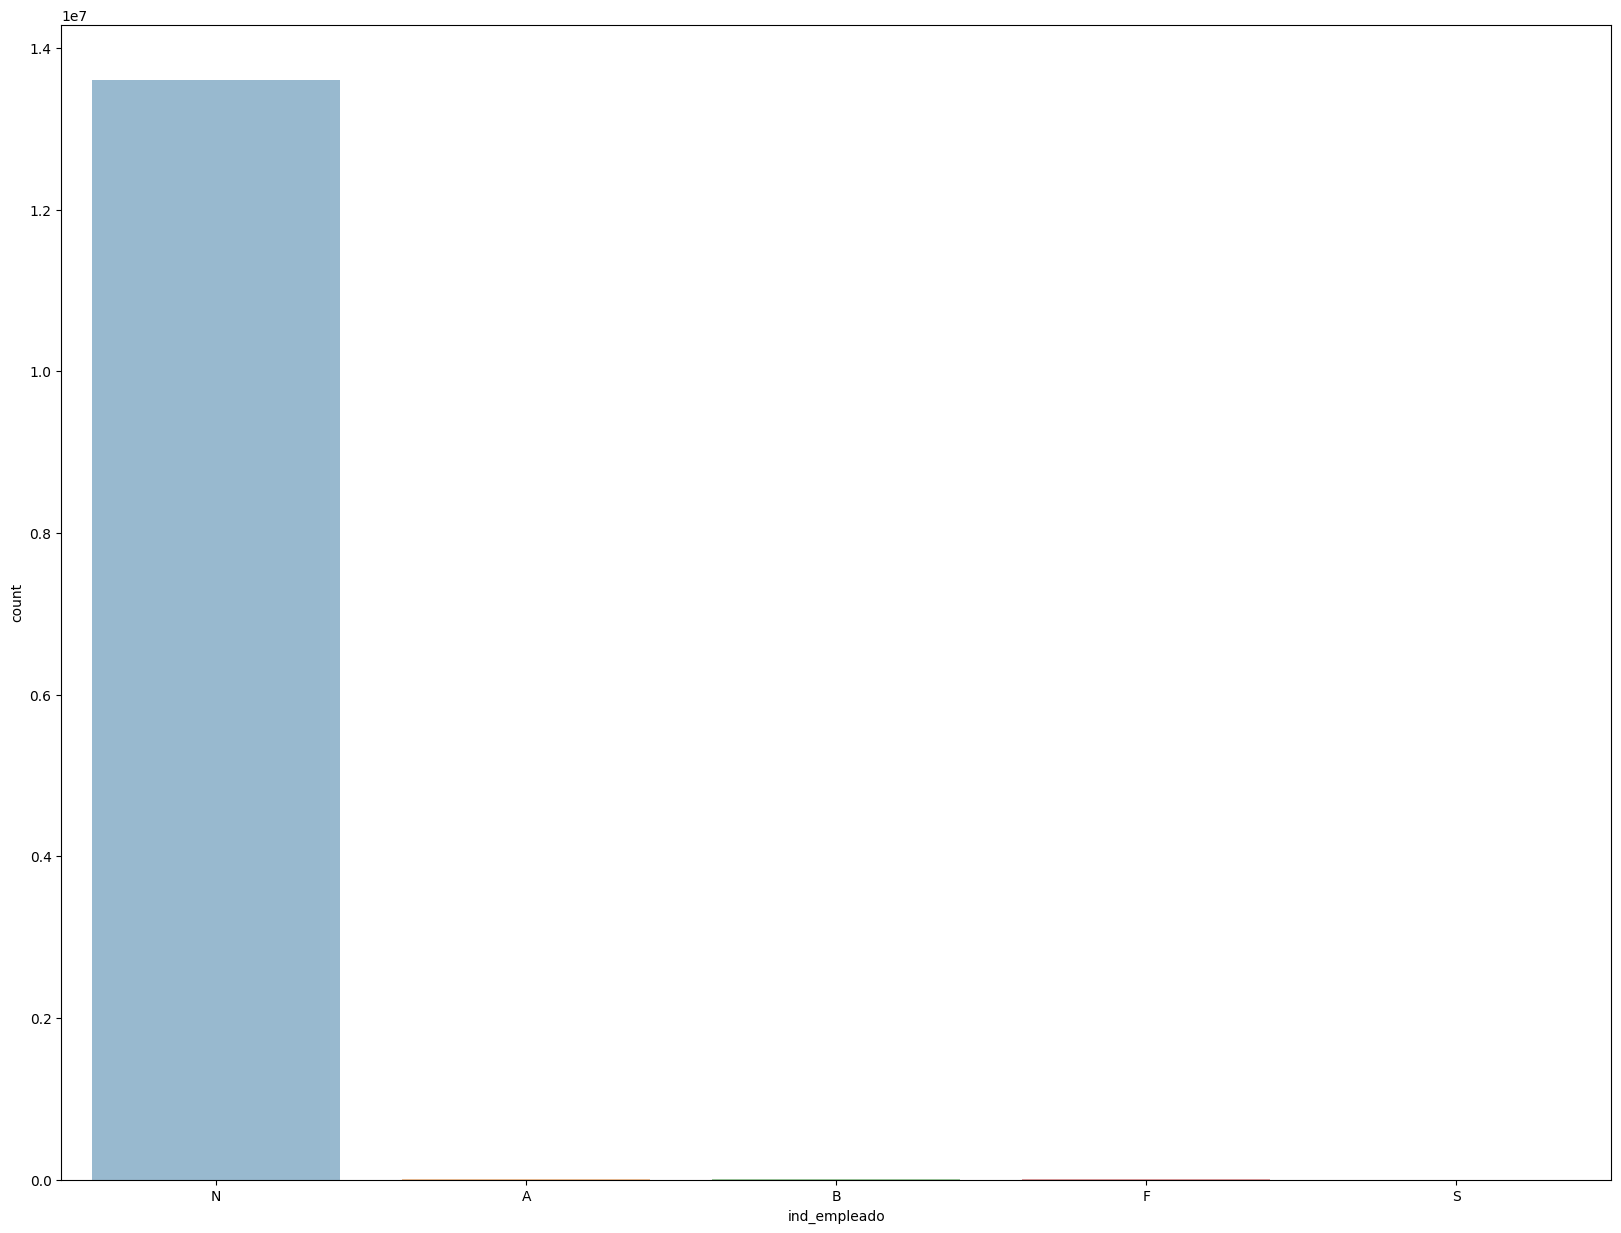

--------------------------------------------------
col :  pais_residencia


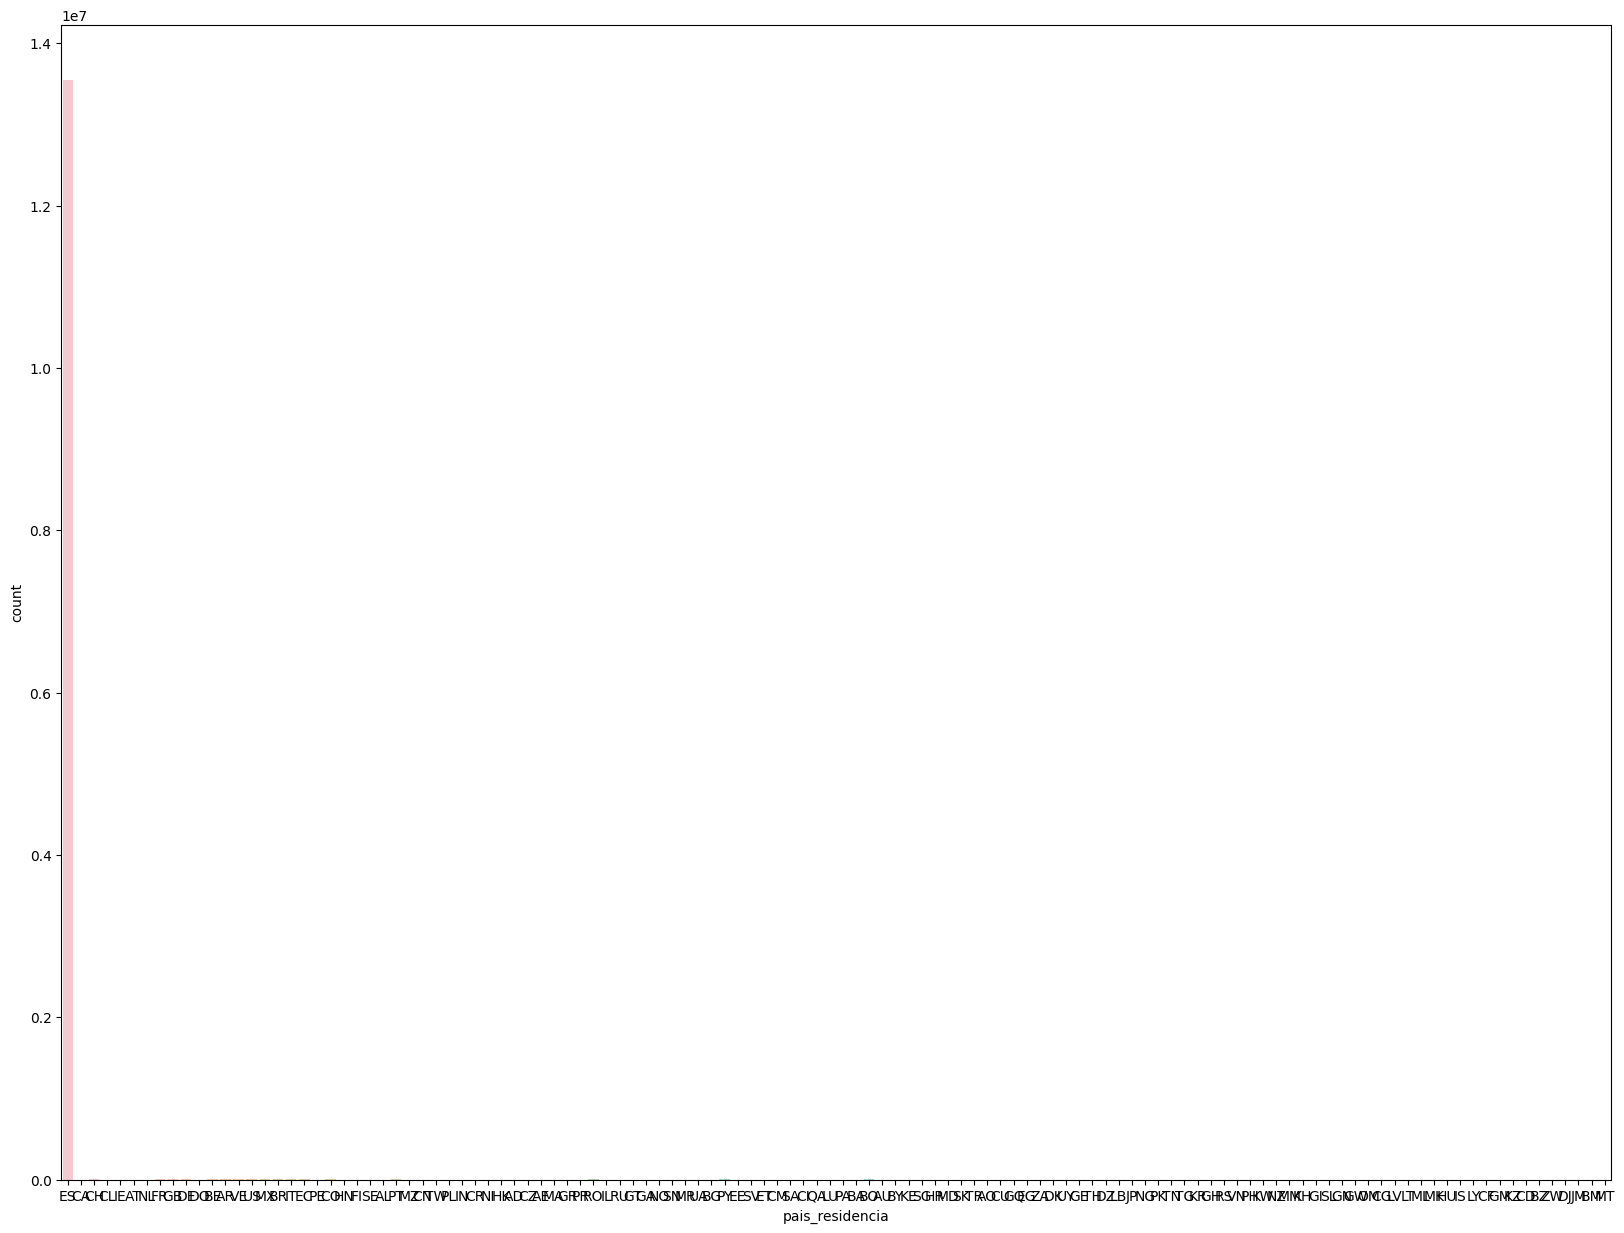

--------------------------------------------------
col :  sexo


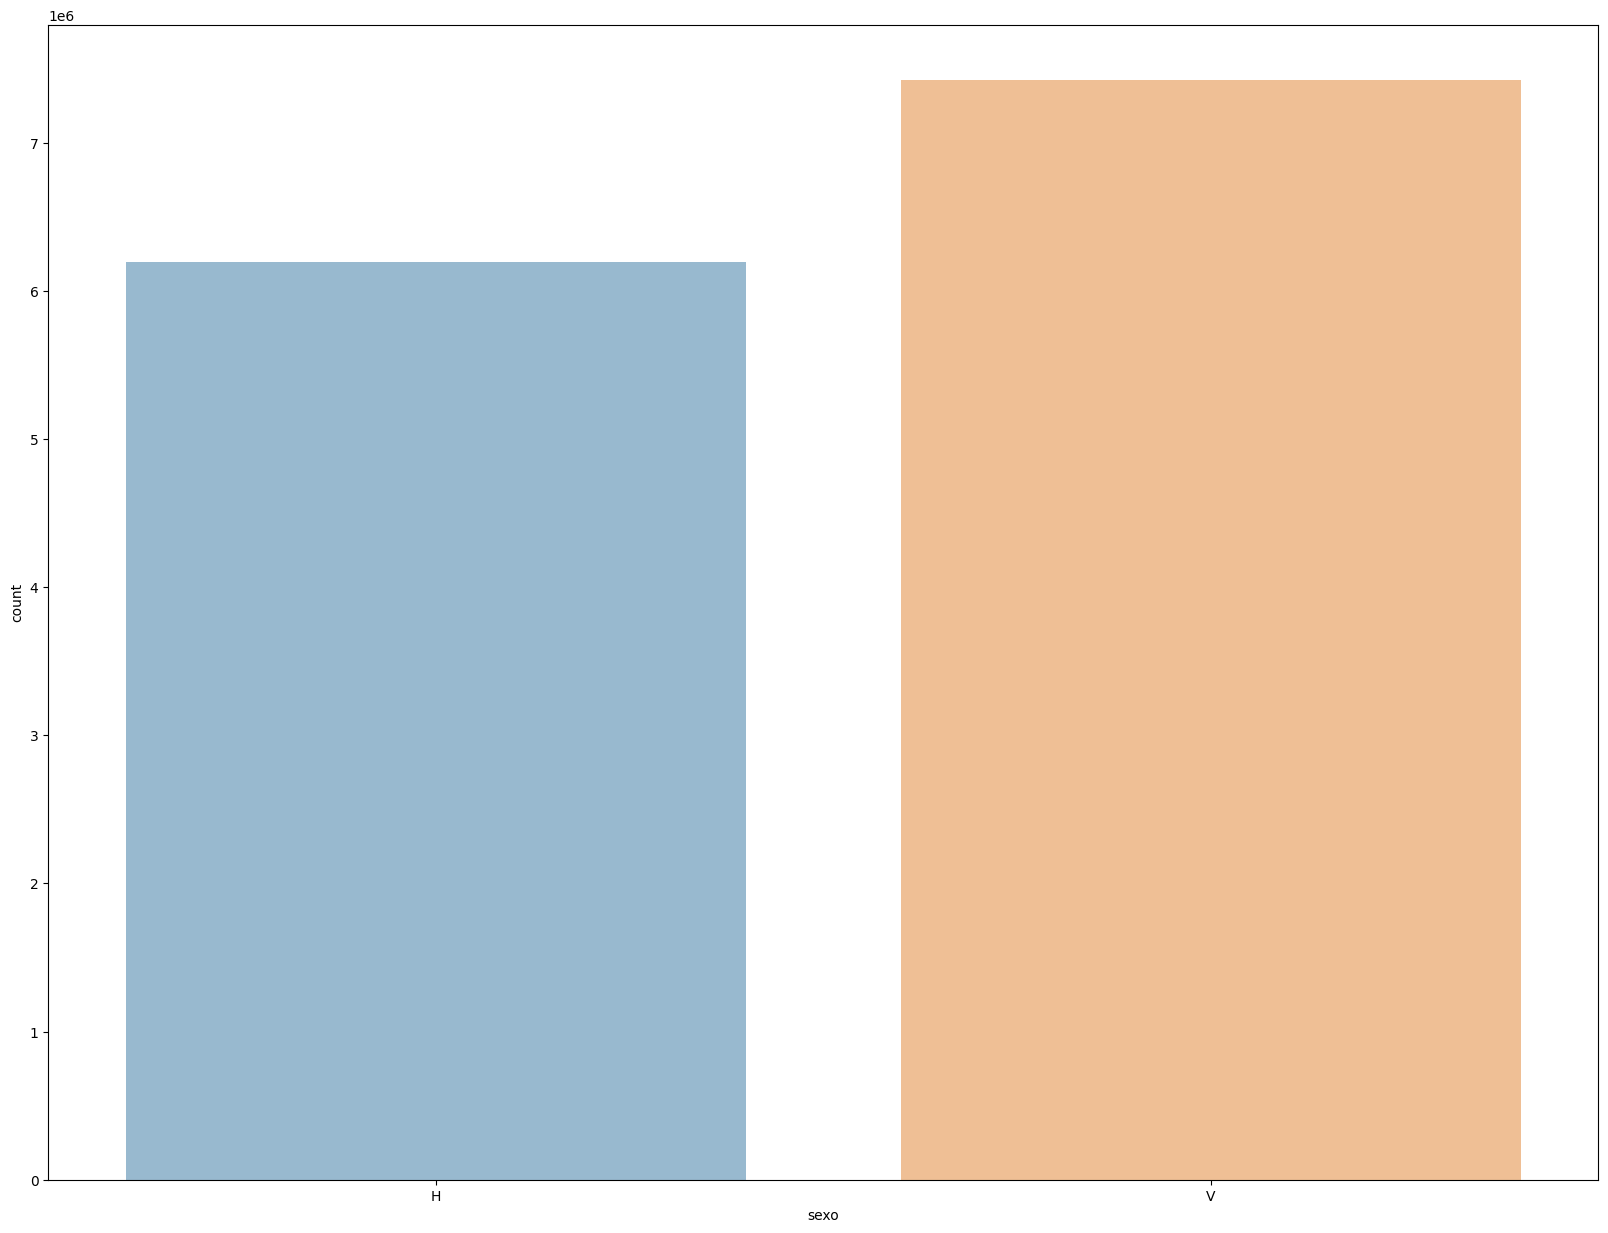

--------------------------------------------------
col :  age


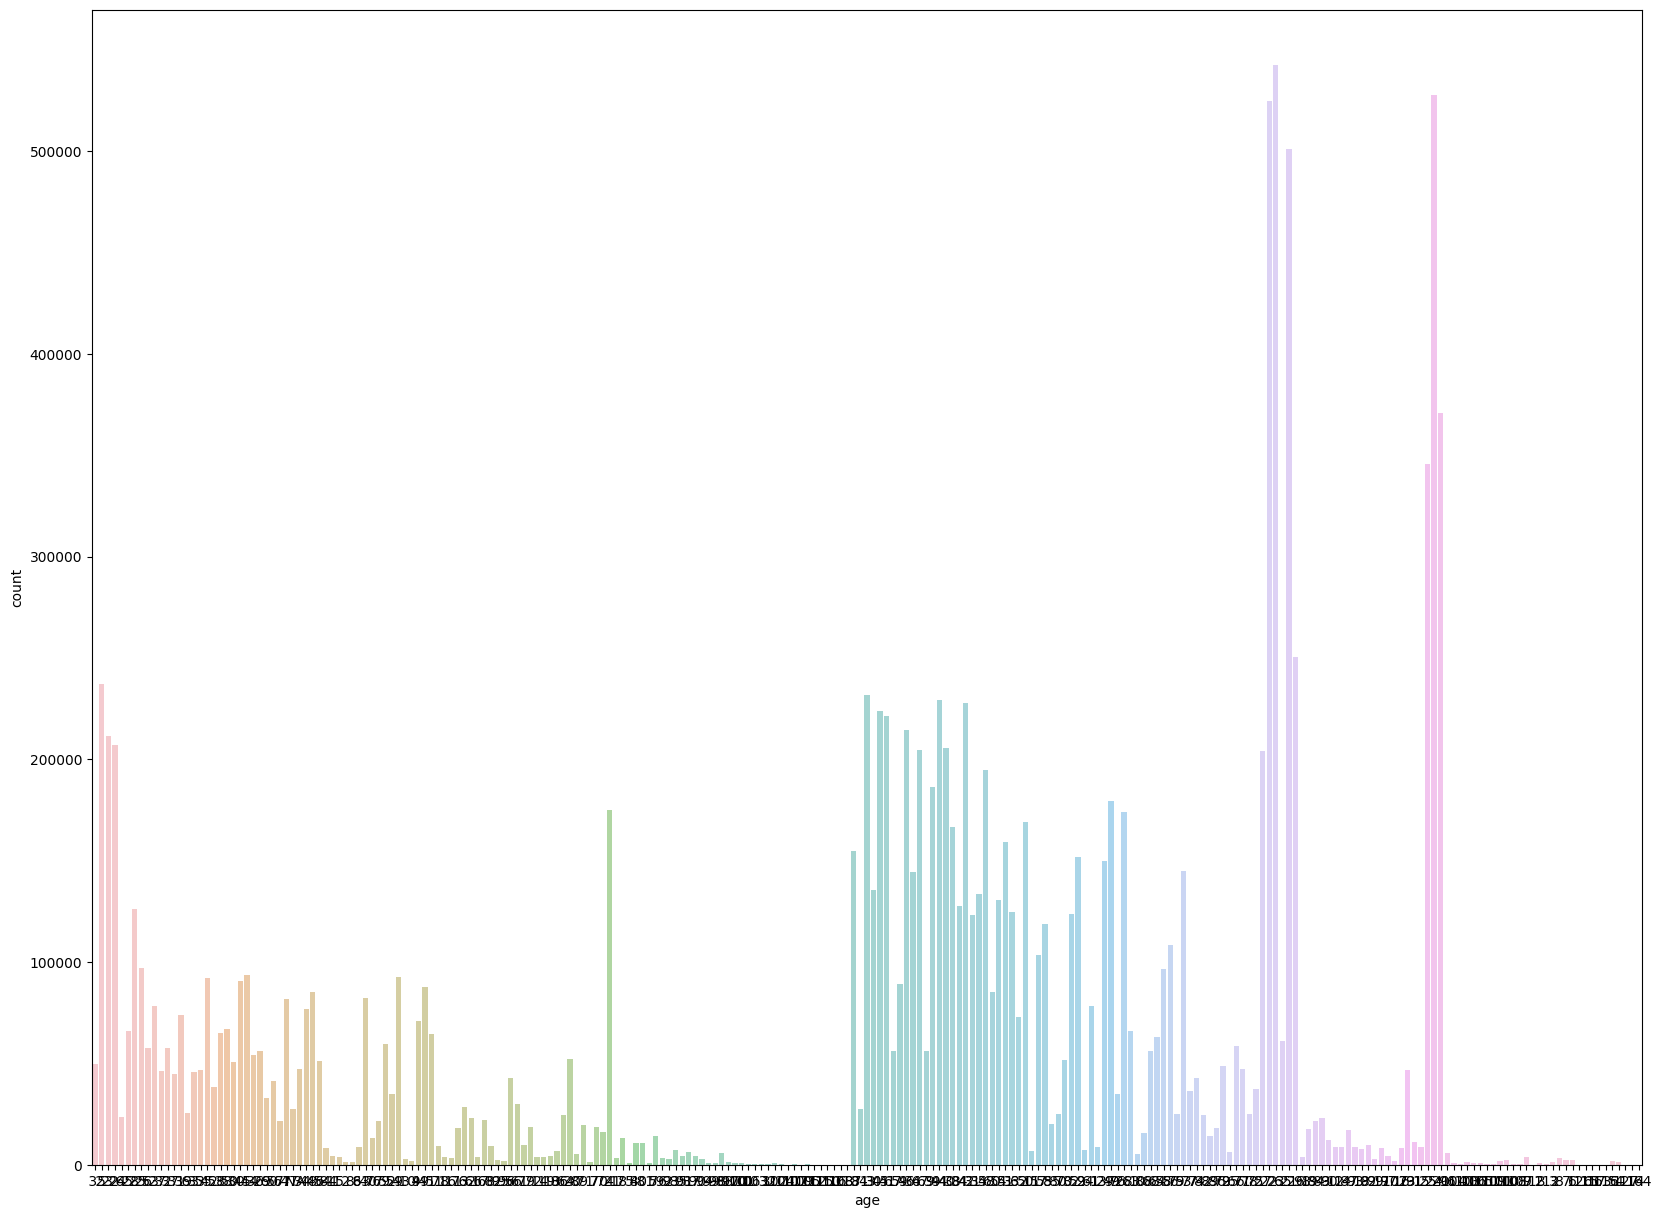

--------------------------------------------------
col :  fecha_alta


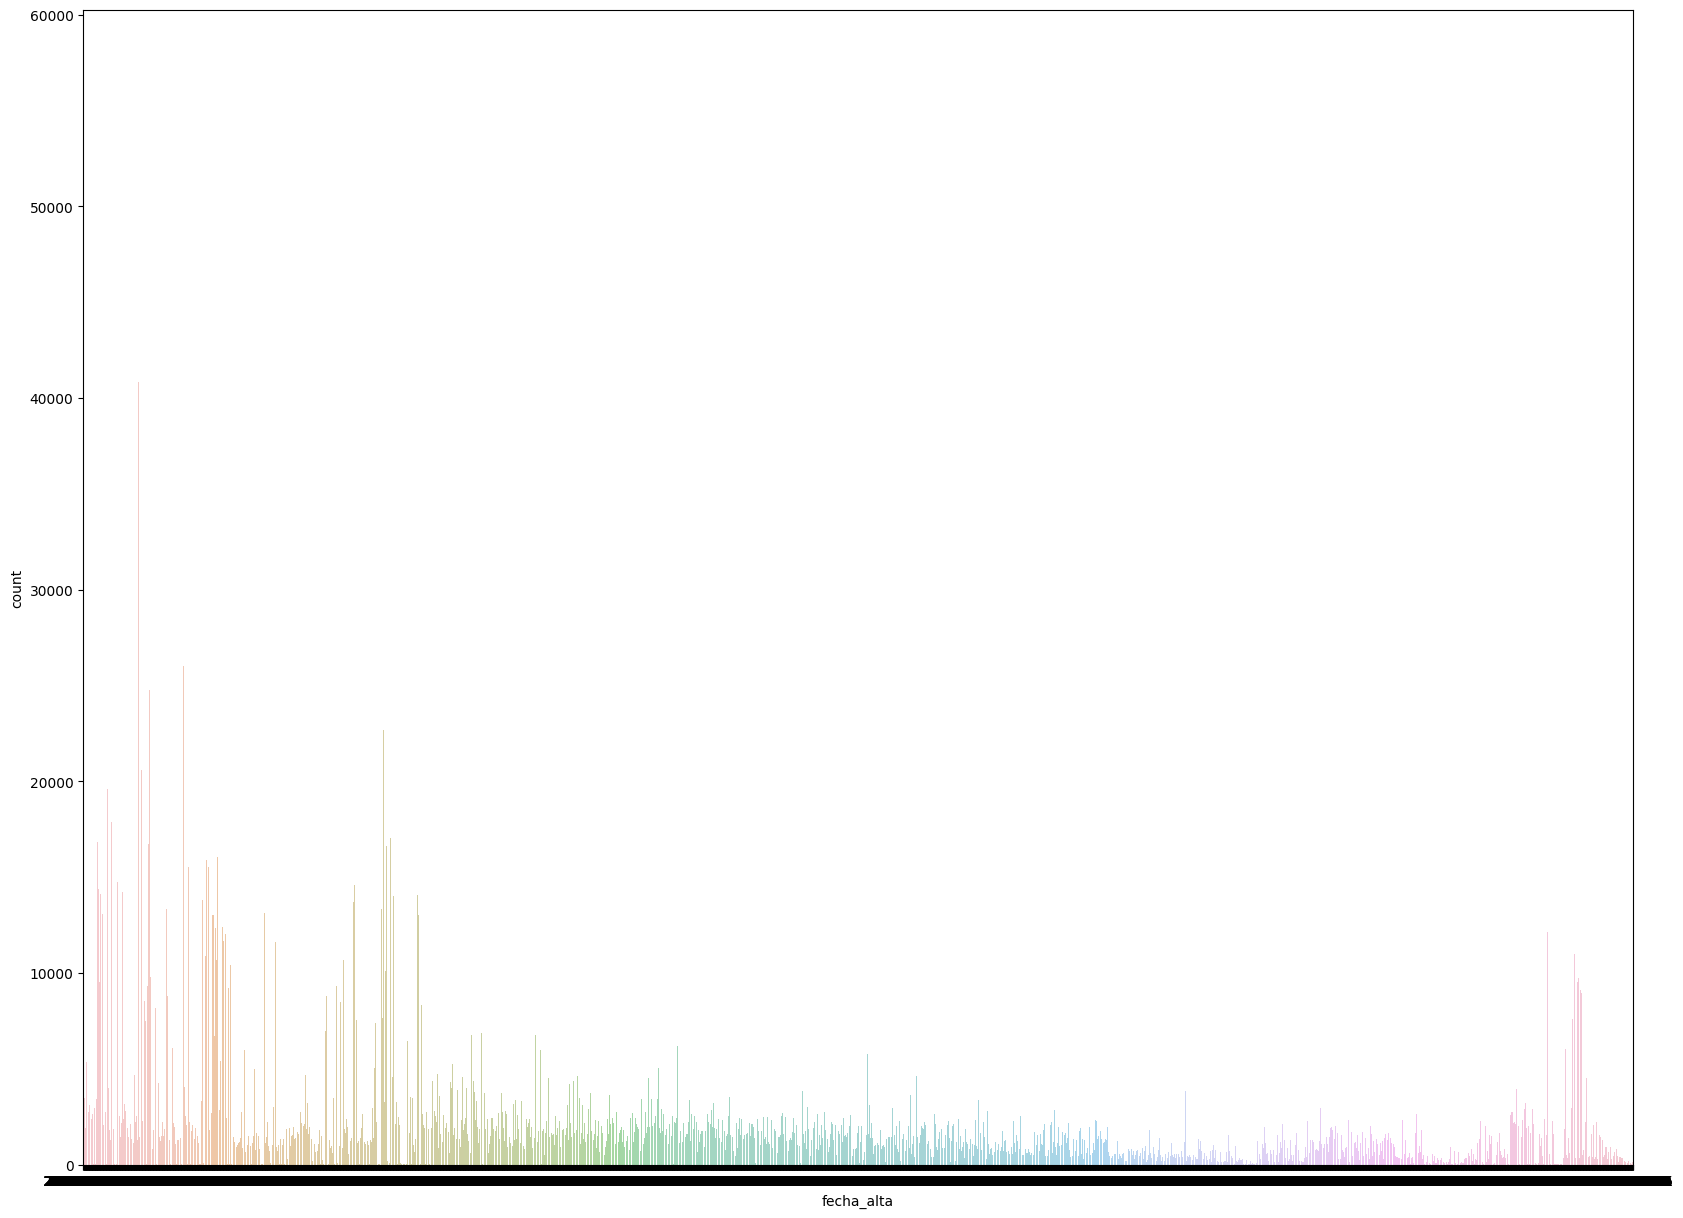

--------------------------------------------------
col :  ind_nuevo


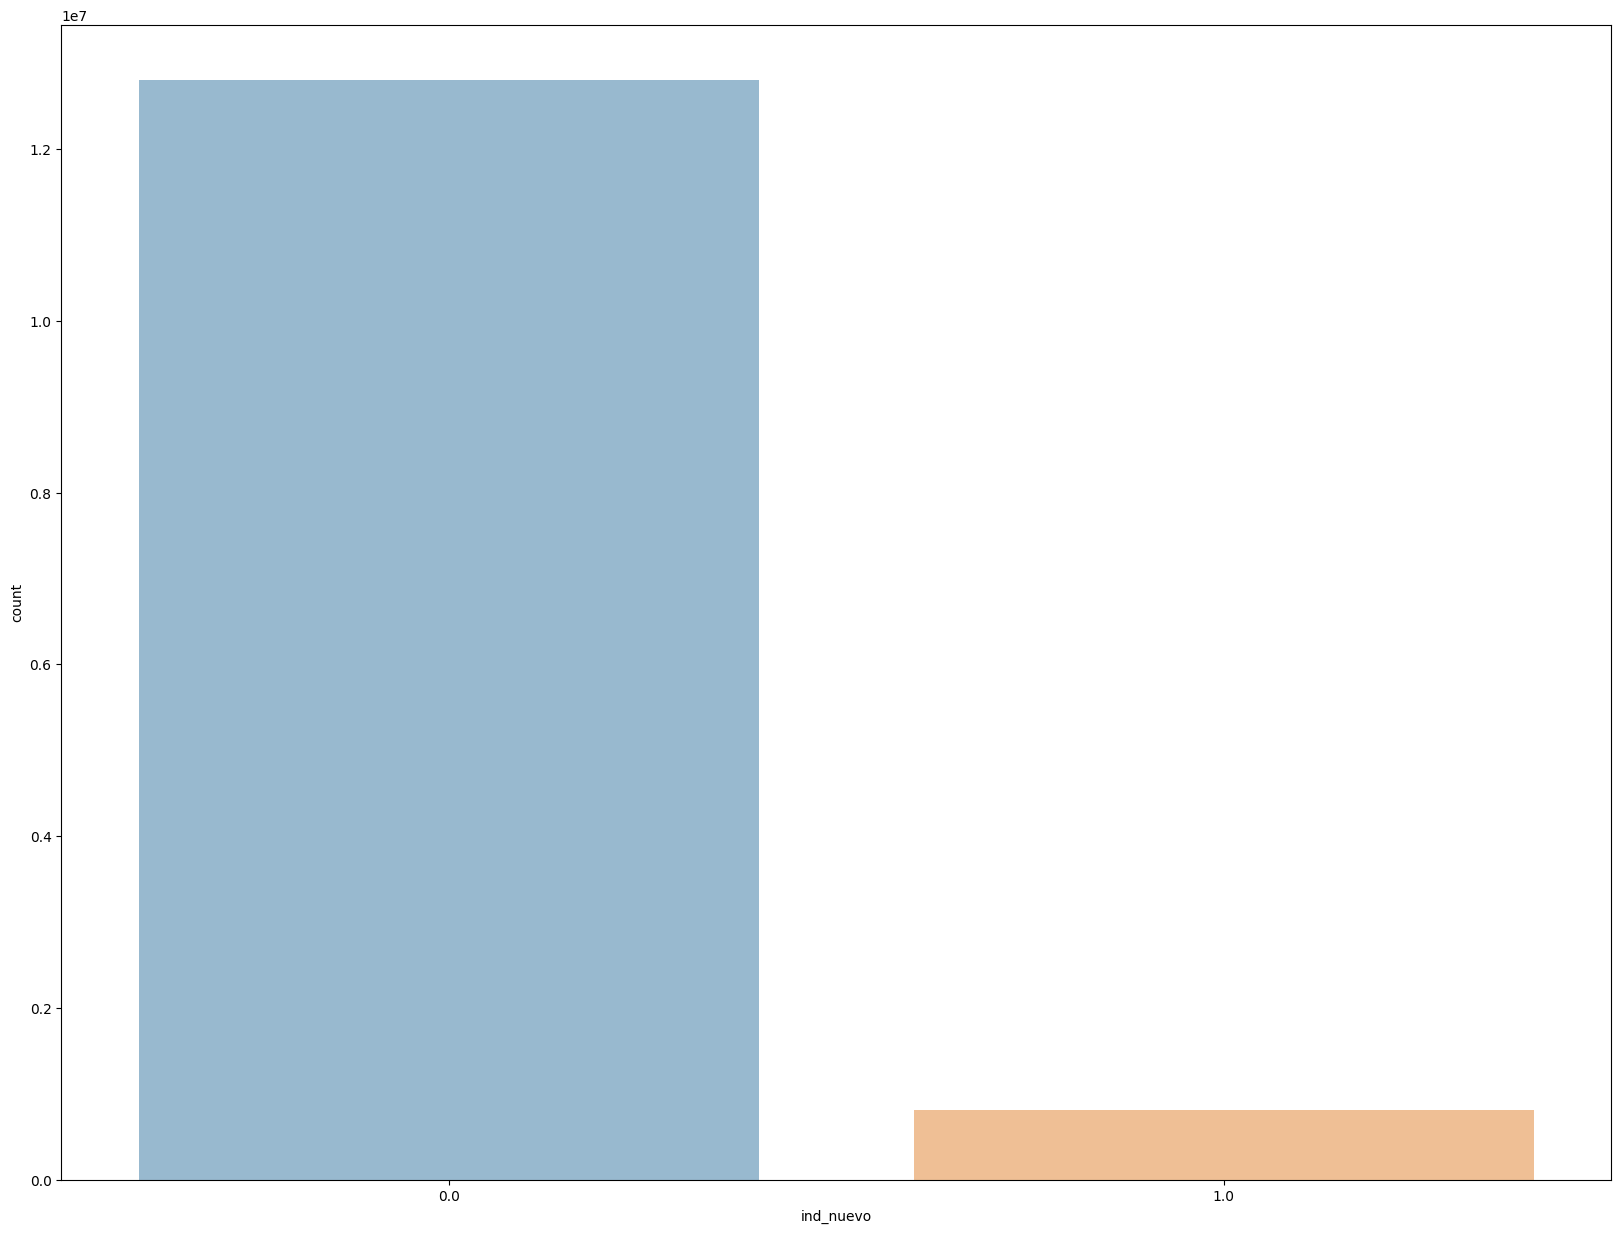

--------------------------------------------------
col :  antiguedad


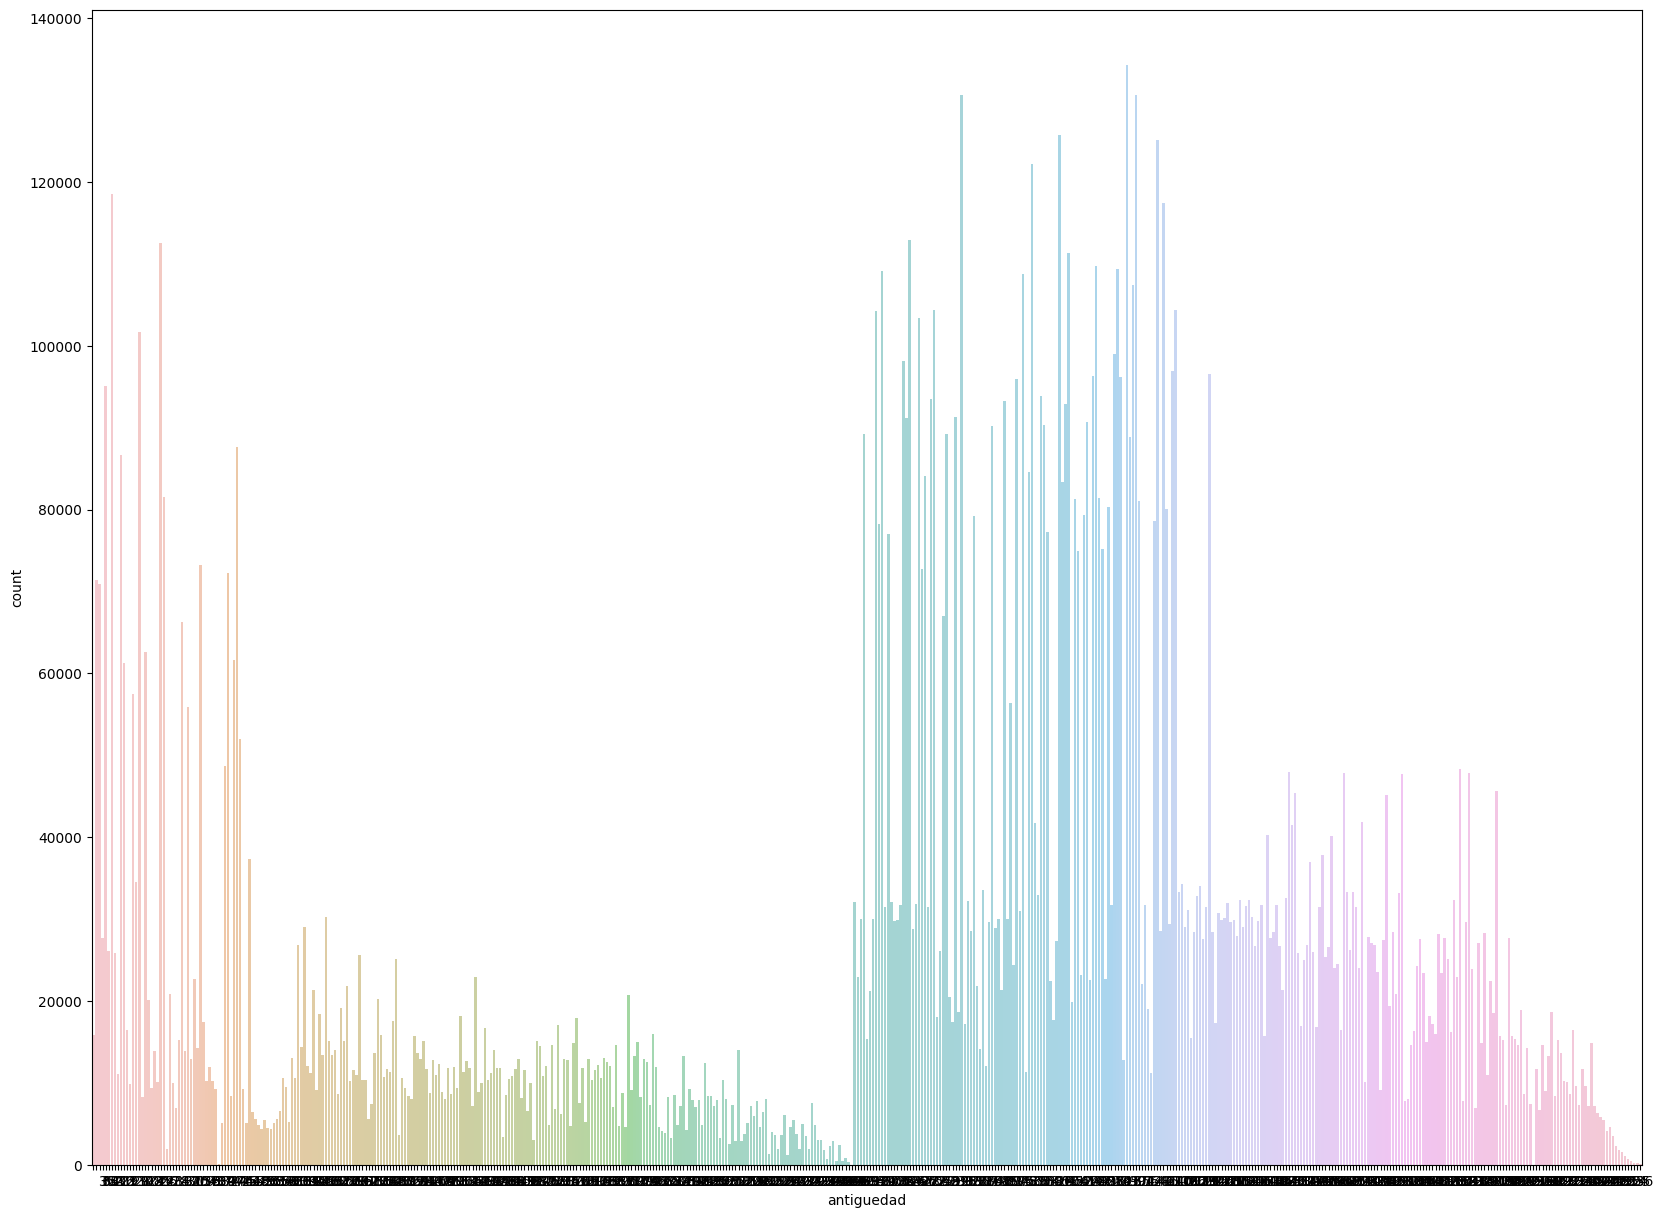

--------------------------------------------------
col :  indrel


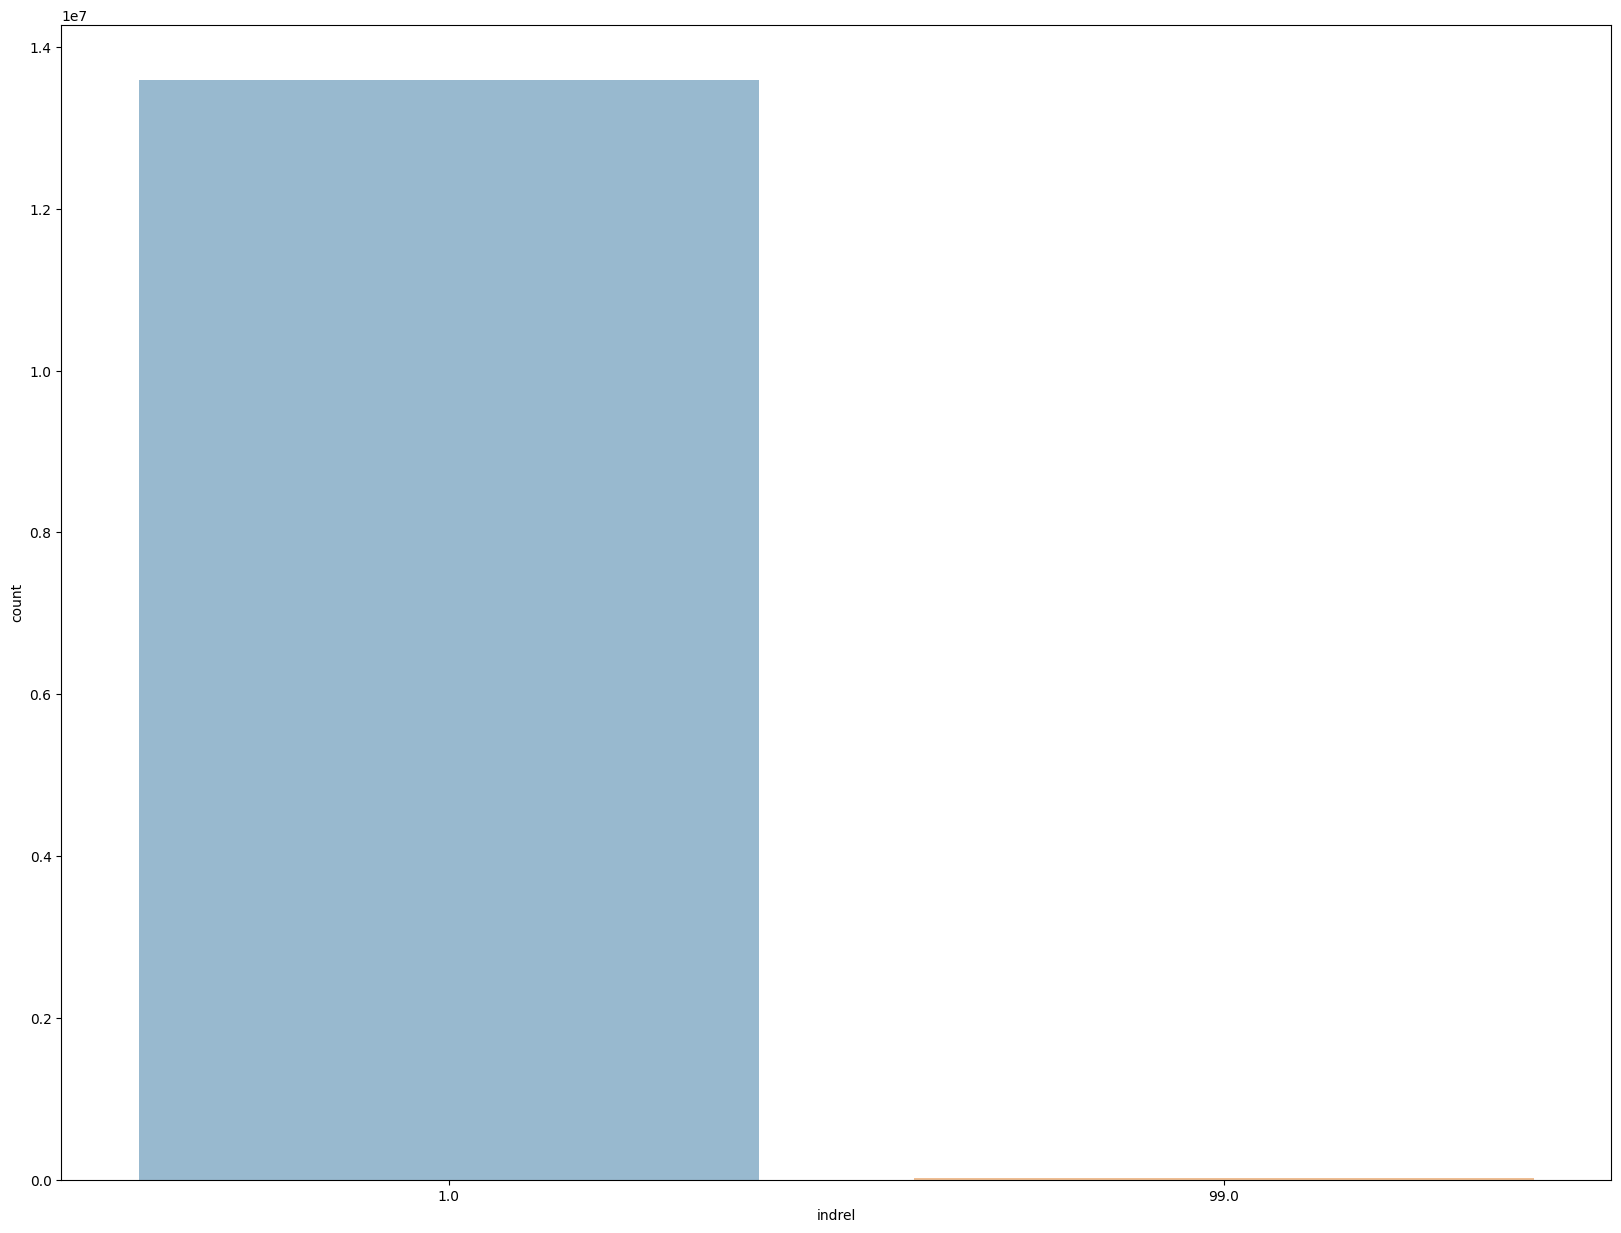

--------------------------------------------------
col :  ult_fec_cli_1t


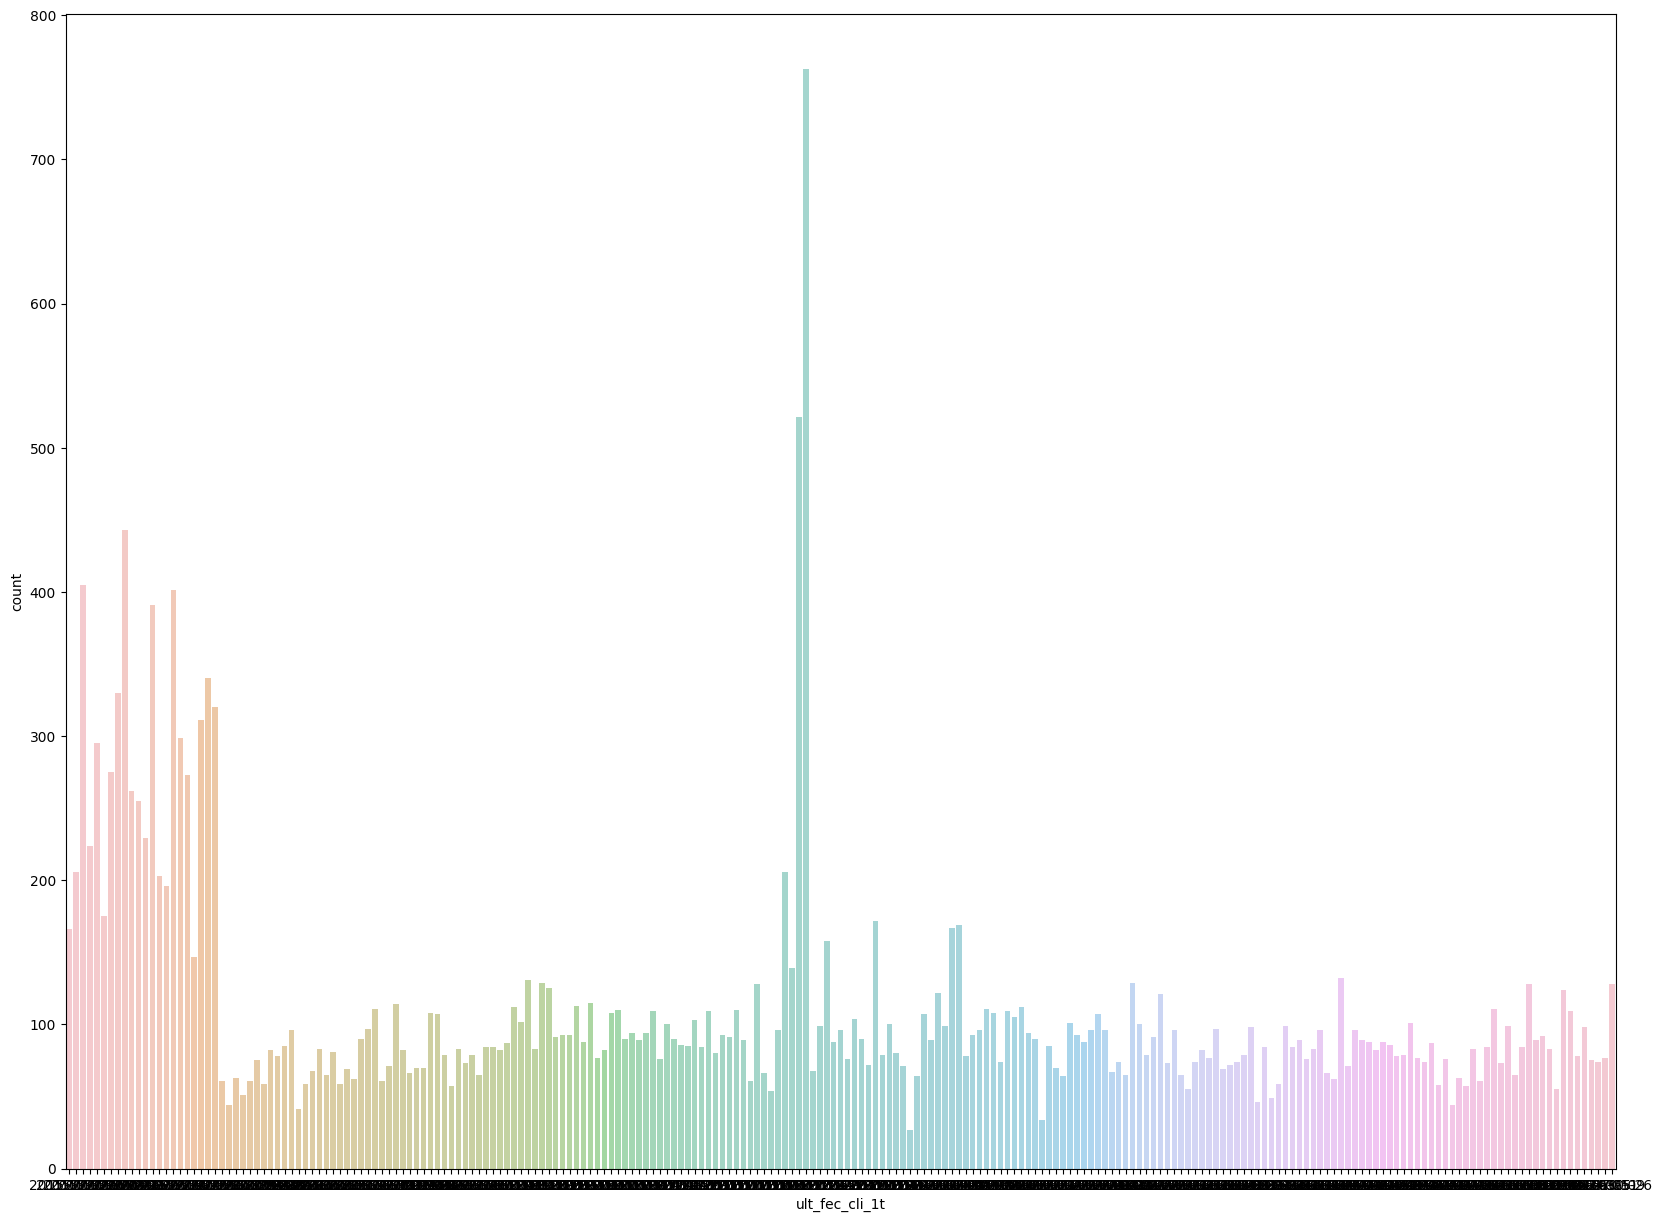

--------------------------------------------------
col :  indrel_1mes


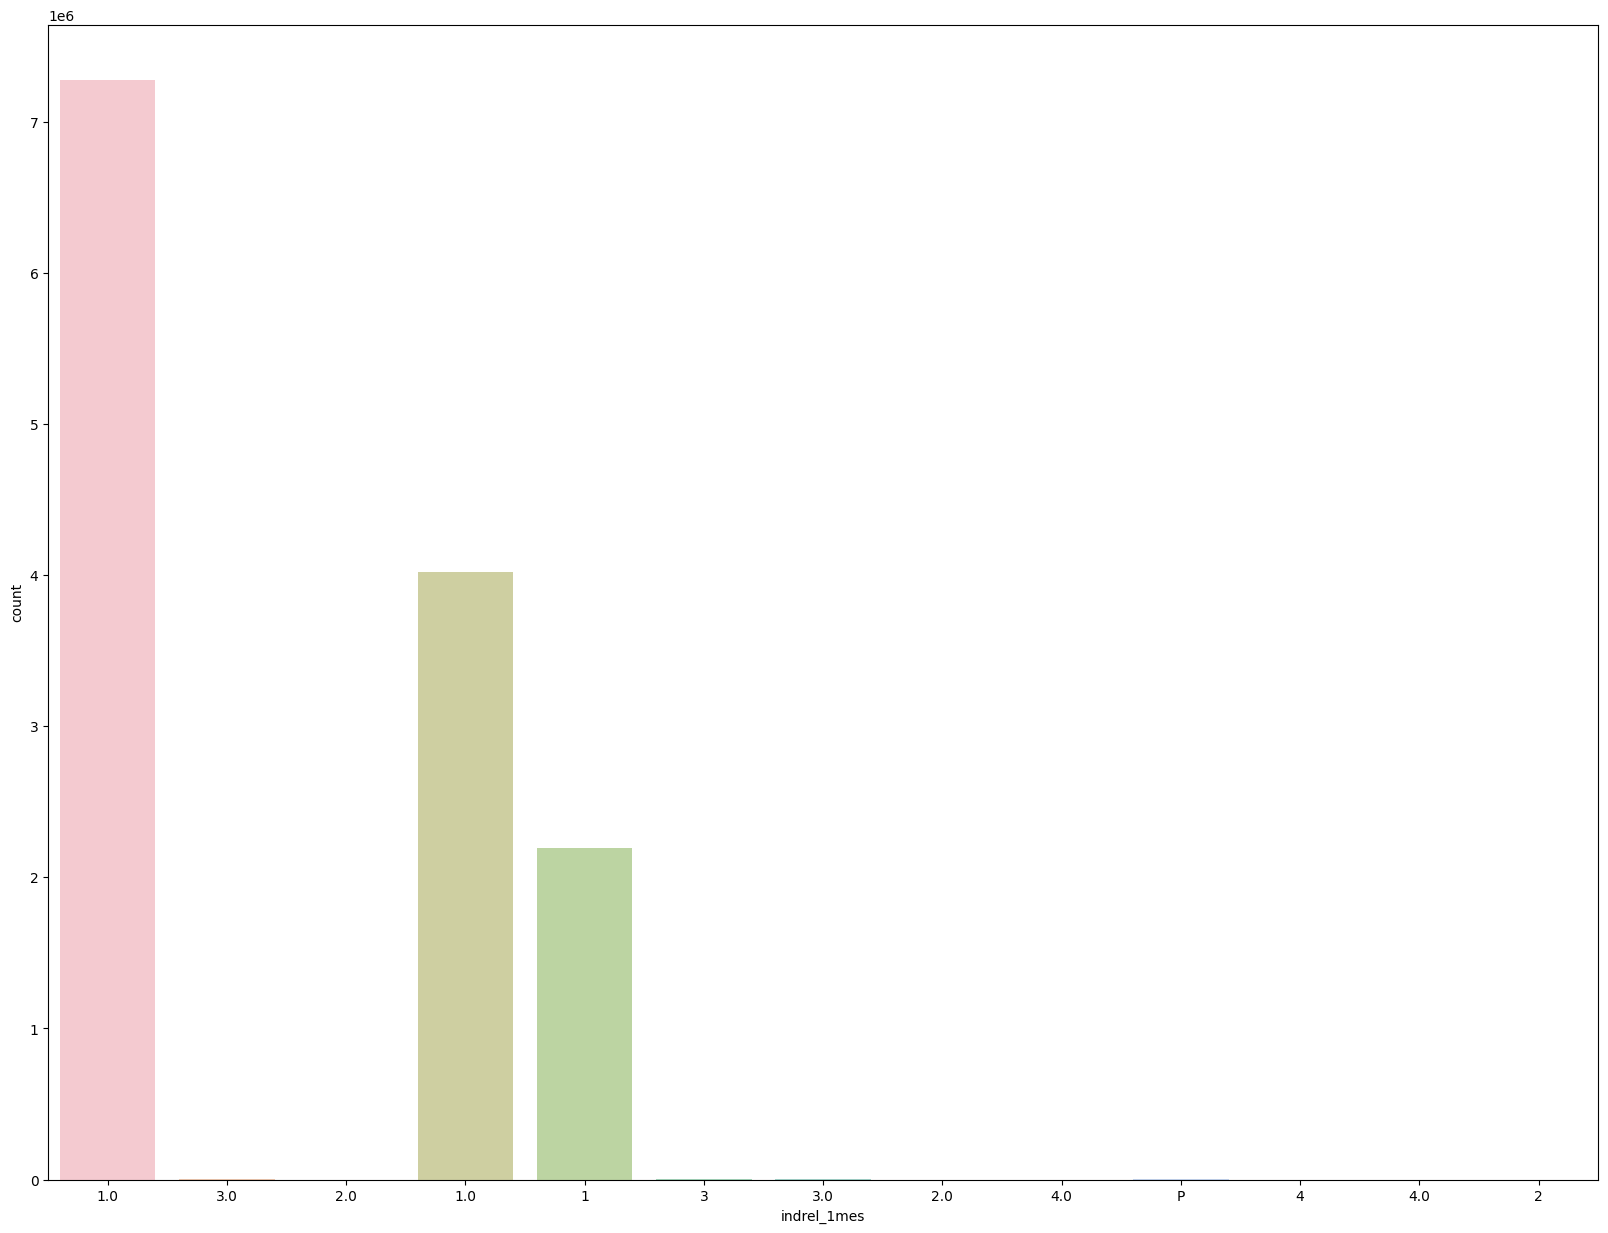

--------------------------------------------------
col :  tiprel_1mes


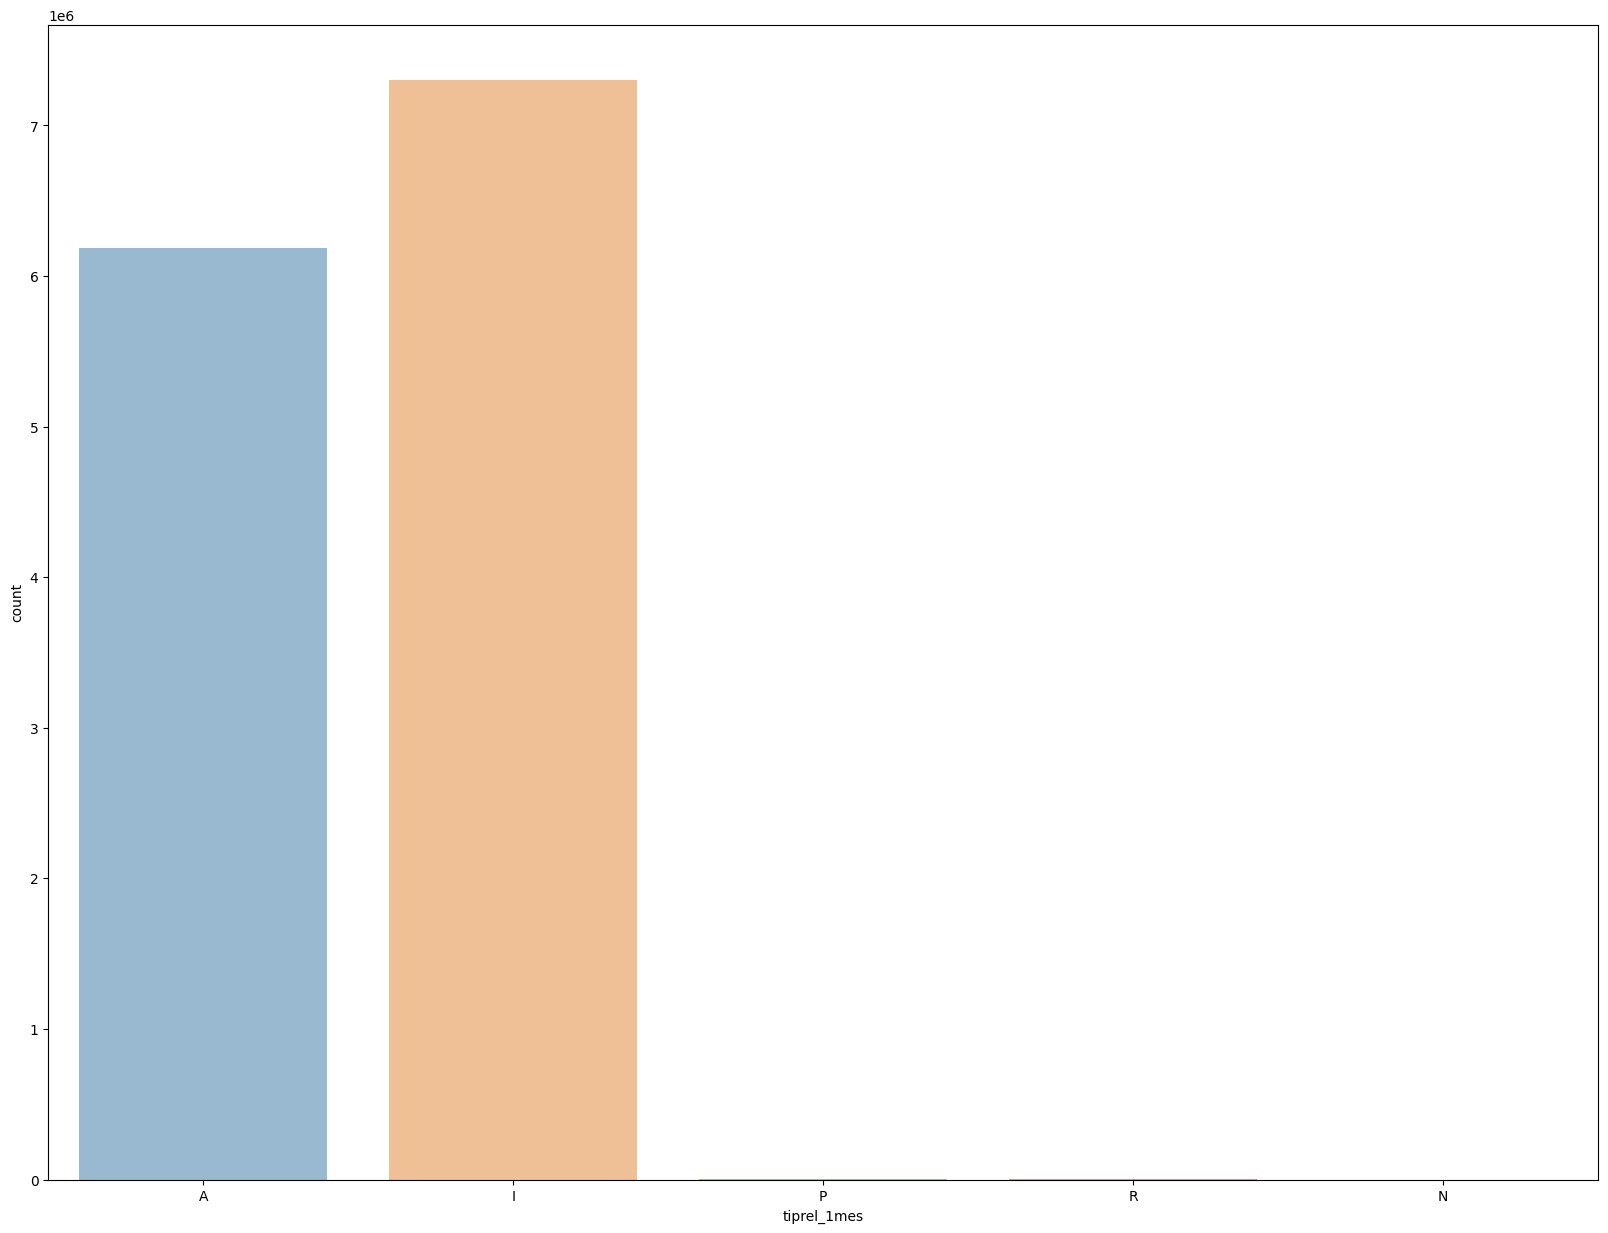

--------------------------------------------------
col :  indresi


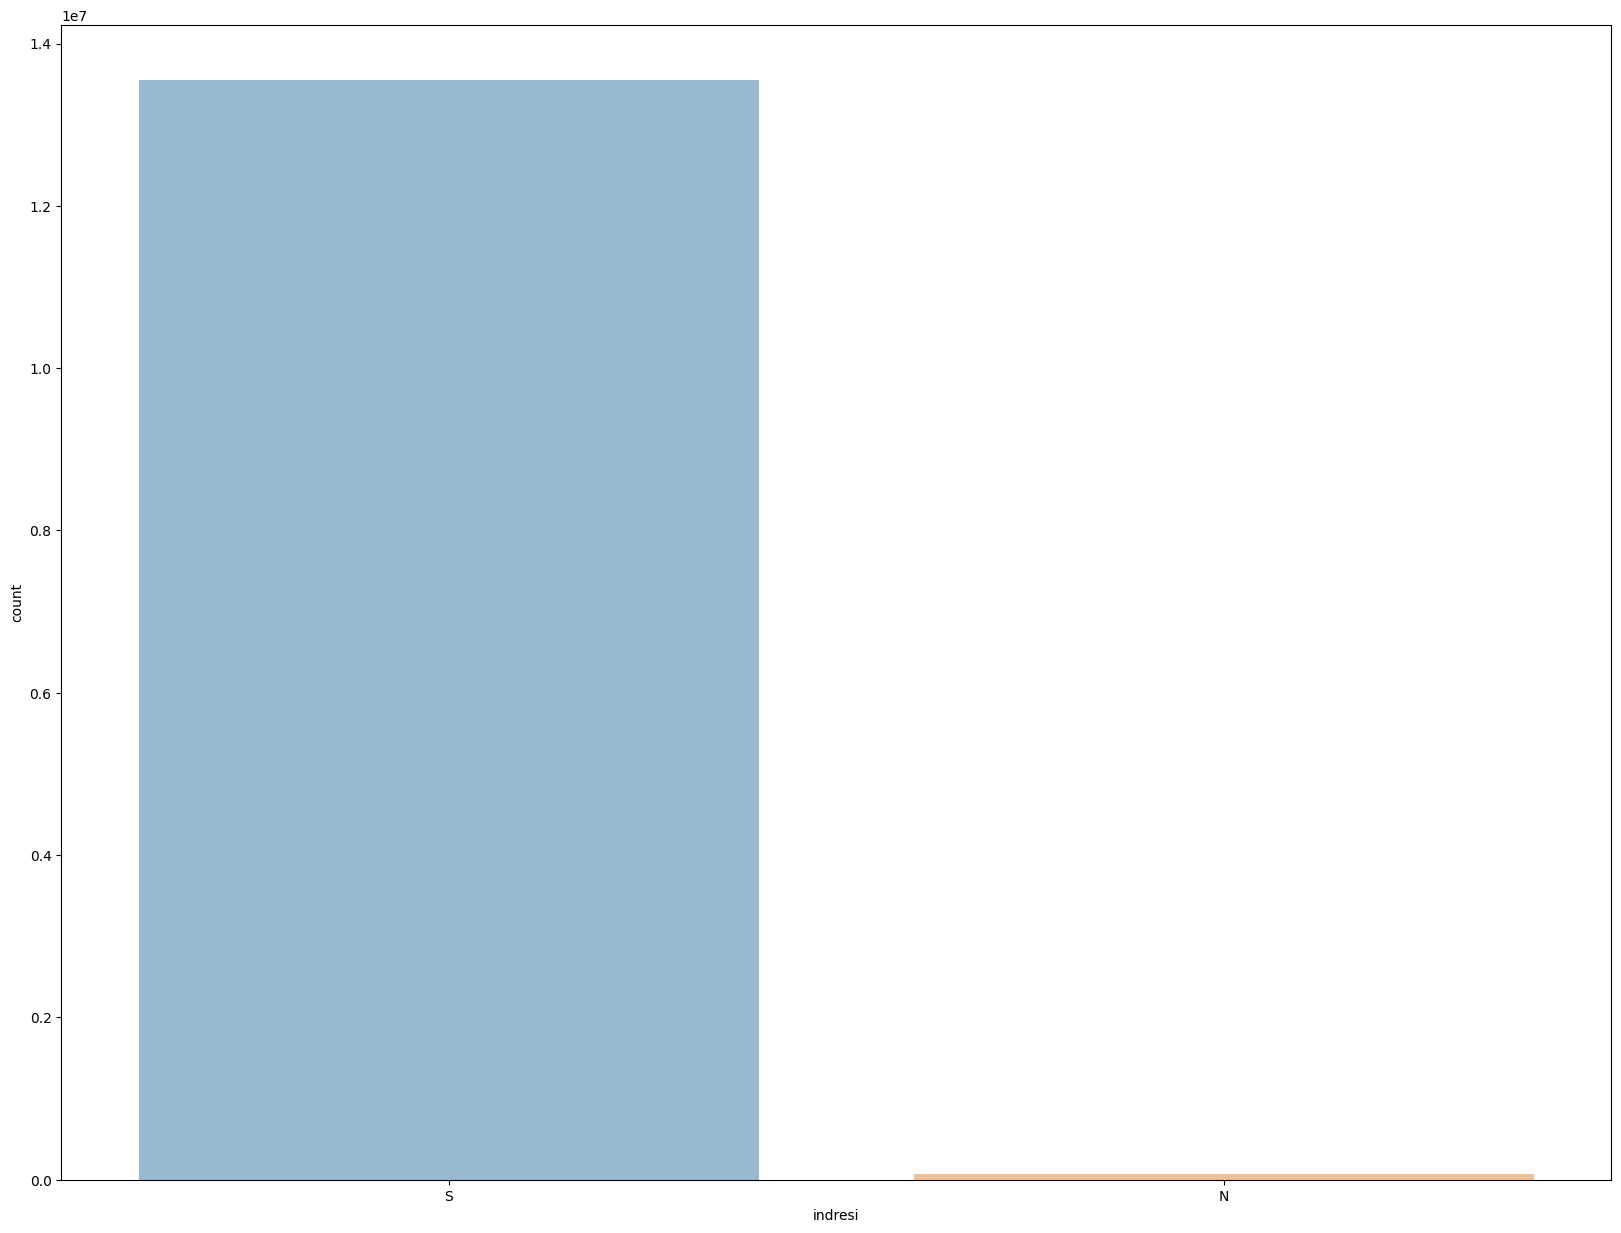

--------------------------------------------------
col :  indext


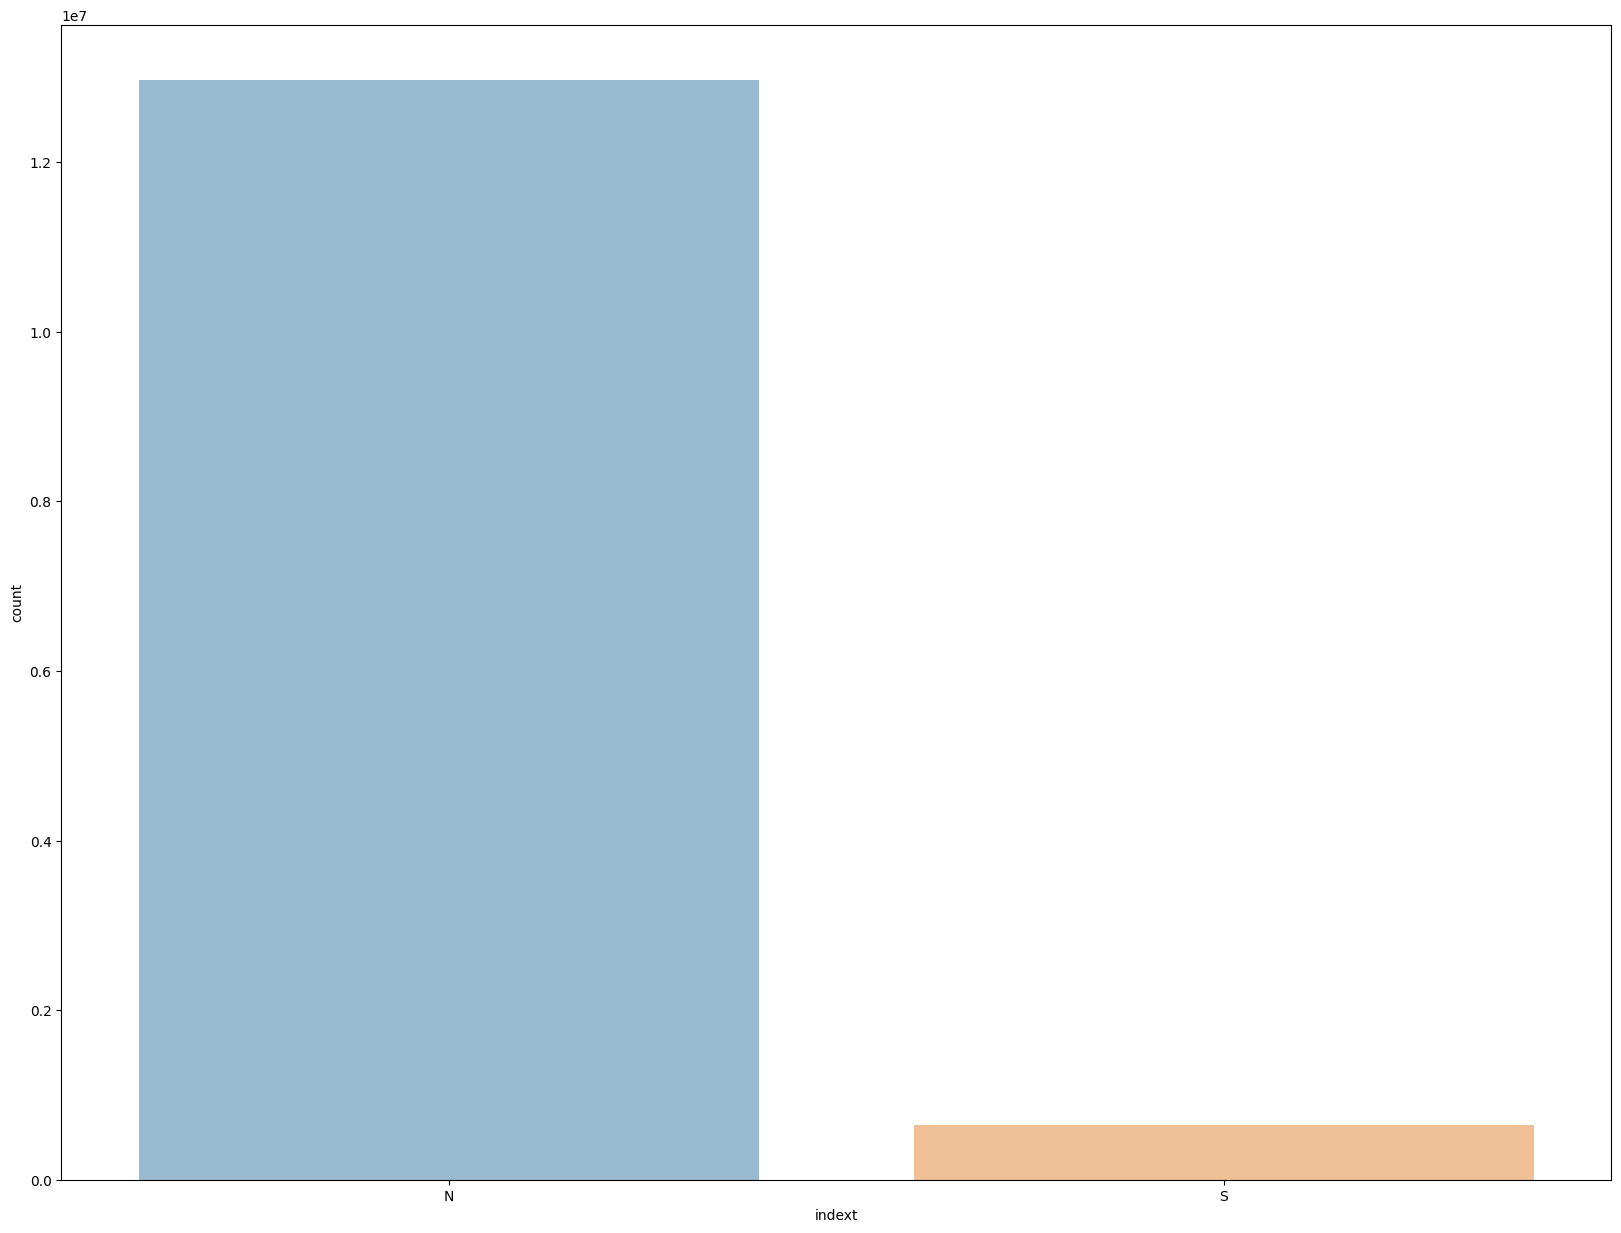

--------------------------------------------------
col :  conyuemp


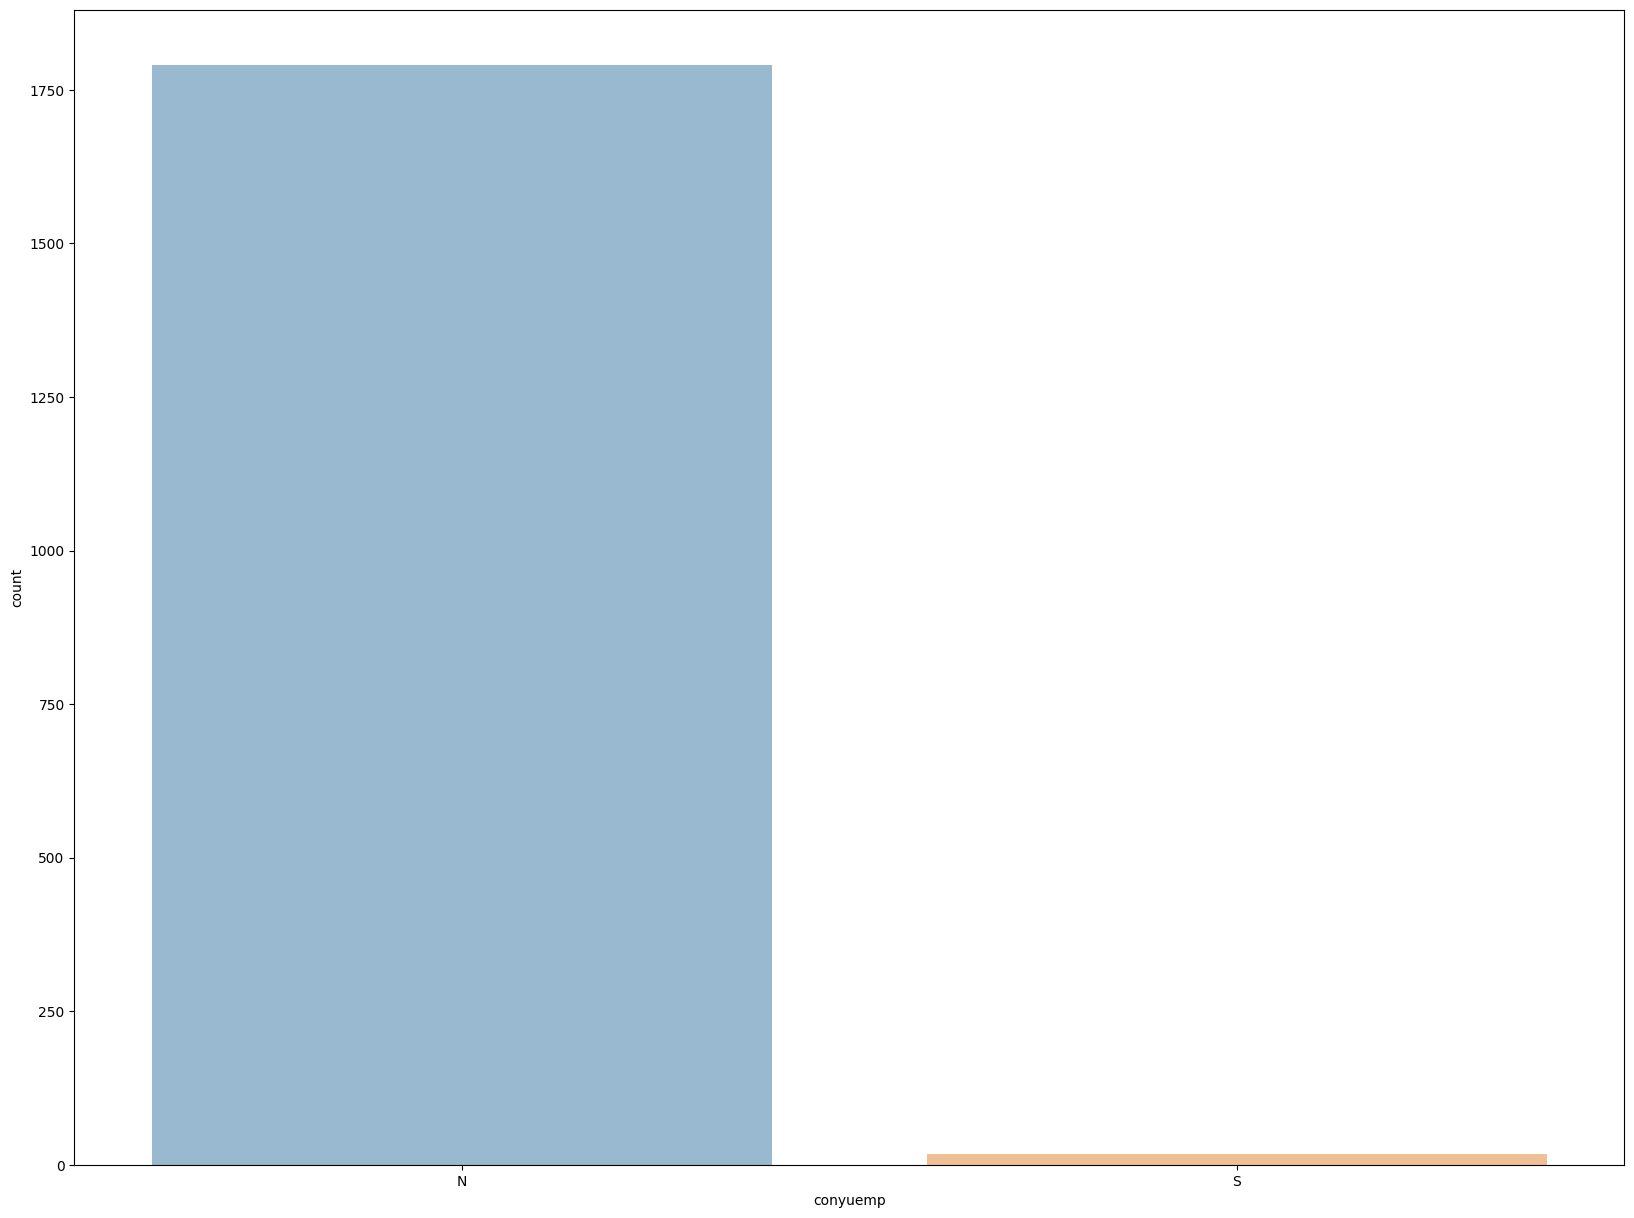

--------------------------------------------------
col :  canal_entrada


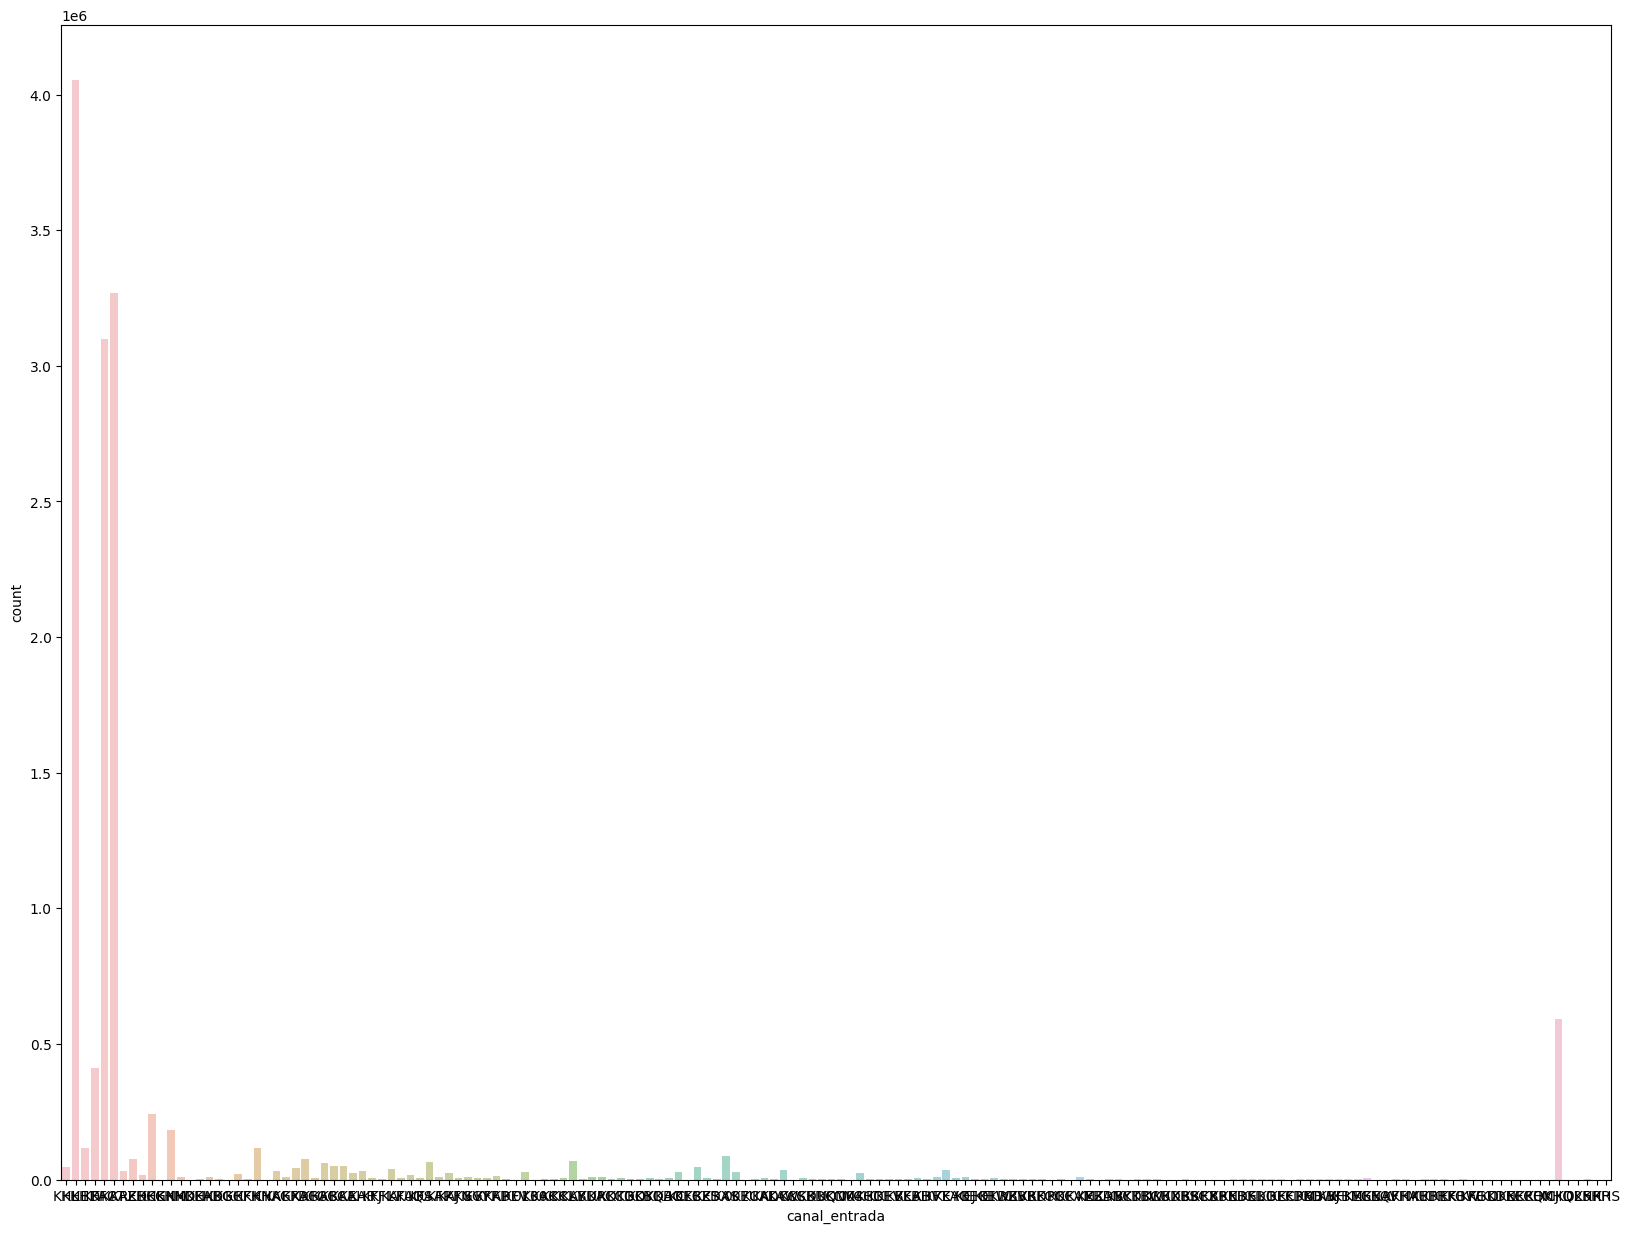

--------------------------------------------------
col :  indfall


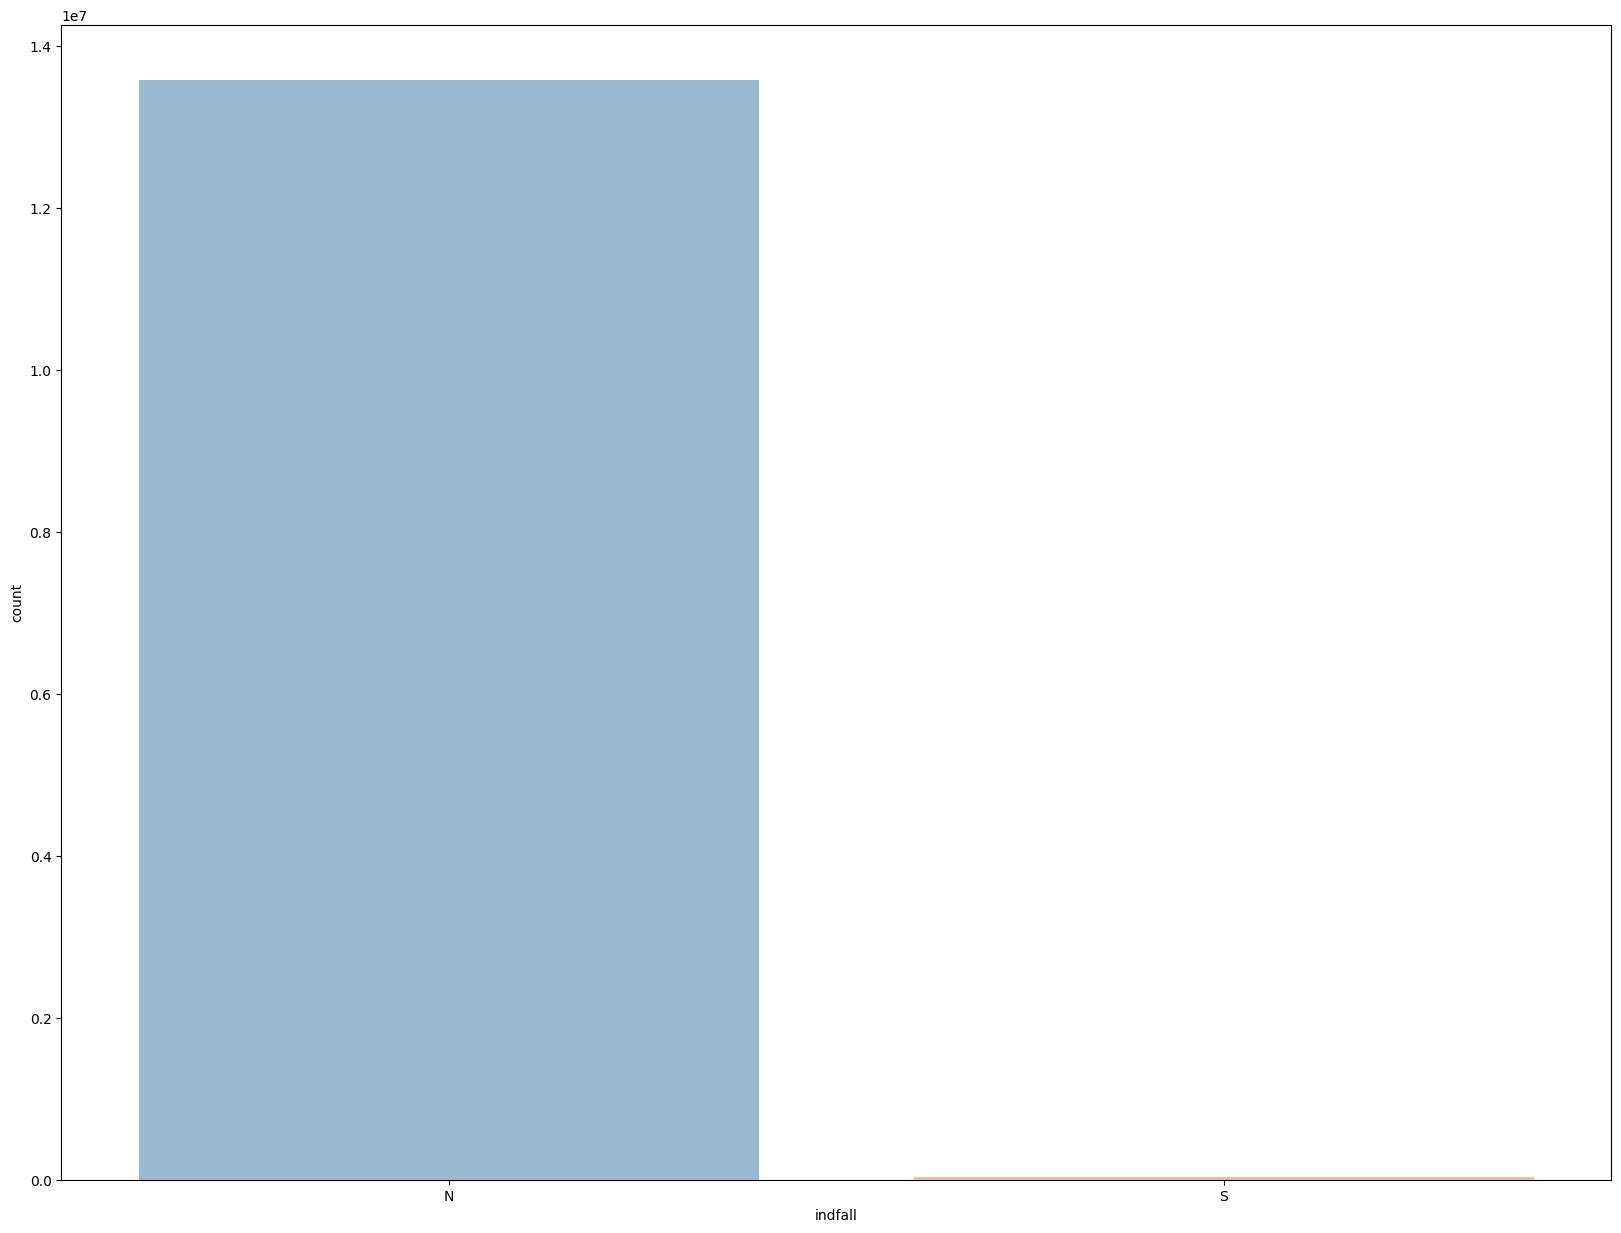

--------------------------------------------------
col :  tipodom


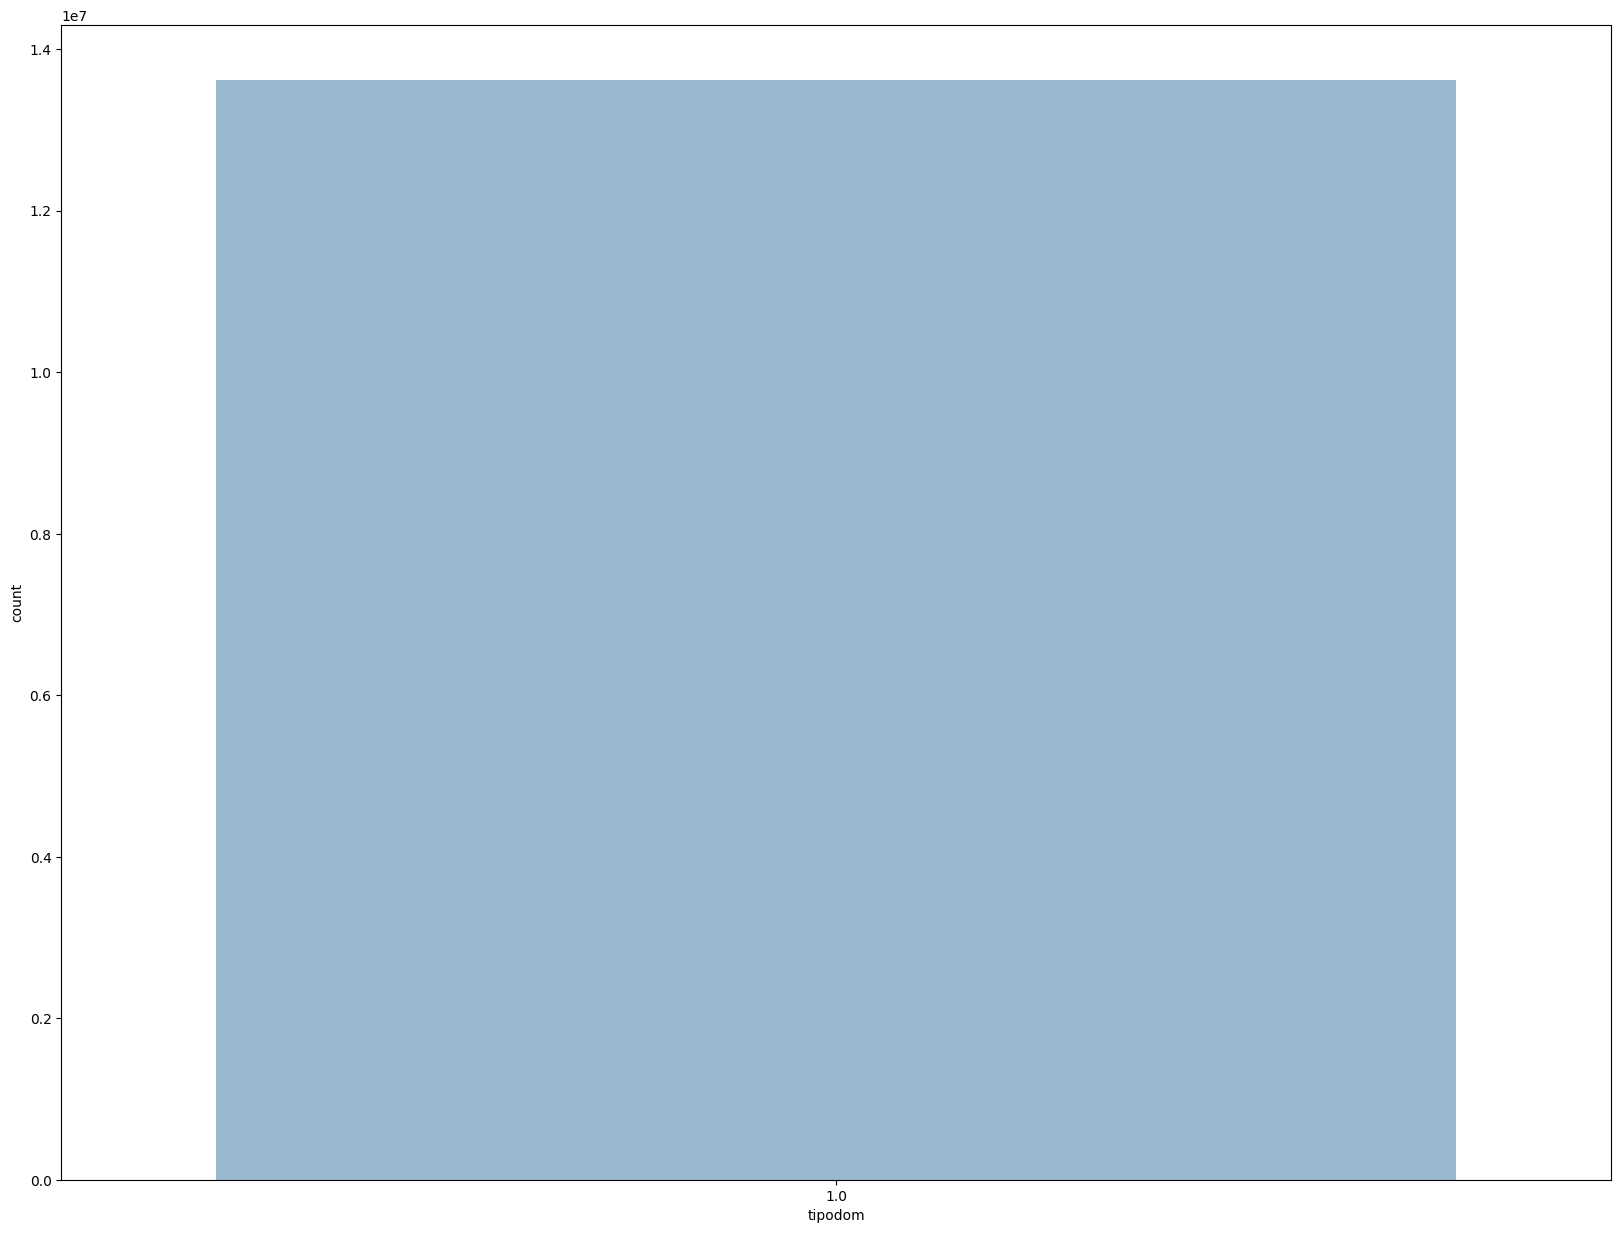

--------------------------------------------------
col :  cod_prov


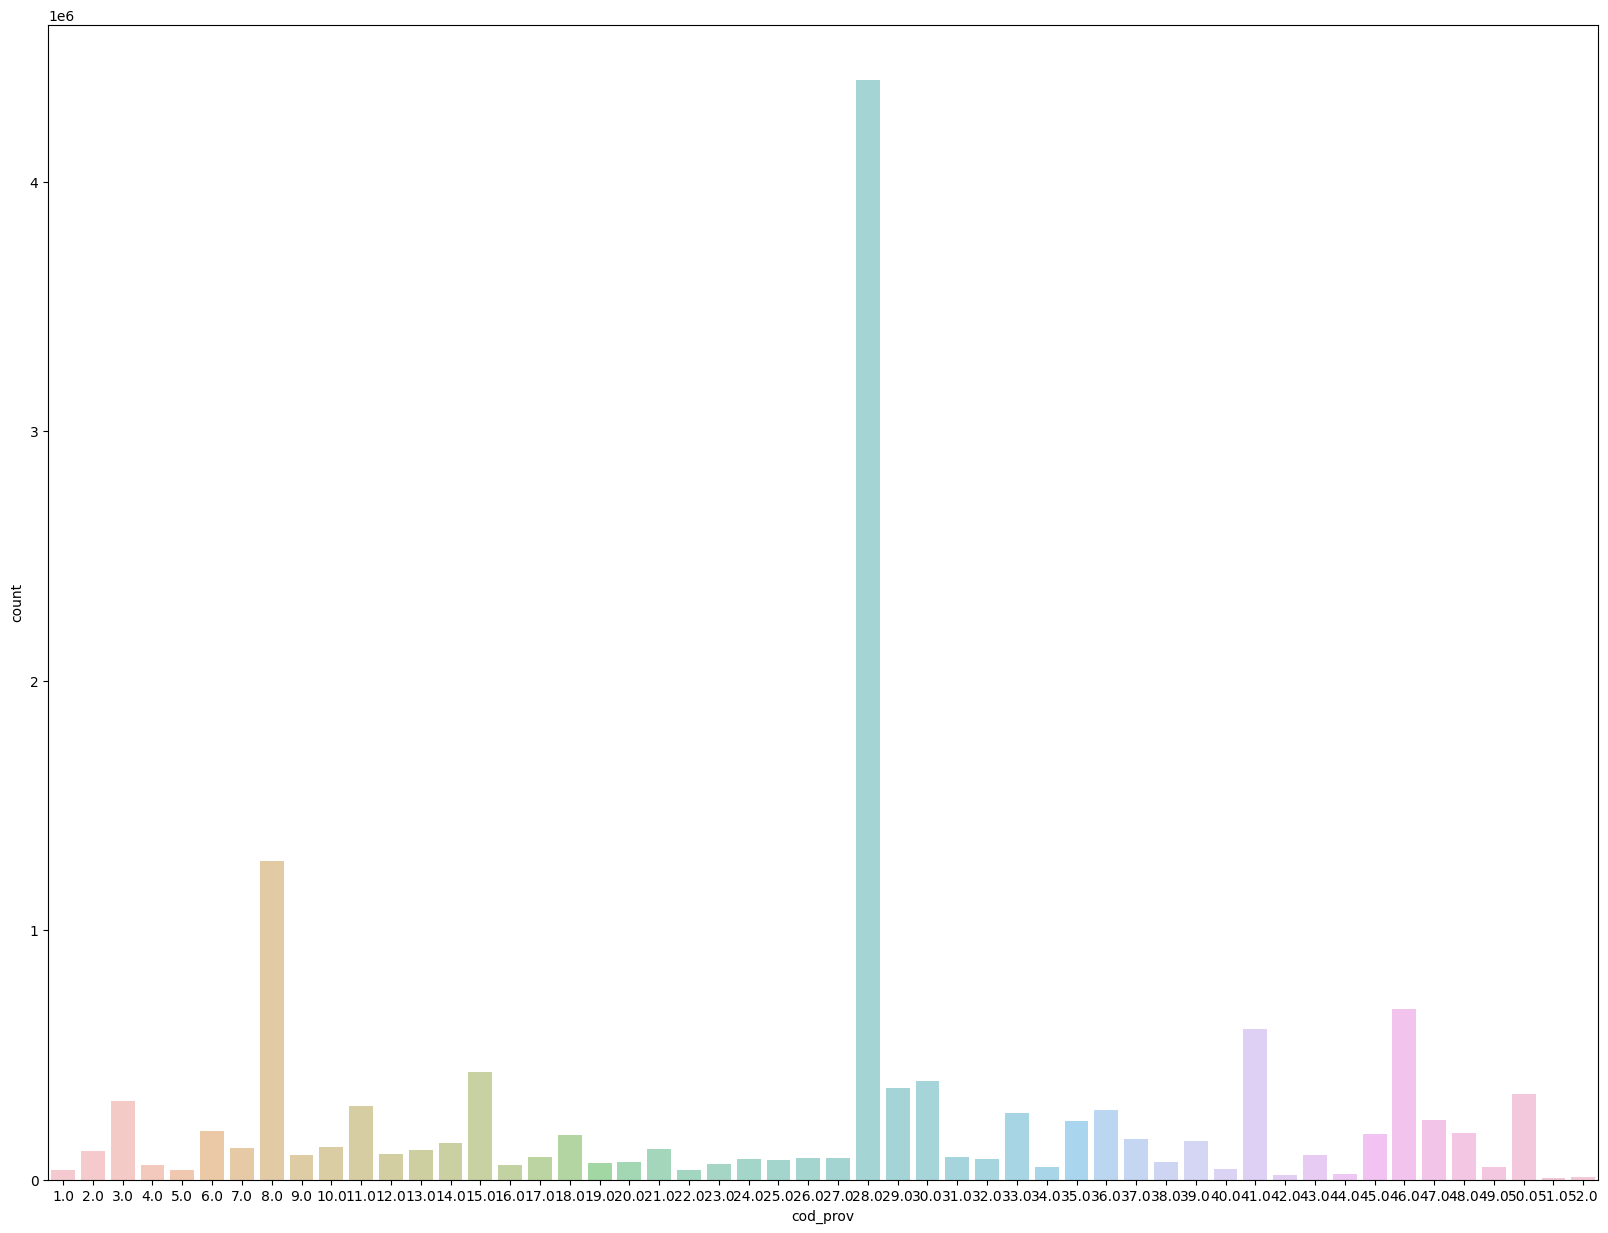

--------------------------------------------------
col :  nomprov


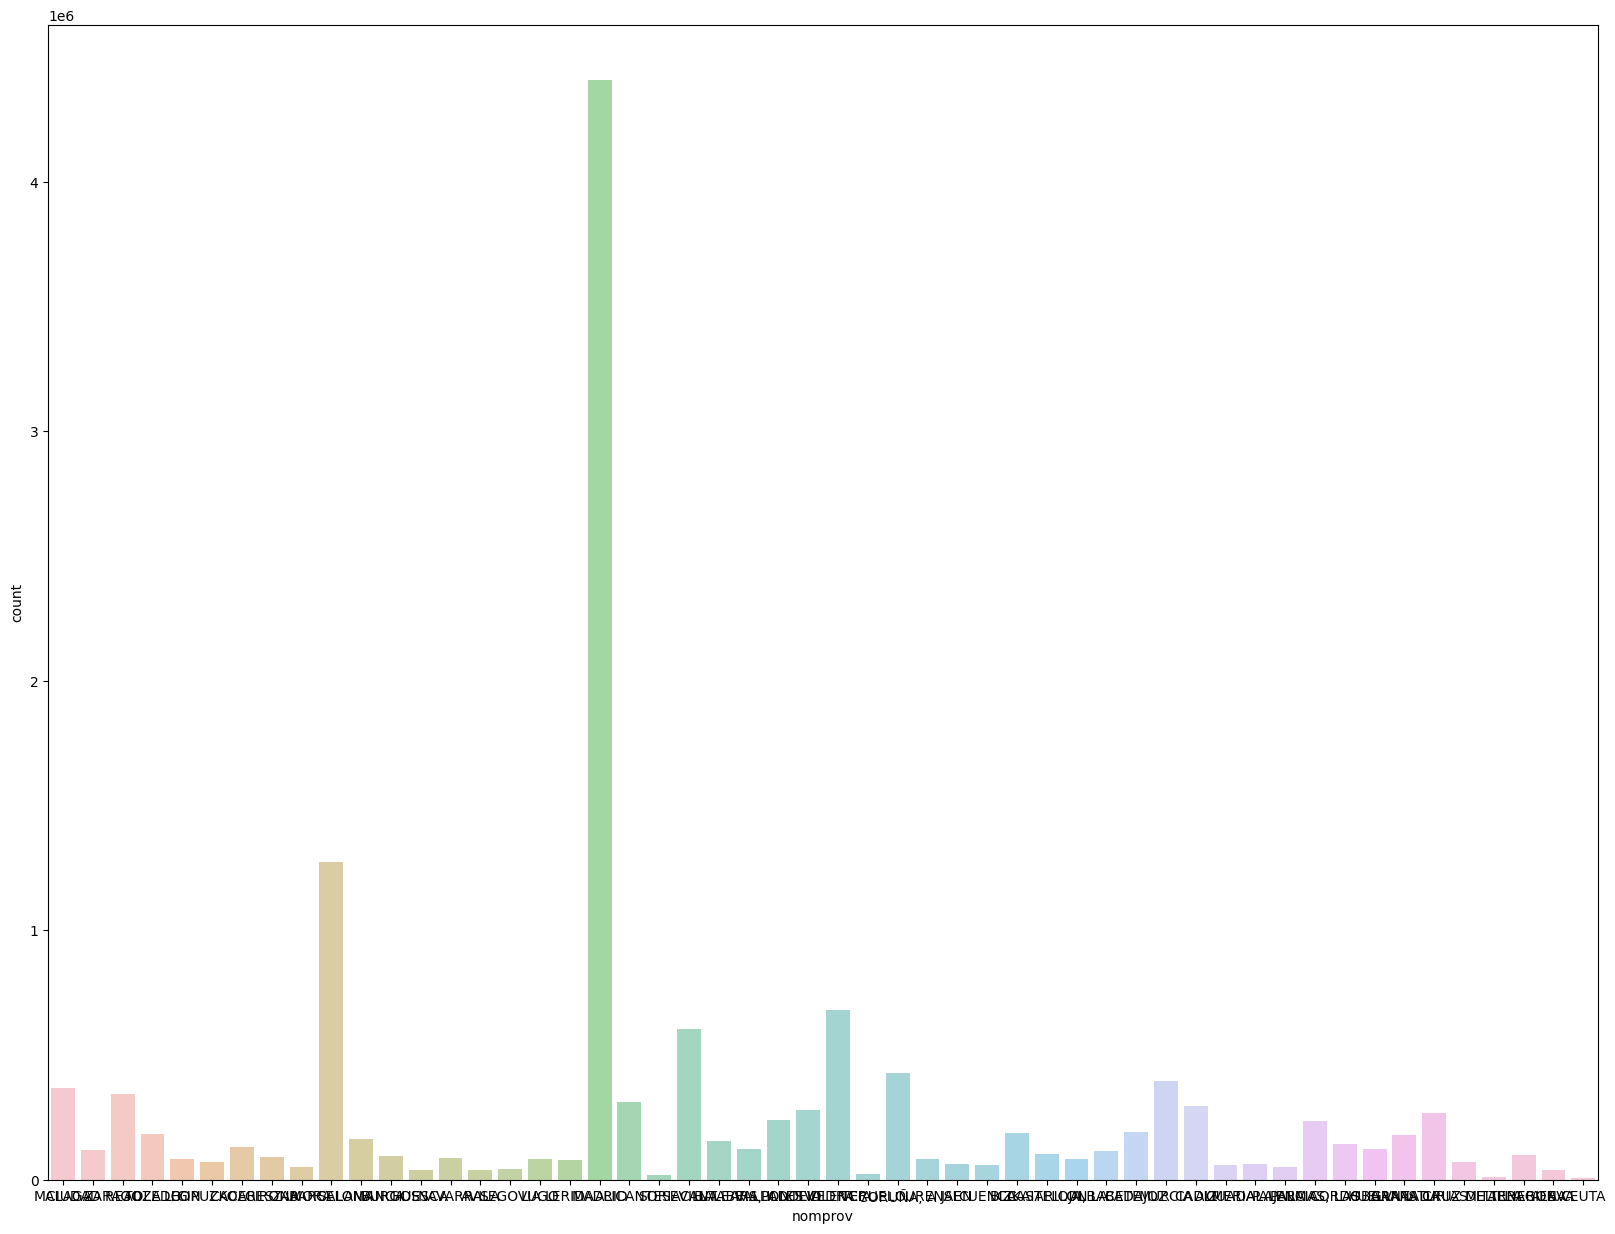

--------------------------------------------------
col :  ind_actividad_cliente


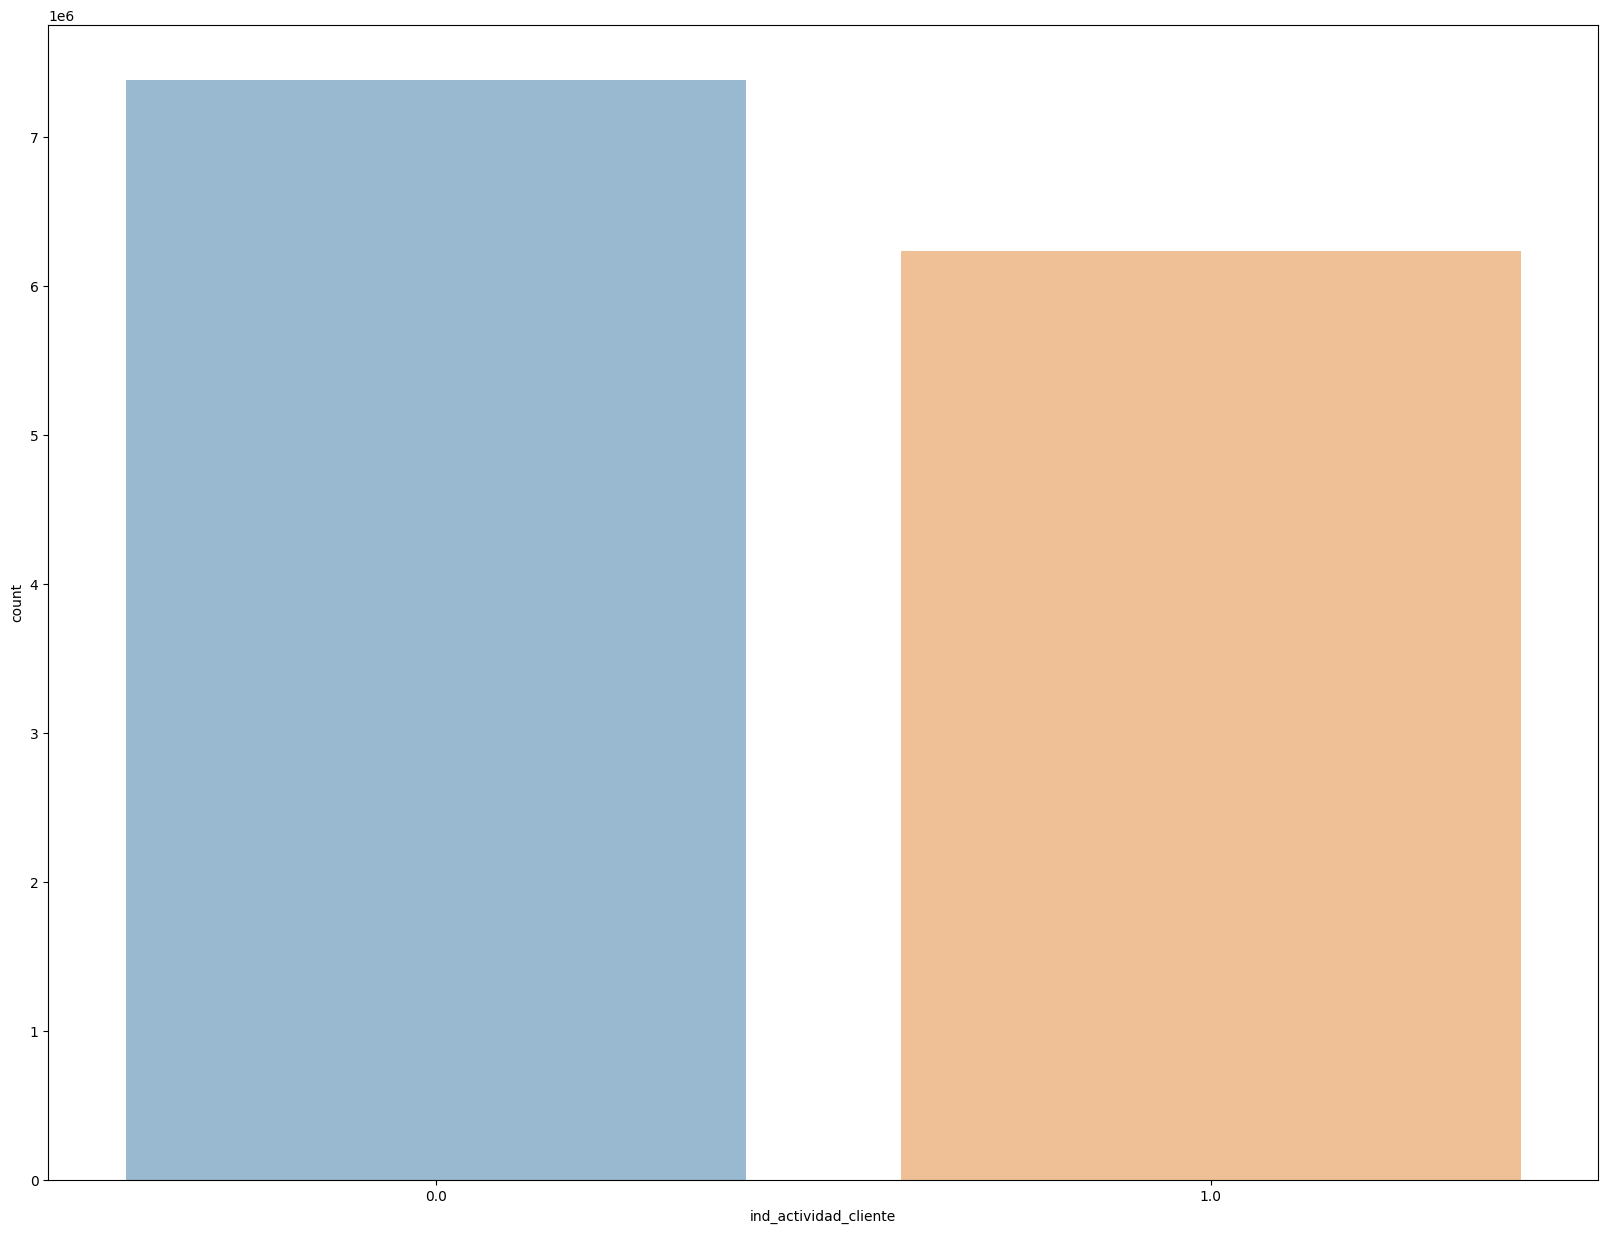

--------------------------------------------------
col :  segmento


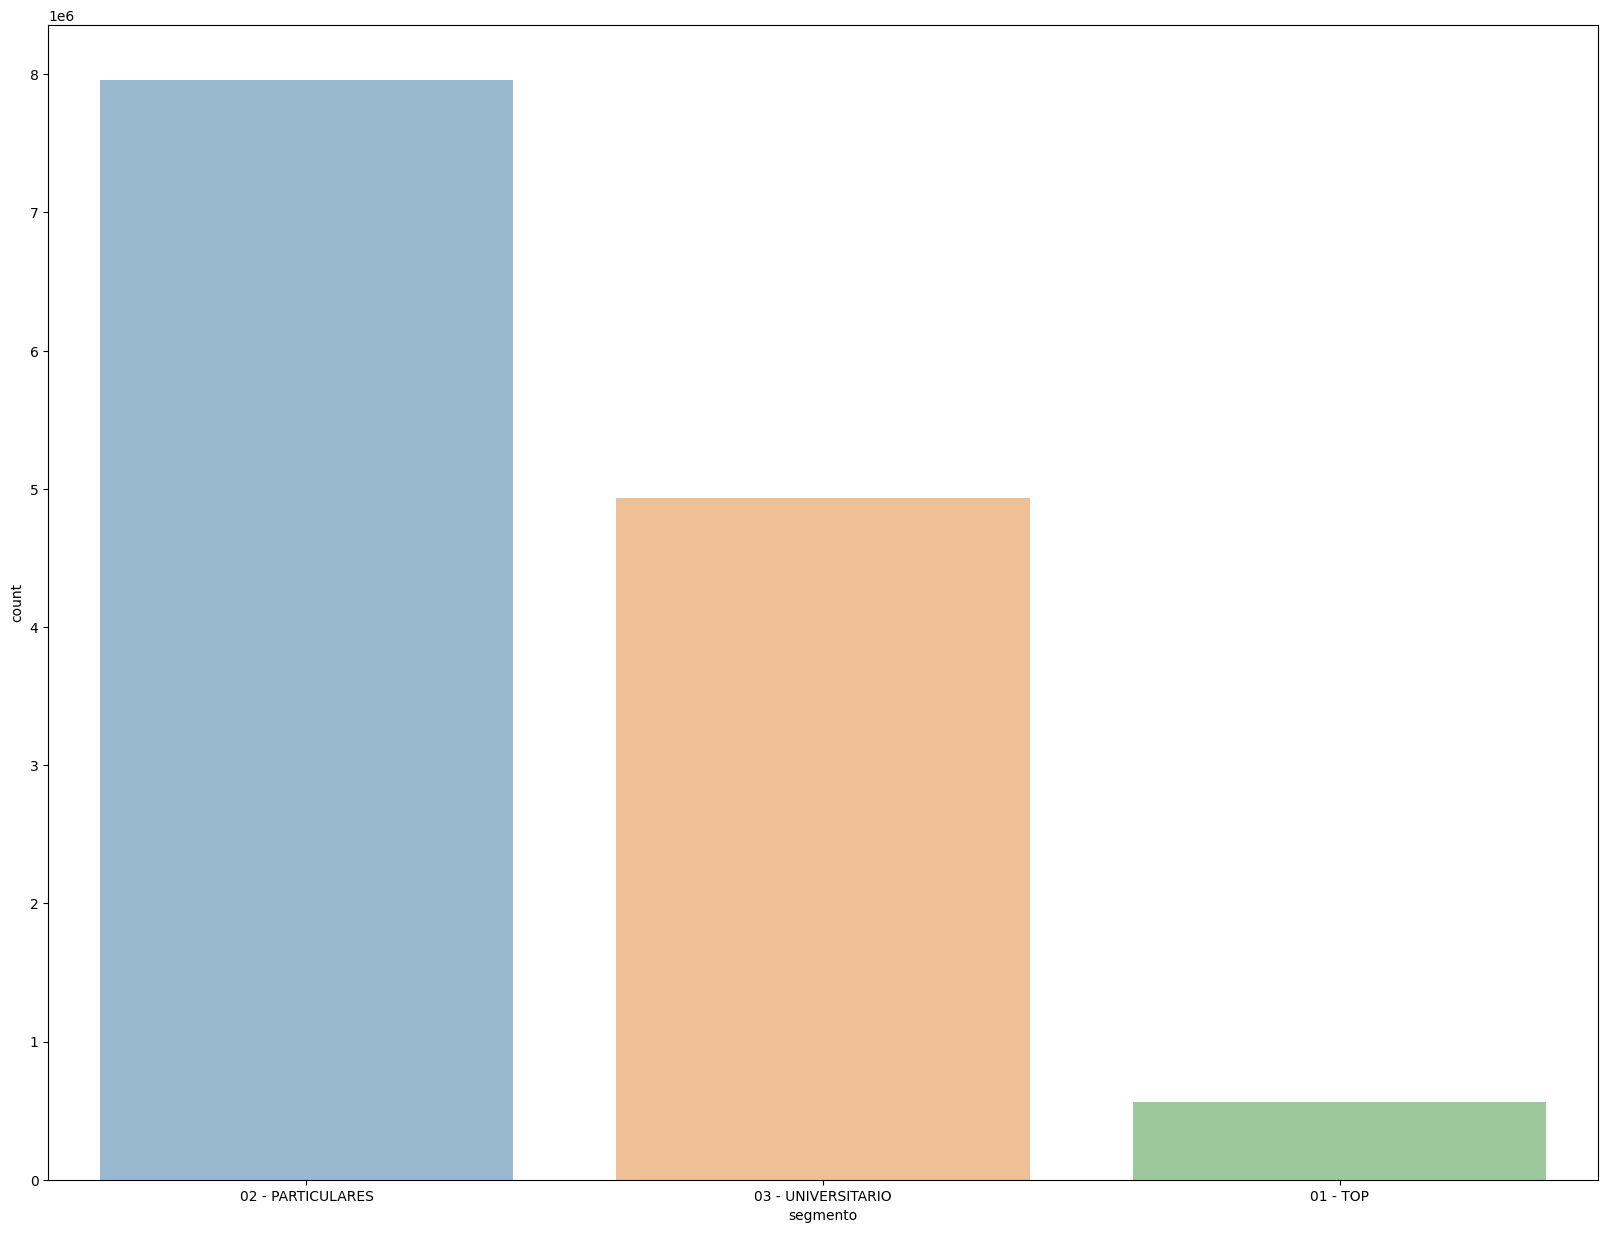

--------------------------------------------------
col :  ind_ahor_fin_ult1


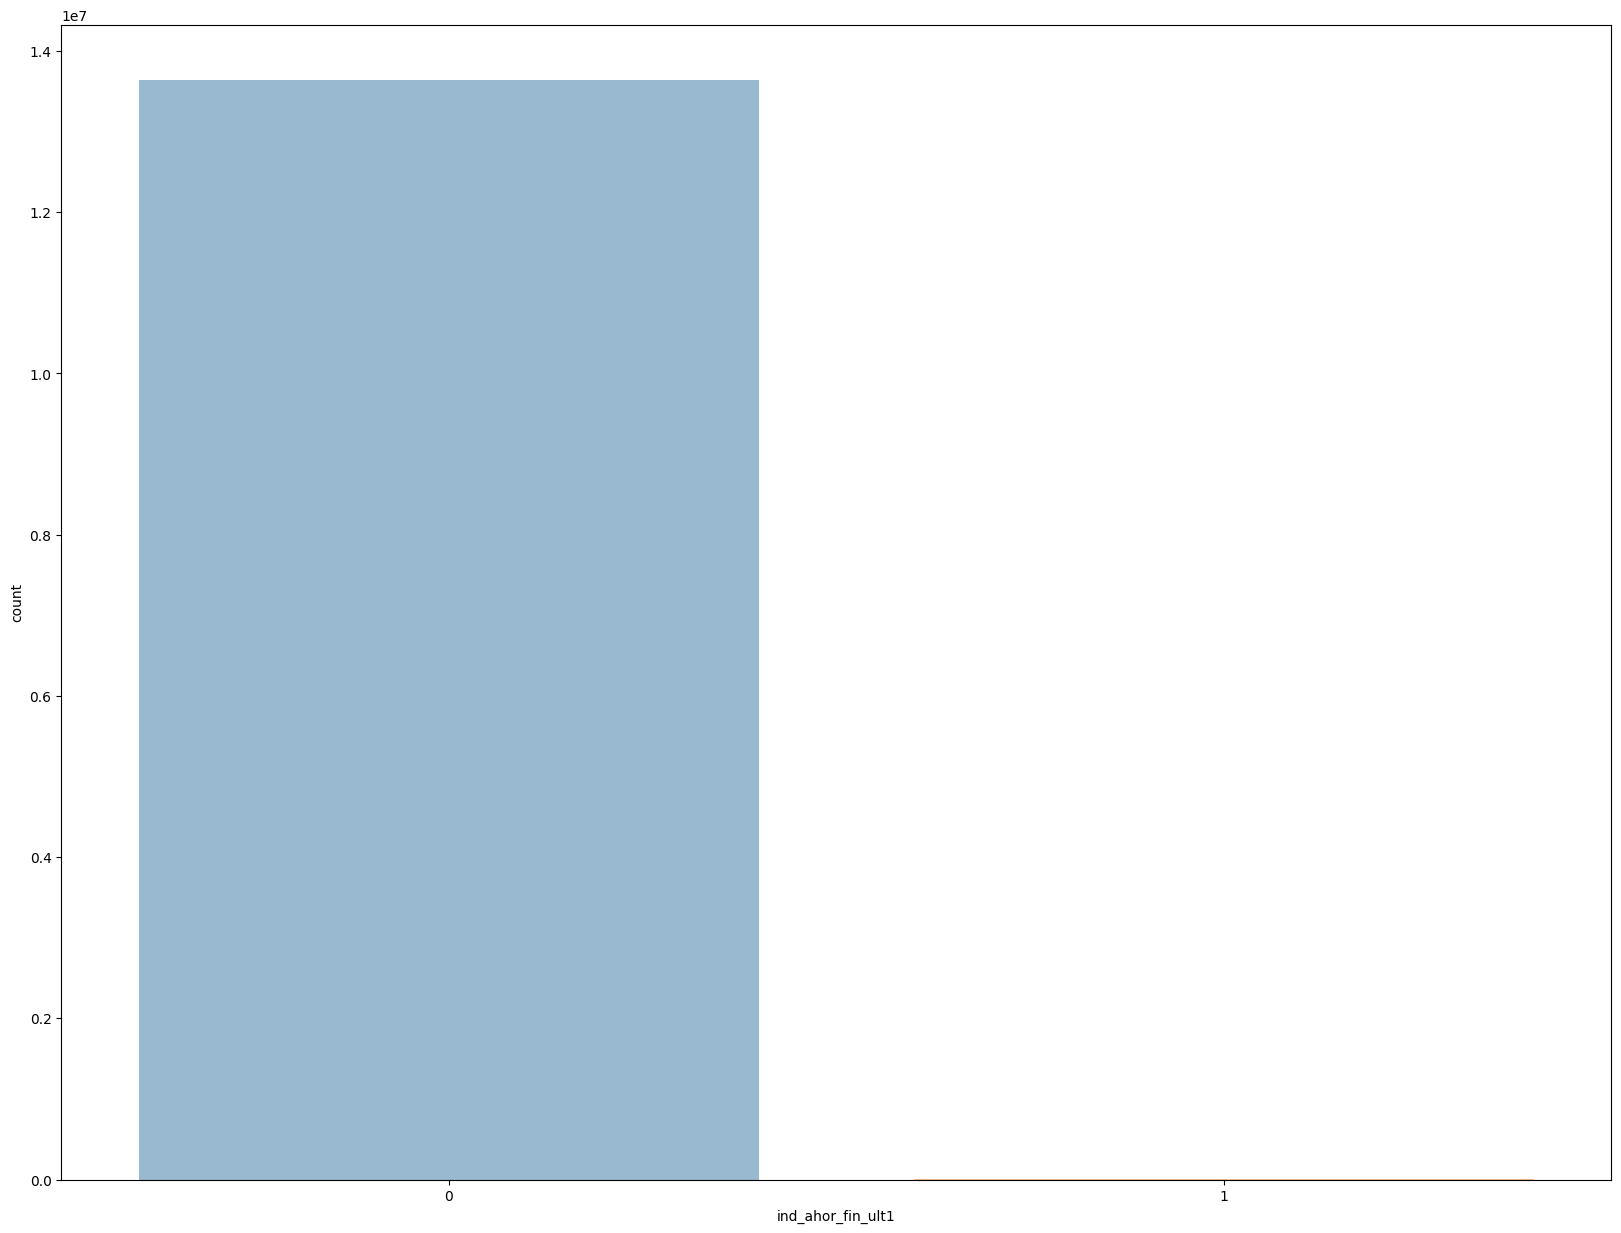

--------------------------------------------------
col :  ind_aval_fin_ult1


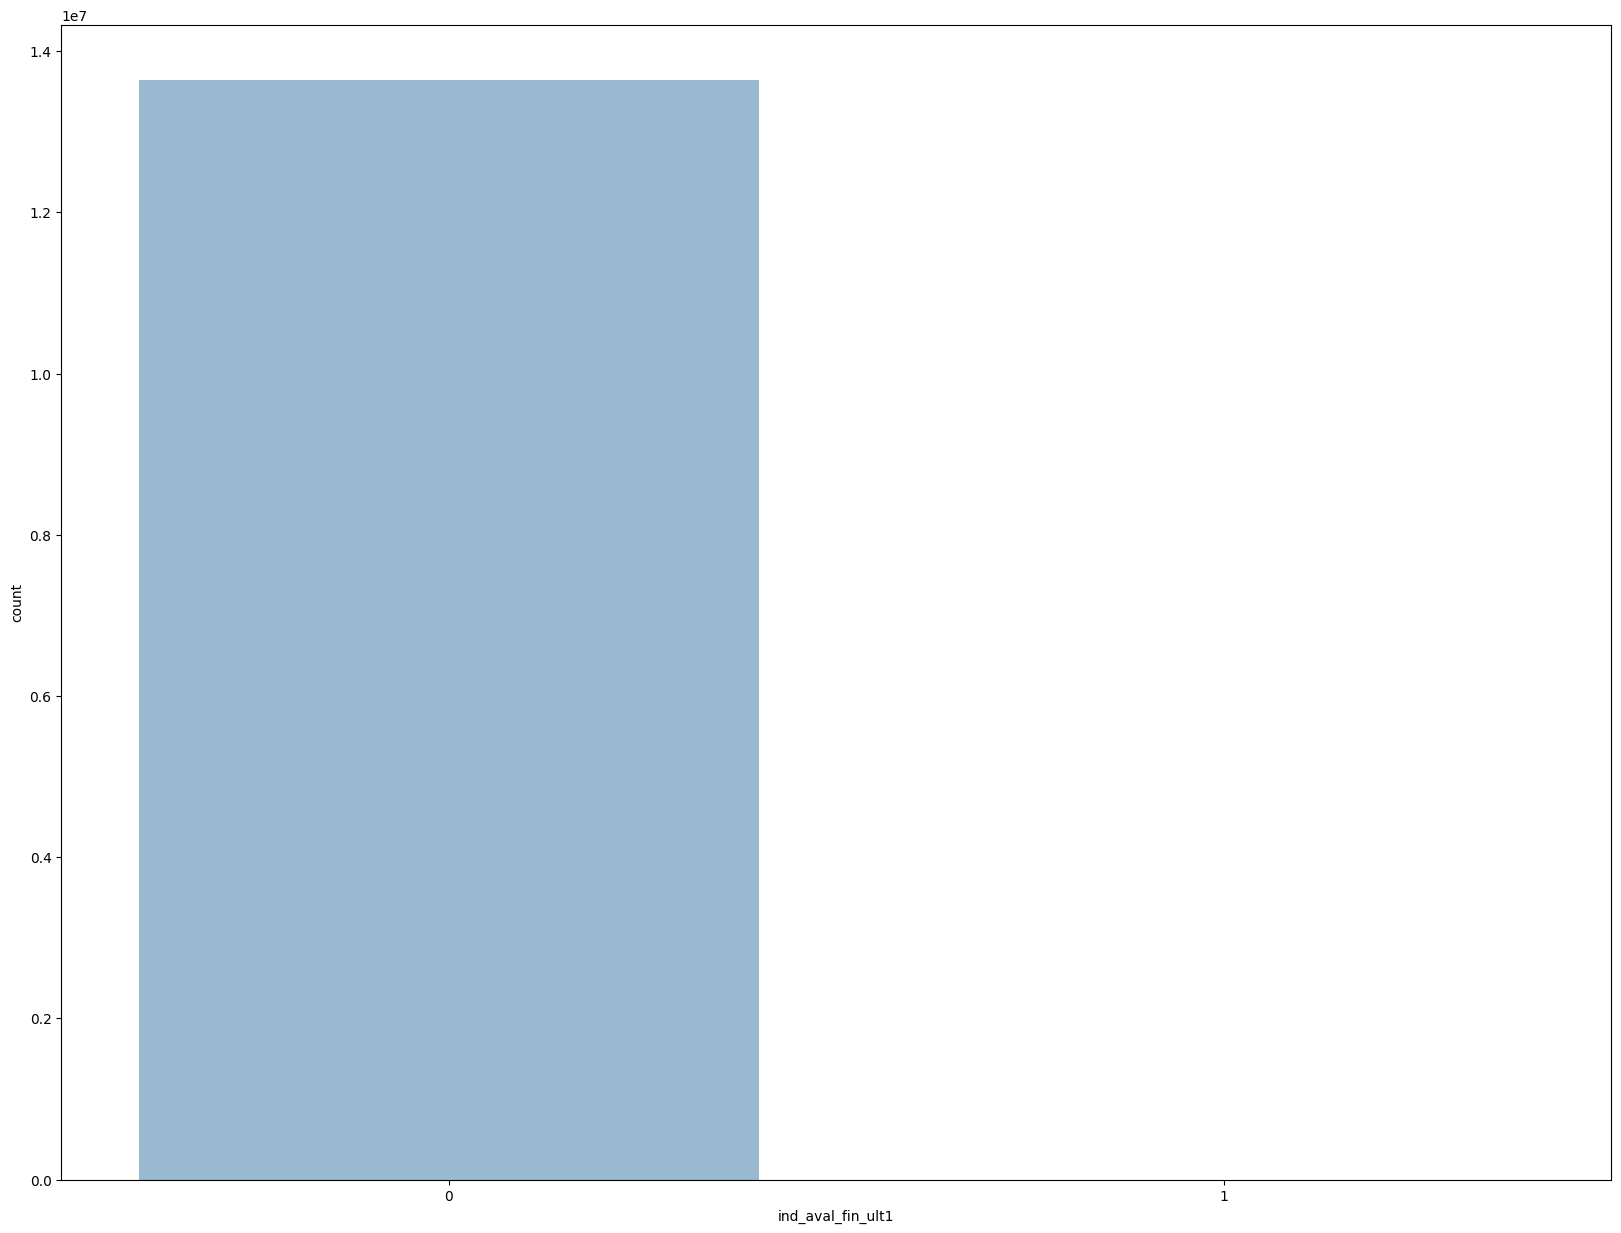

--------------------------------------------------
col :  ind_cco_fin_ult1


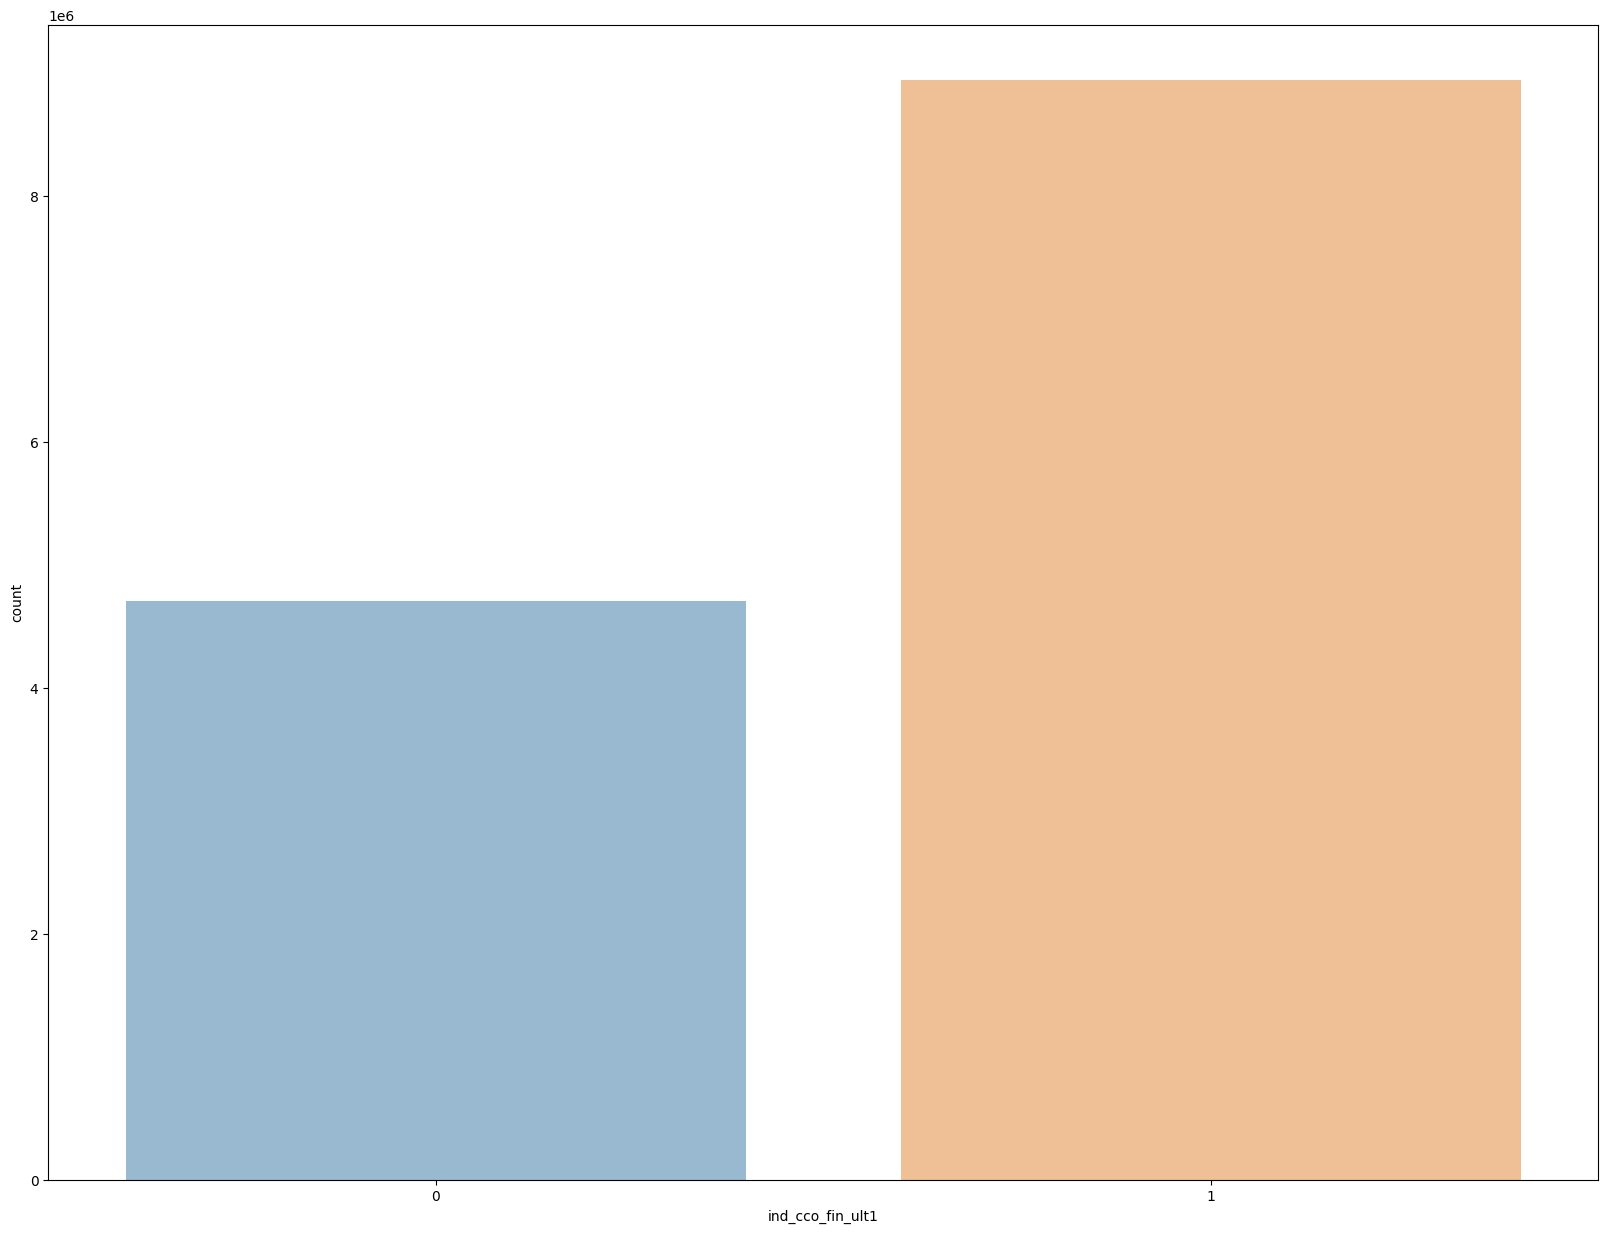

--------------------------------------------------
col :  ind_cder_fin_ult1


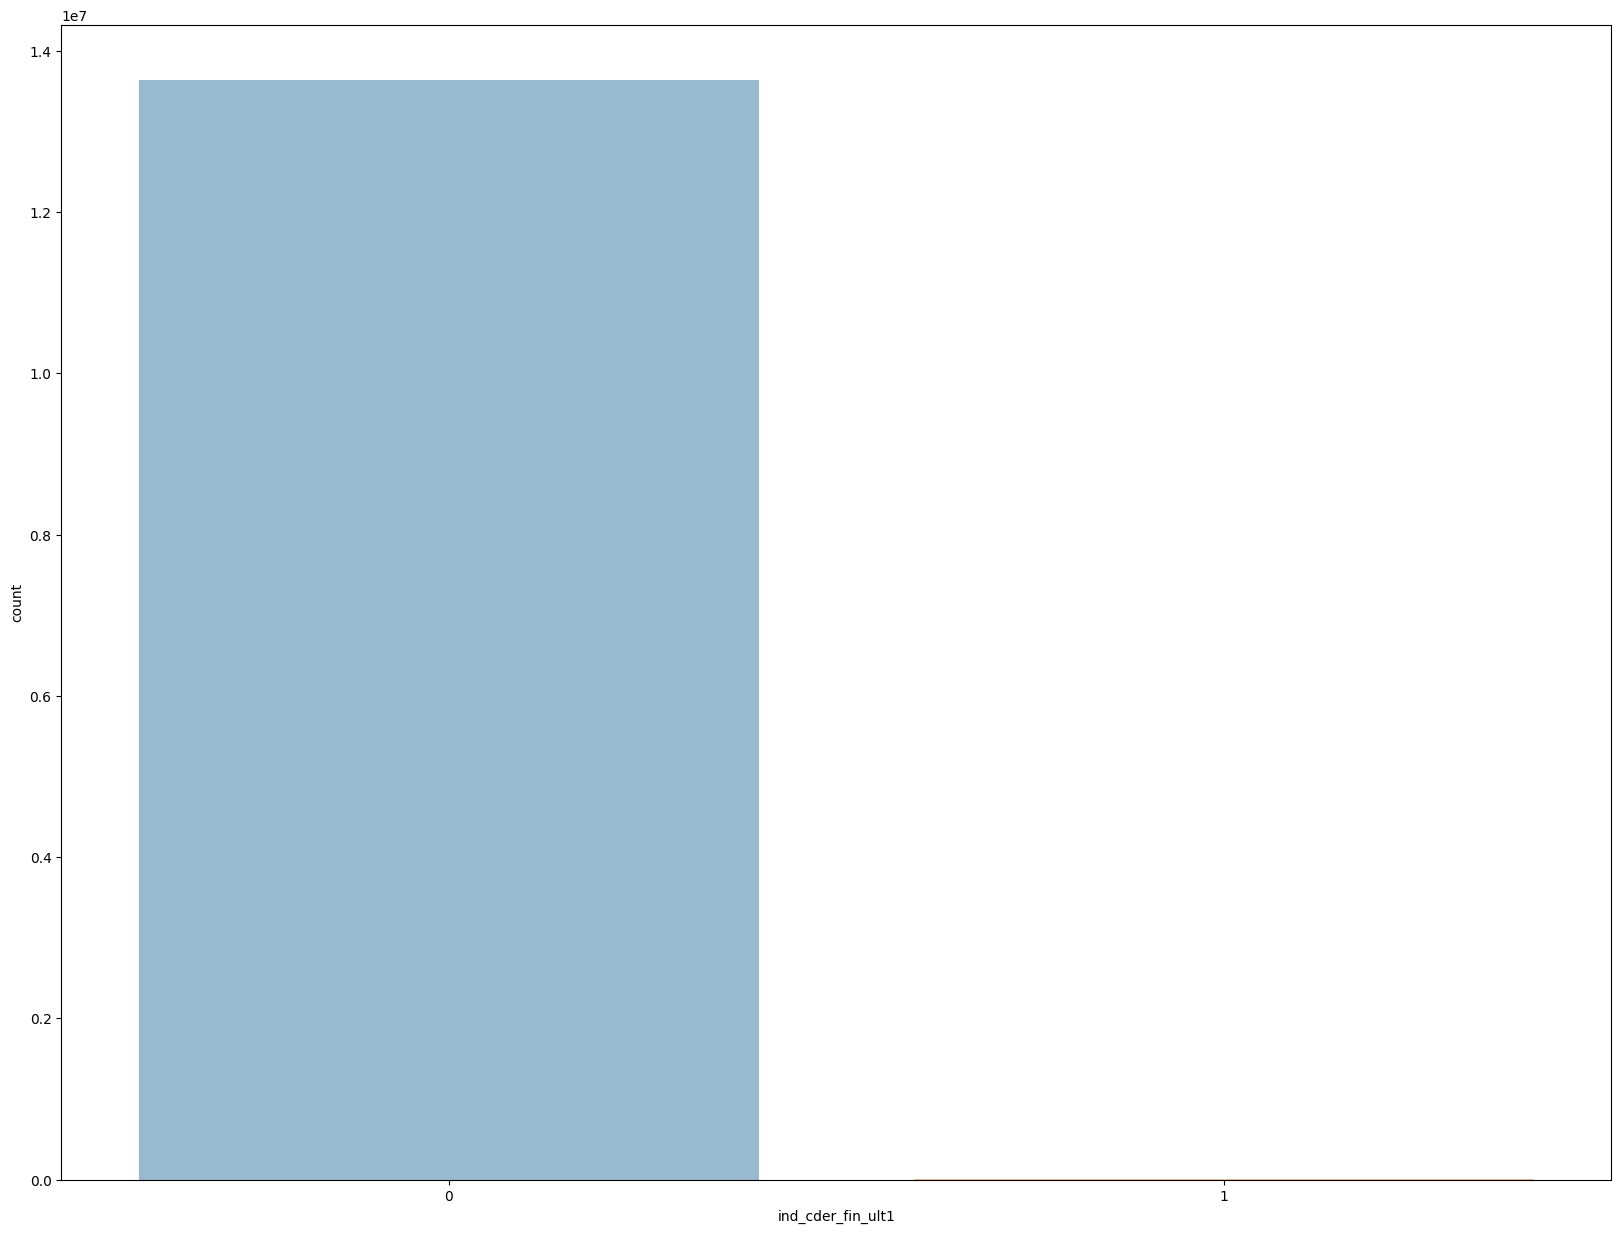

--------------------------------------------------
col :  ind_cno_fin_ult1


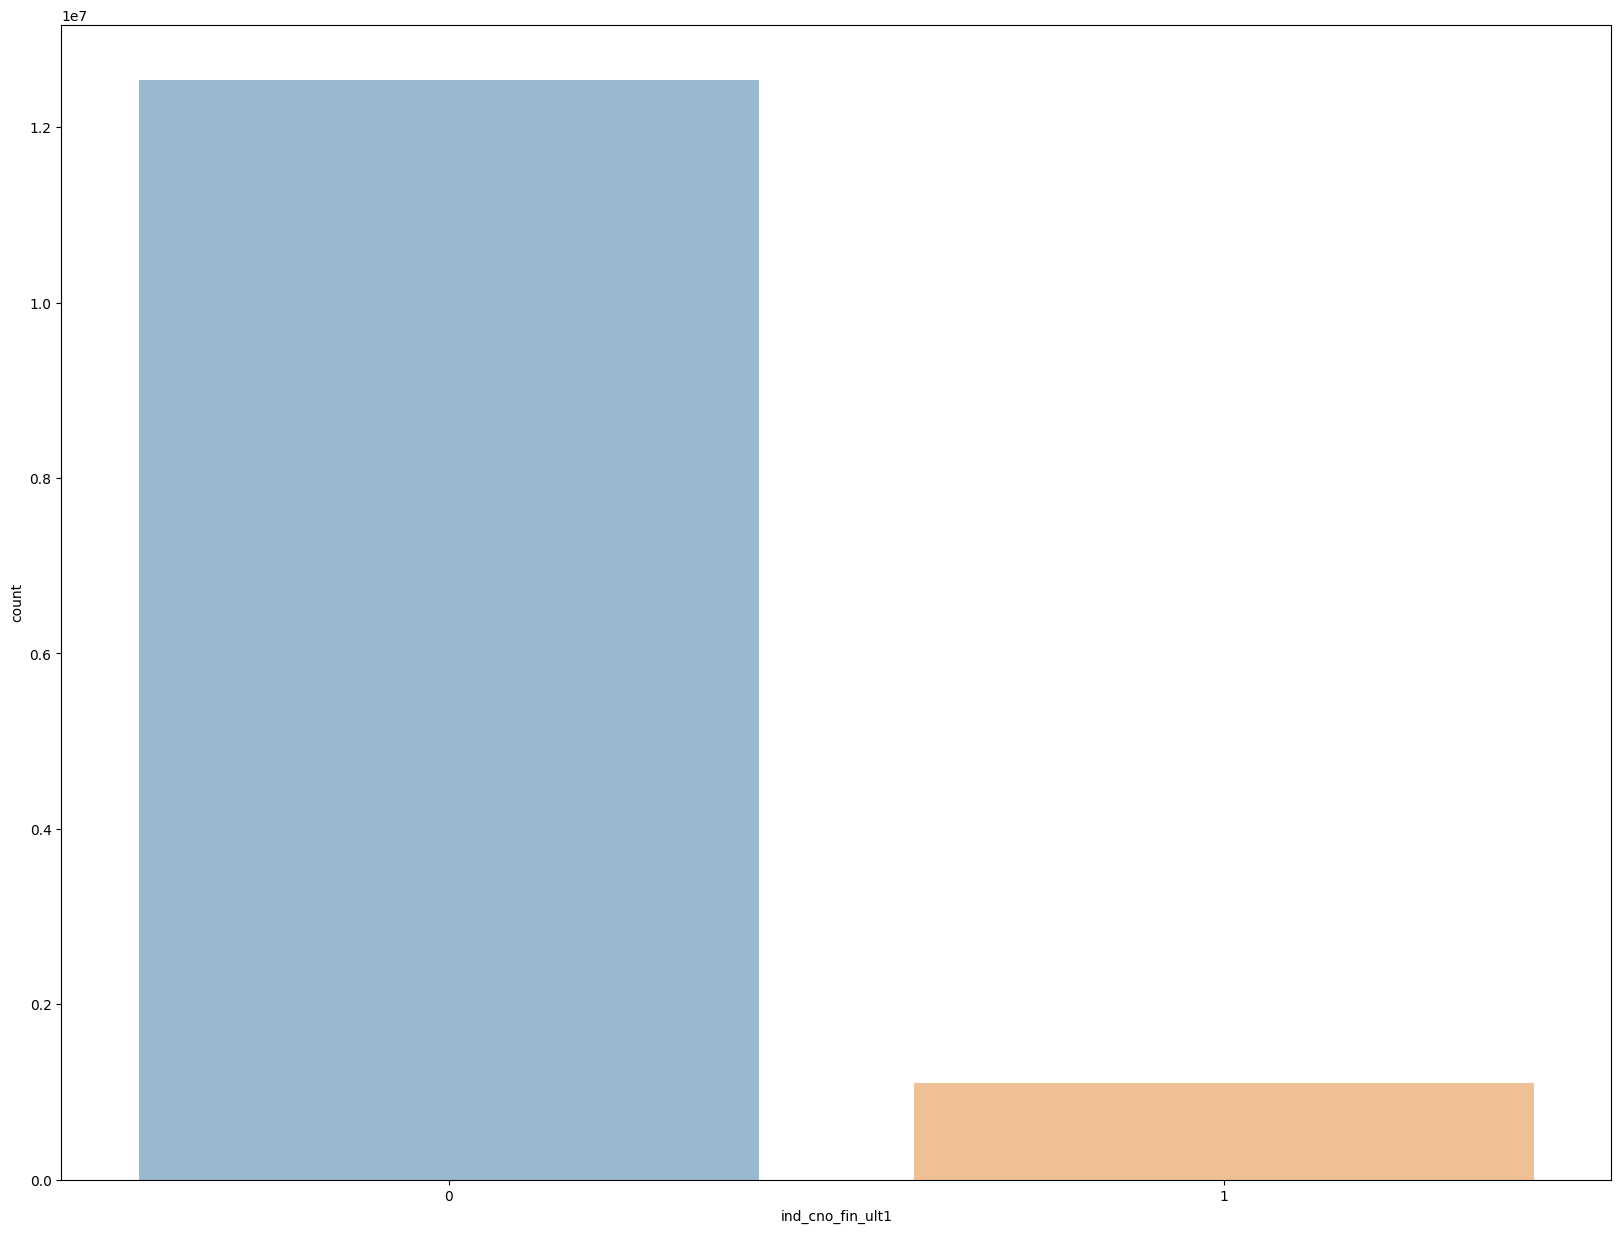

--------------------------------------------------
col :  ind_ctju_fin_ult1


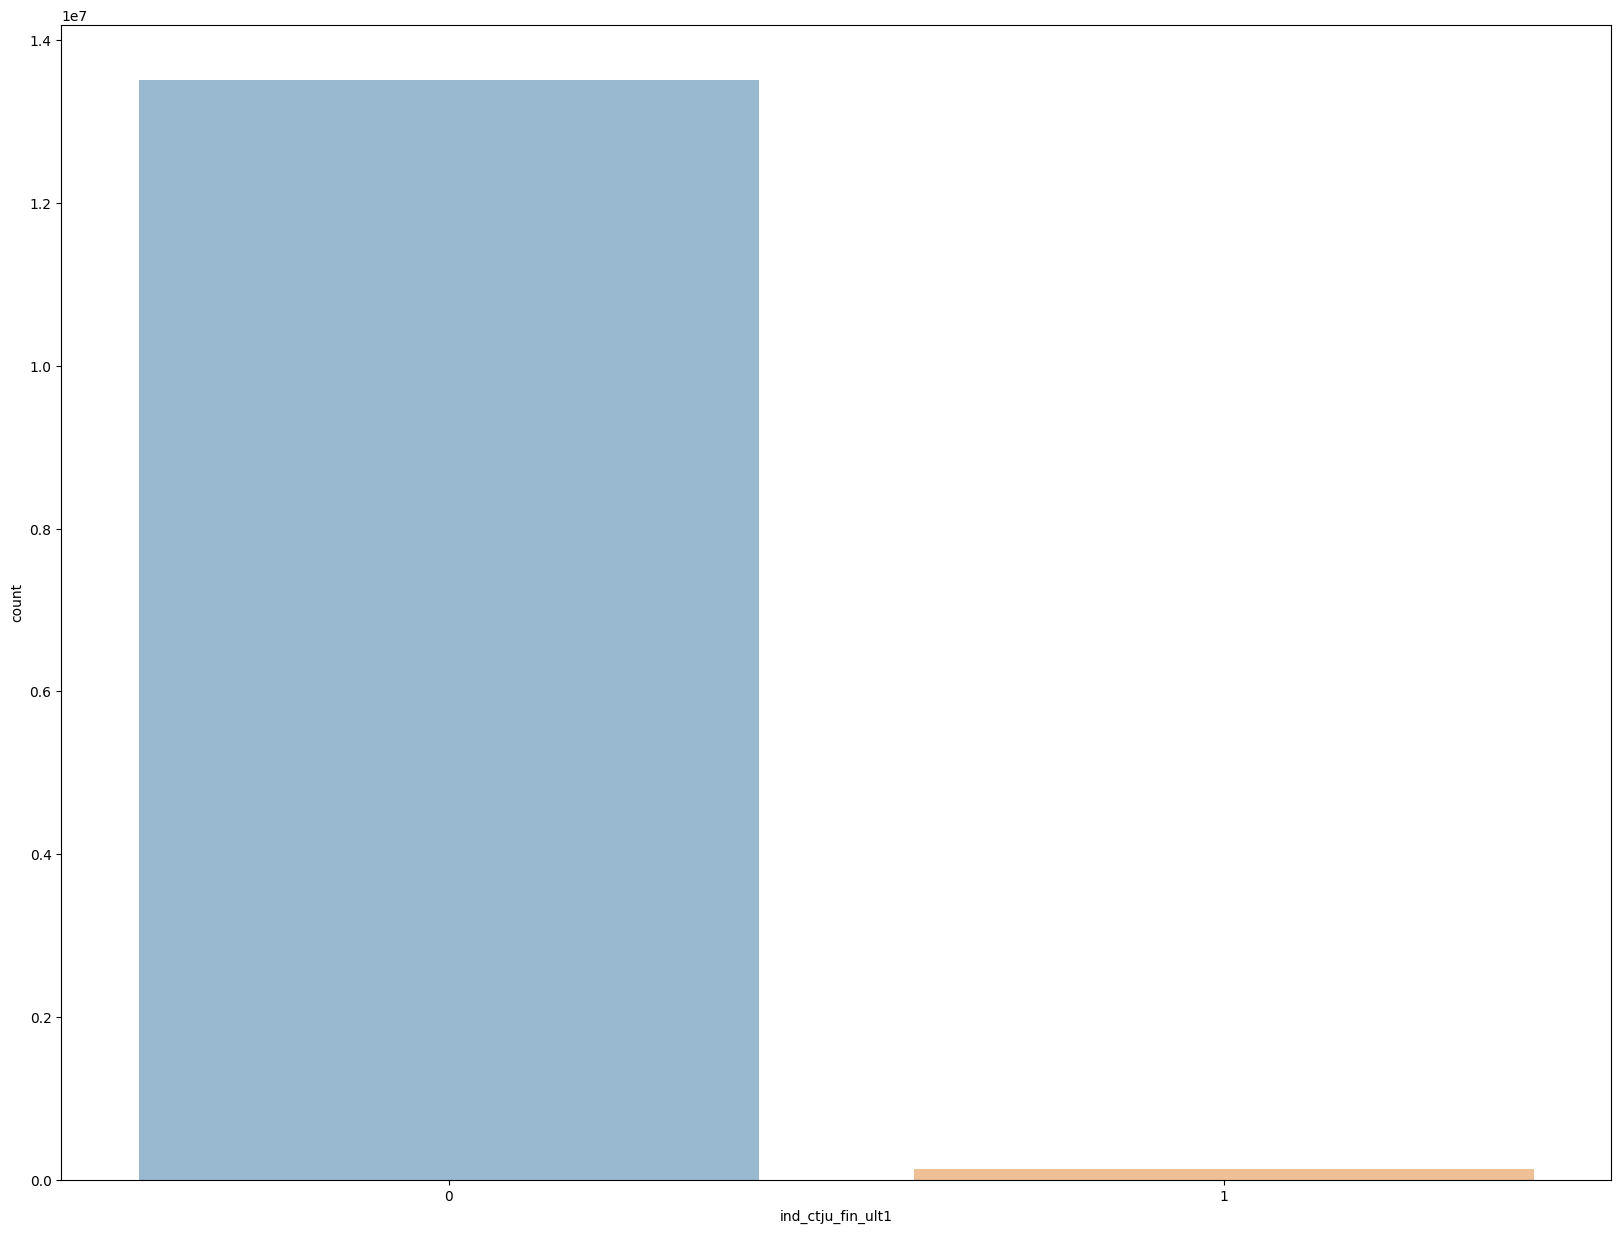

--------------------------------------------------
col :  ind_ctma_fin_ult1


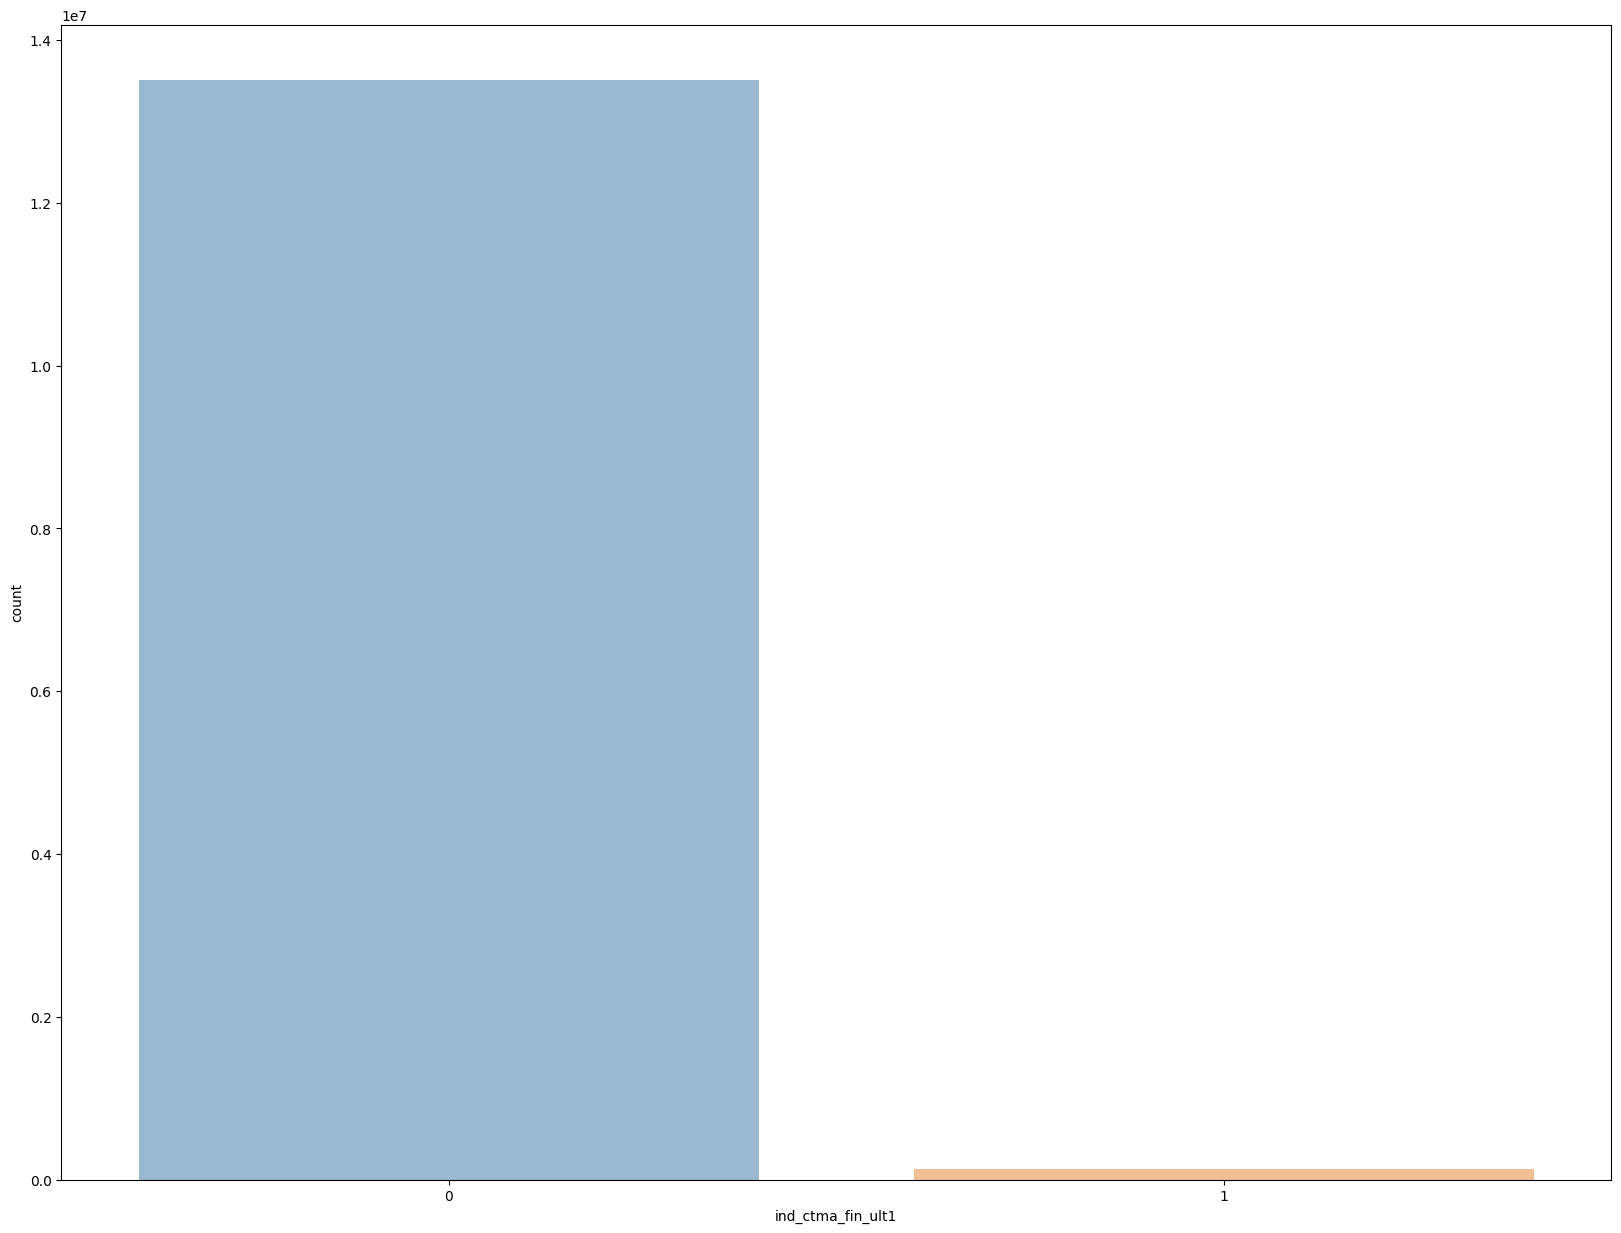

--------------------------------------------------
col :  ind_ctop_fin_ult1


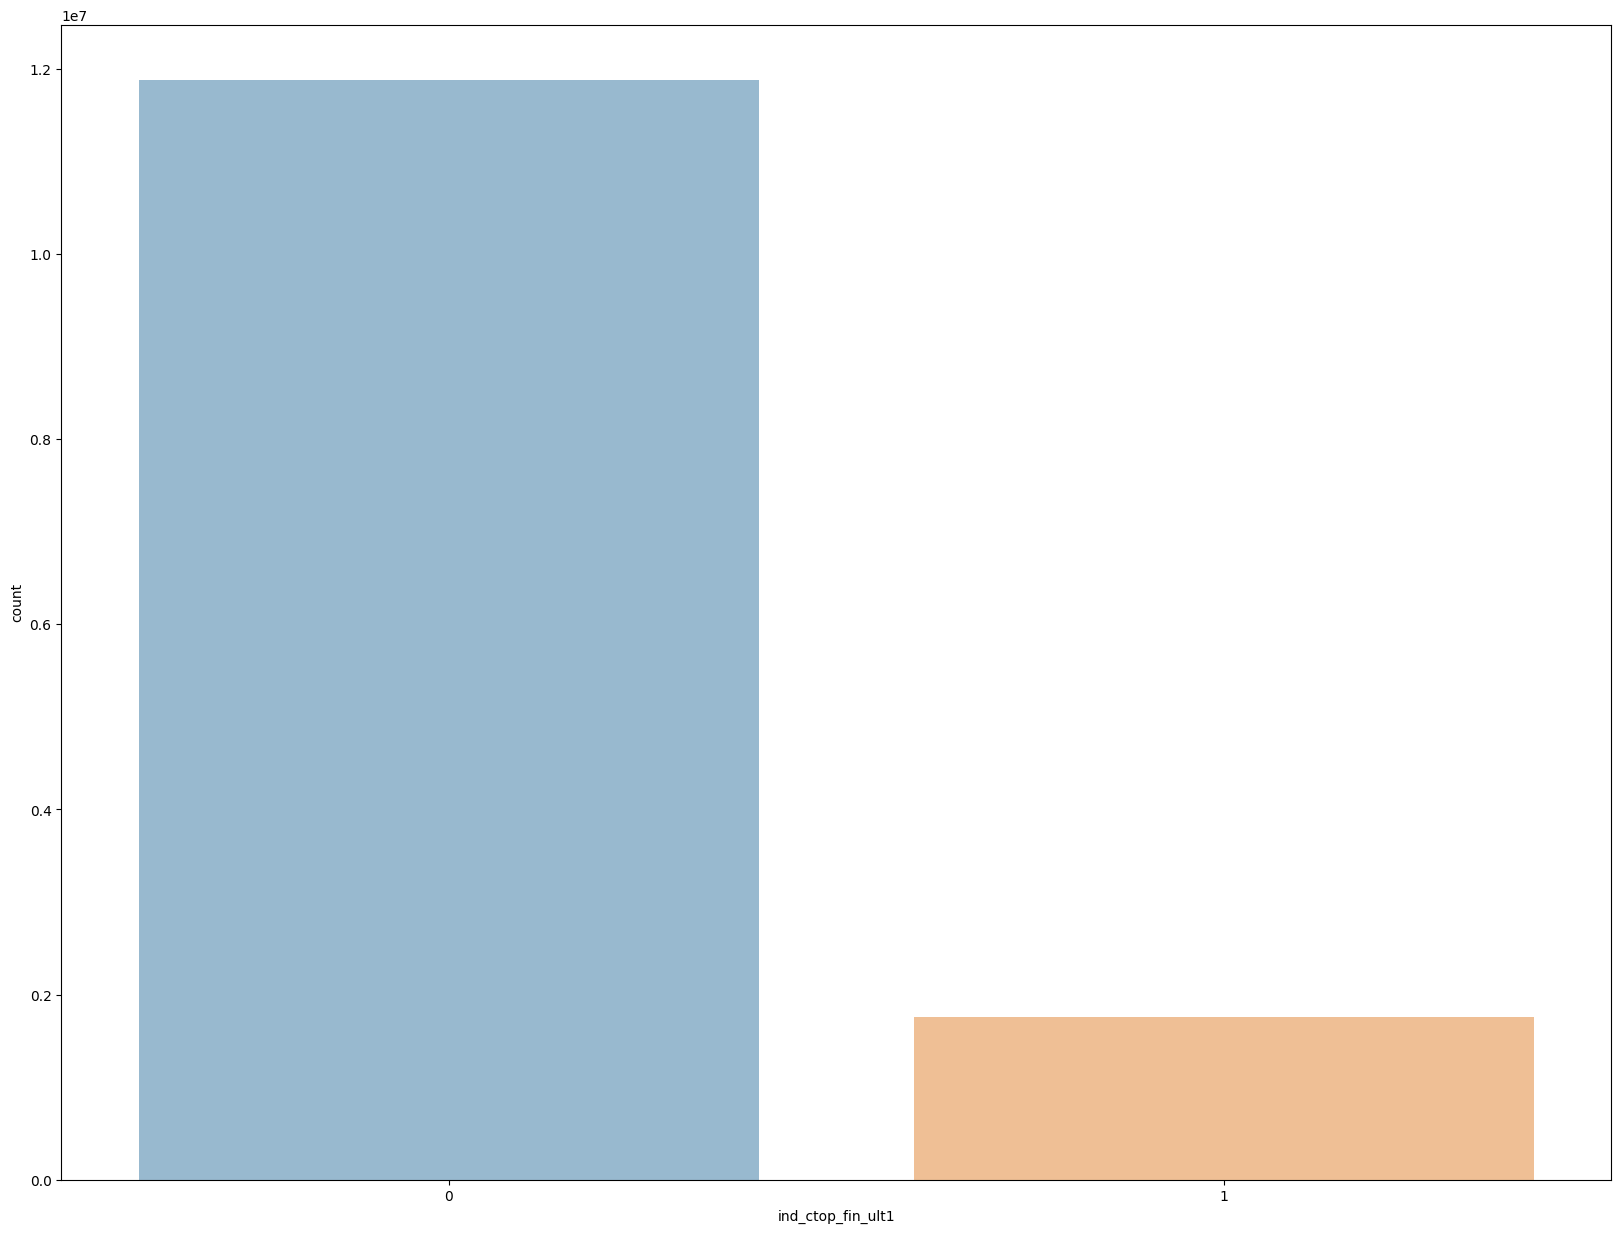

--------------------------------------------------
col :  ind_ctpp_fin_ult1


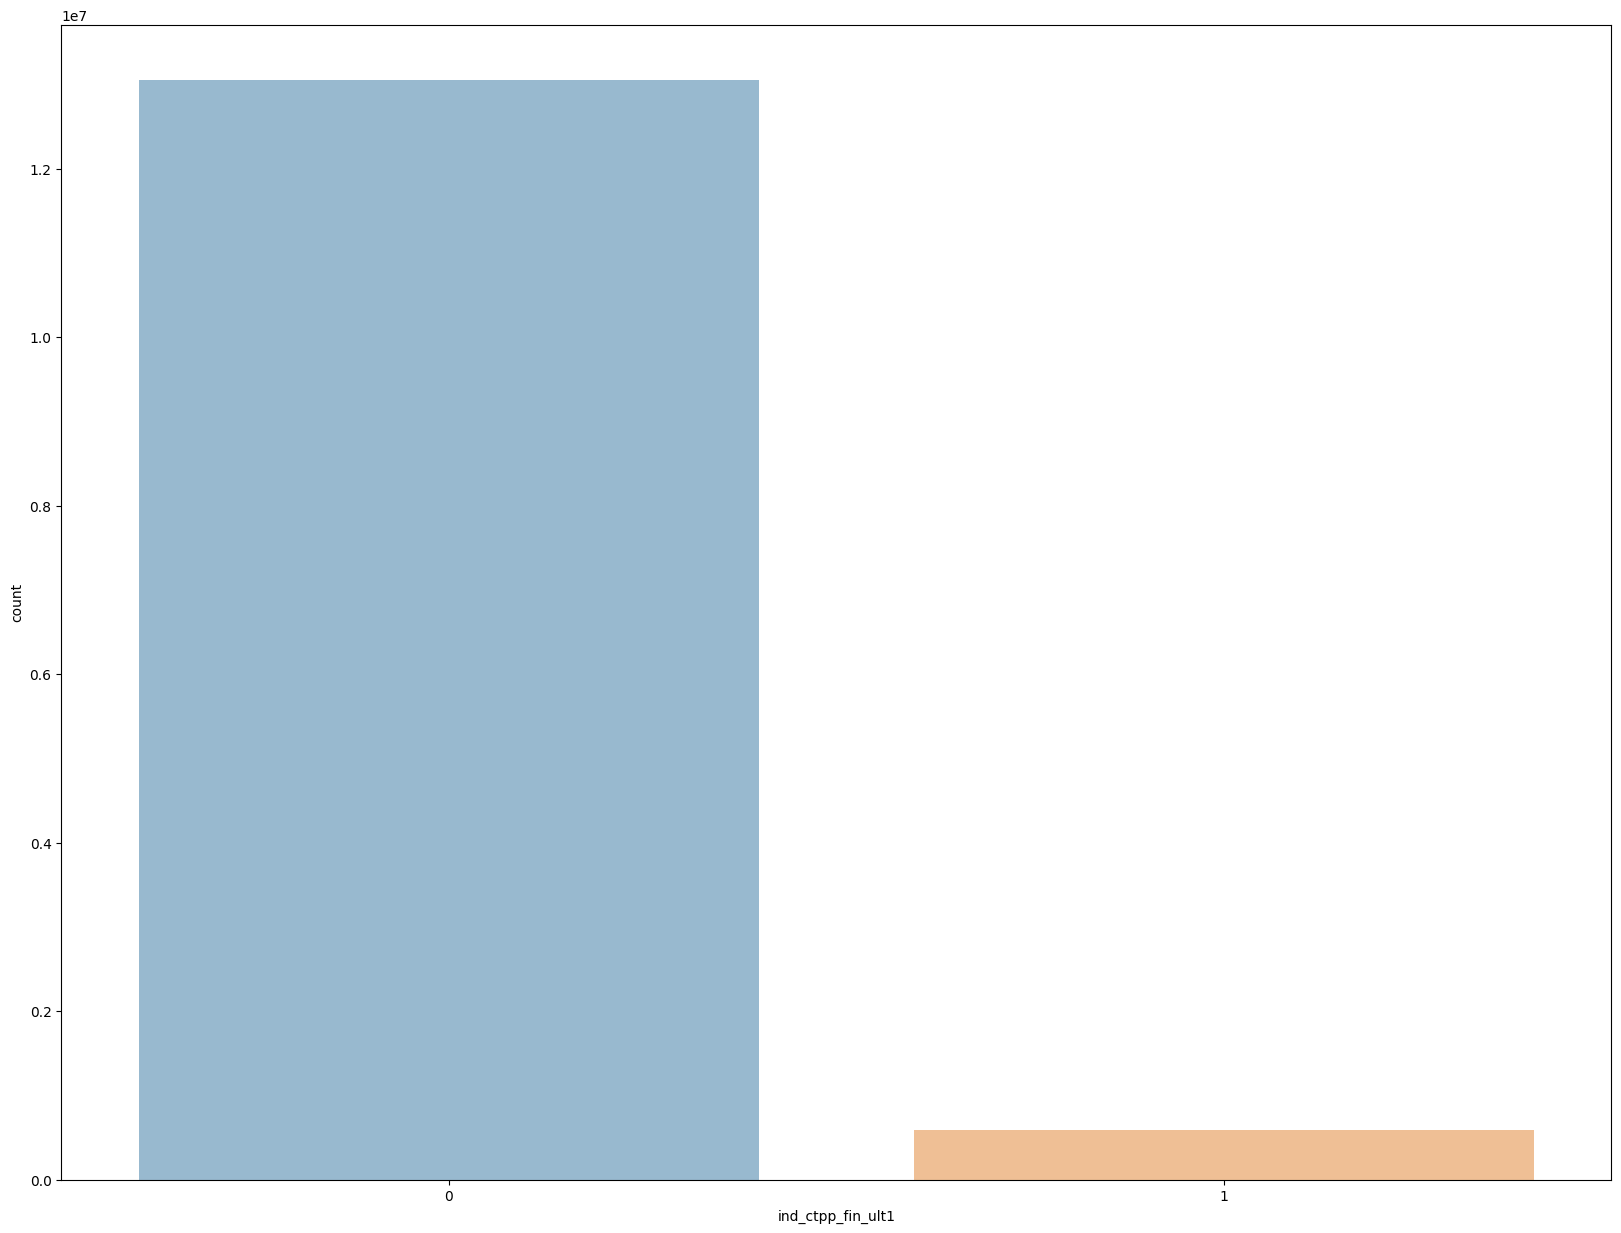

--------------------------------------------------
col :  ind_deco_fin_ult1


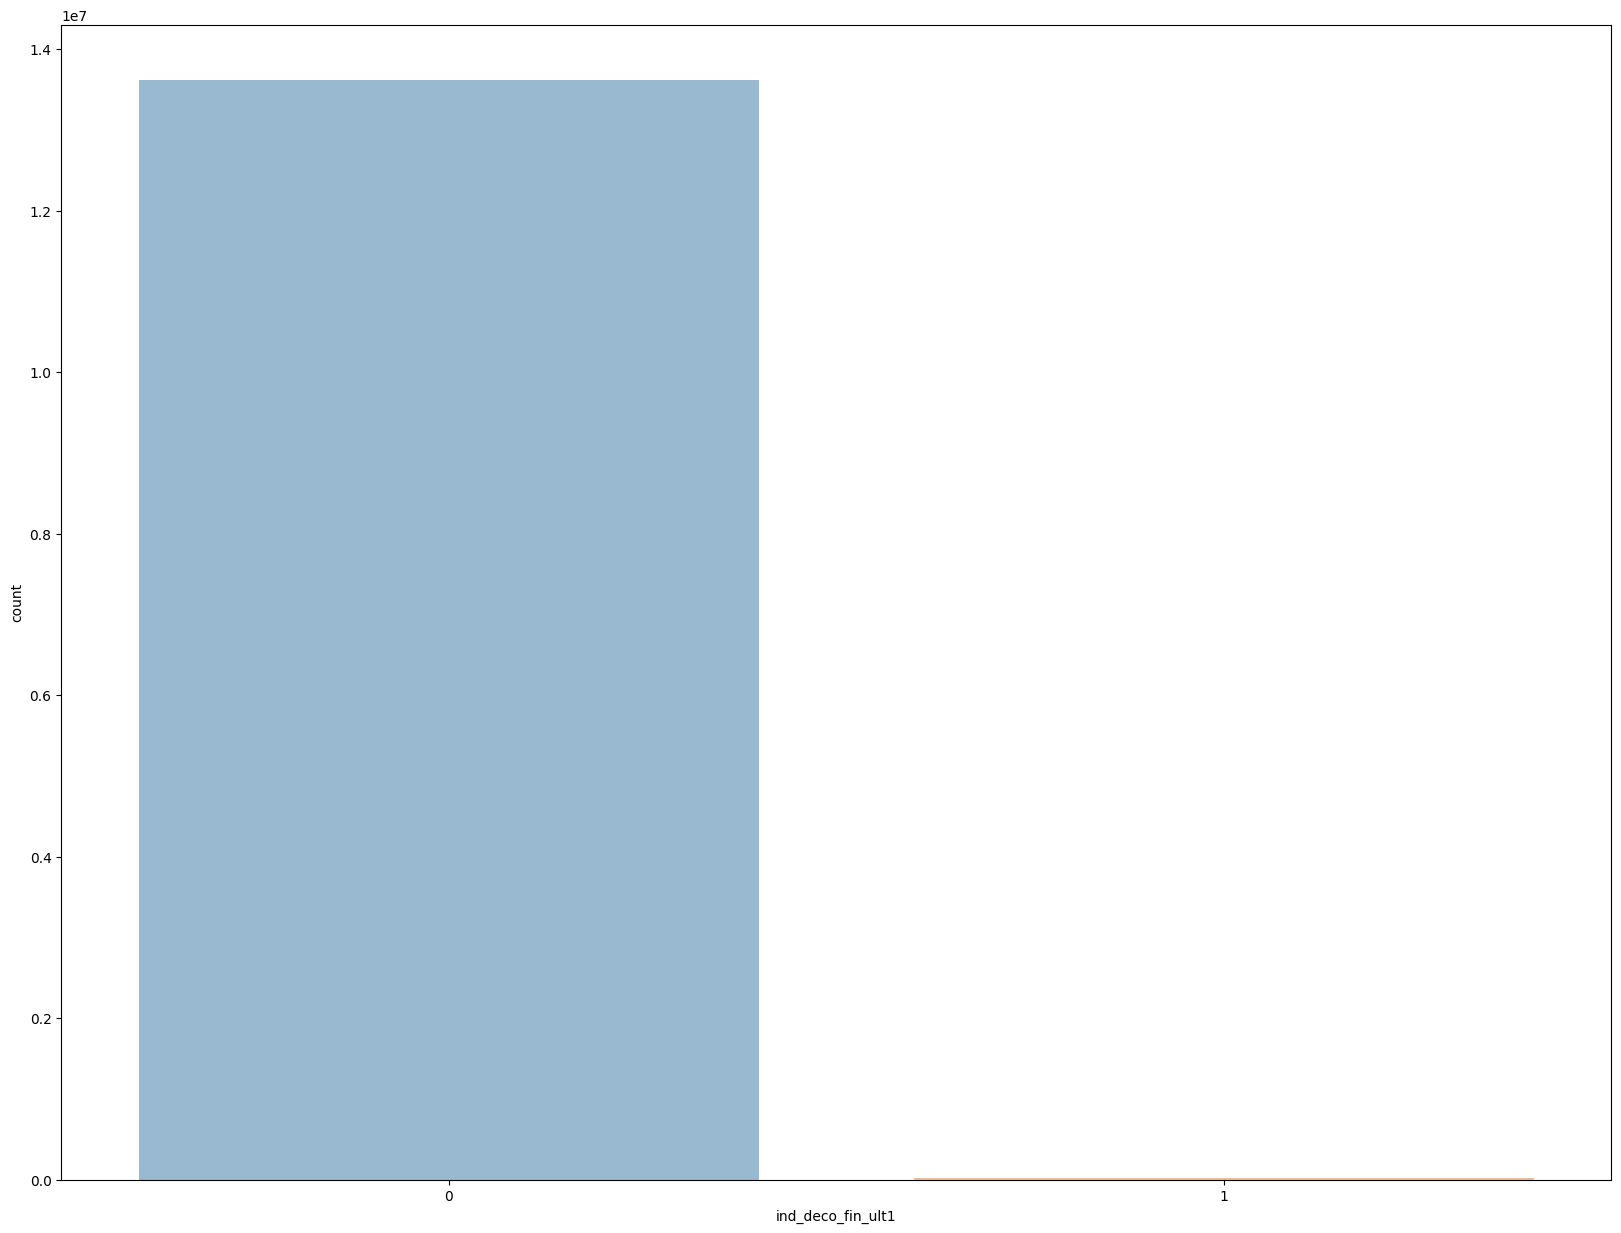

--------------------------------------------------
col :  ind_deme_fin_ult1


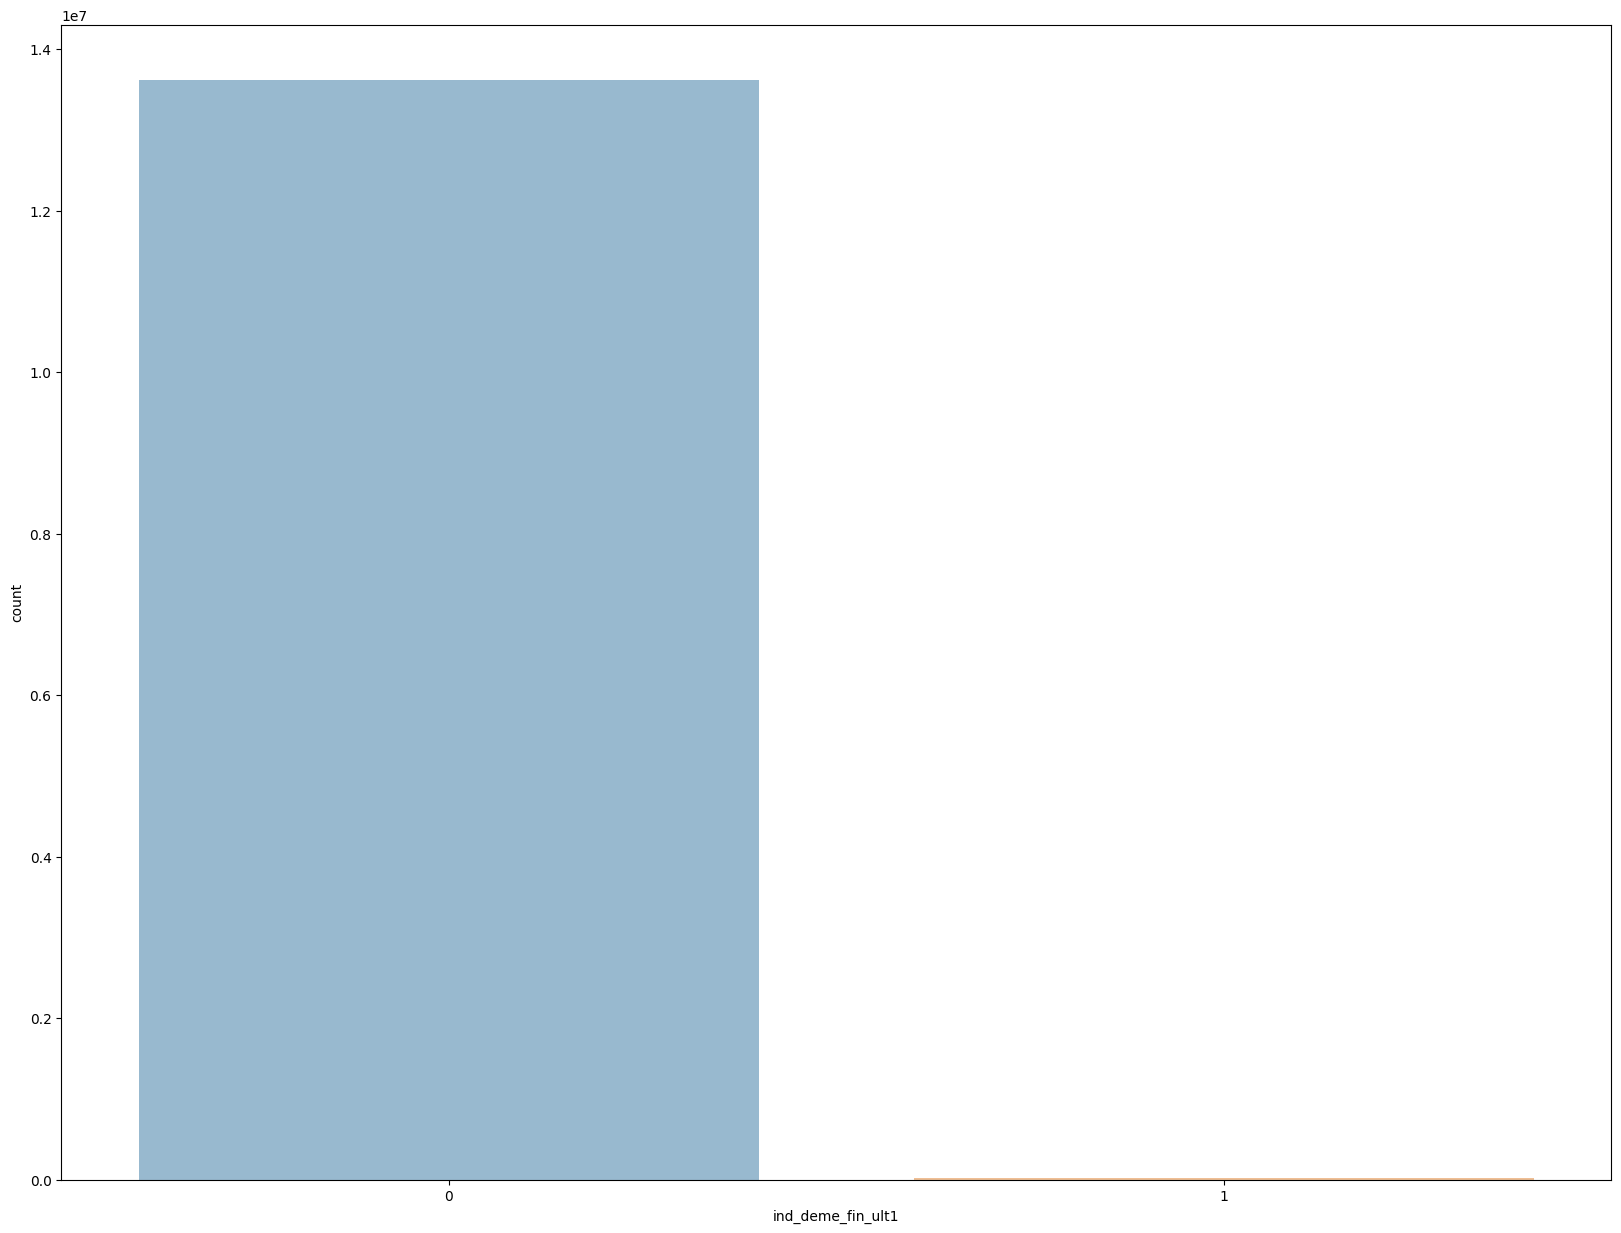

--------------------------------------------------
col :  ind_dela_fin_ult1


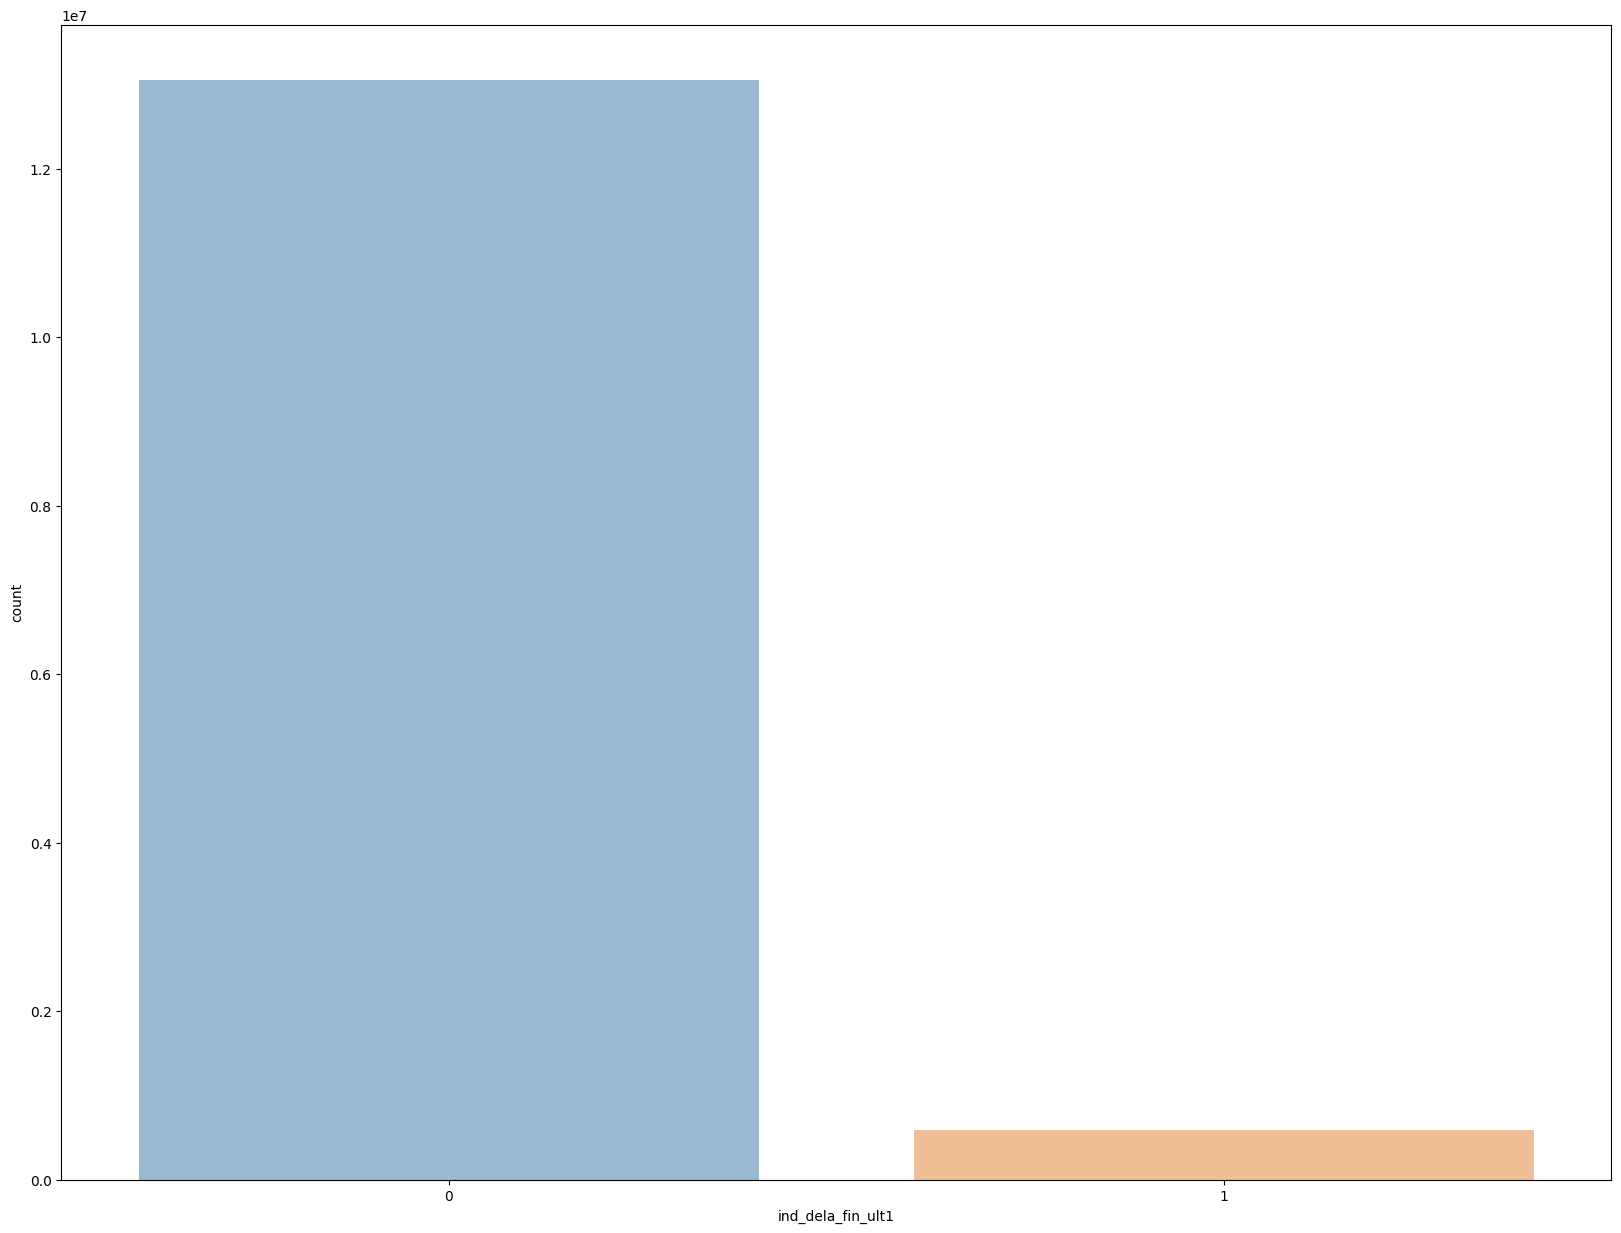

--------------------------------------------------
col :  ind_ecue_fin_ult1


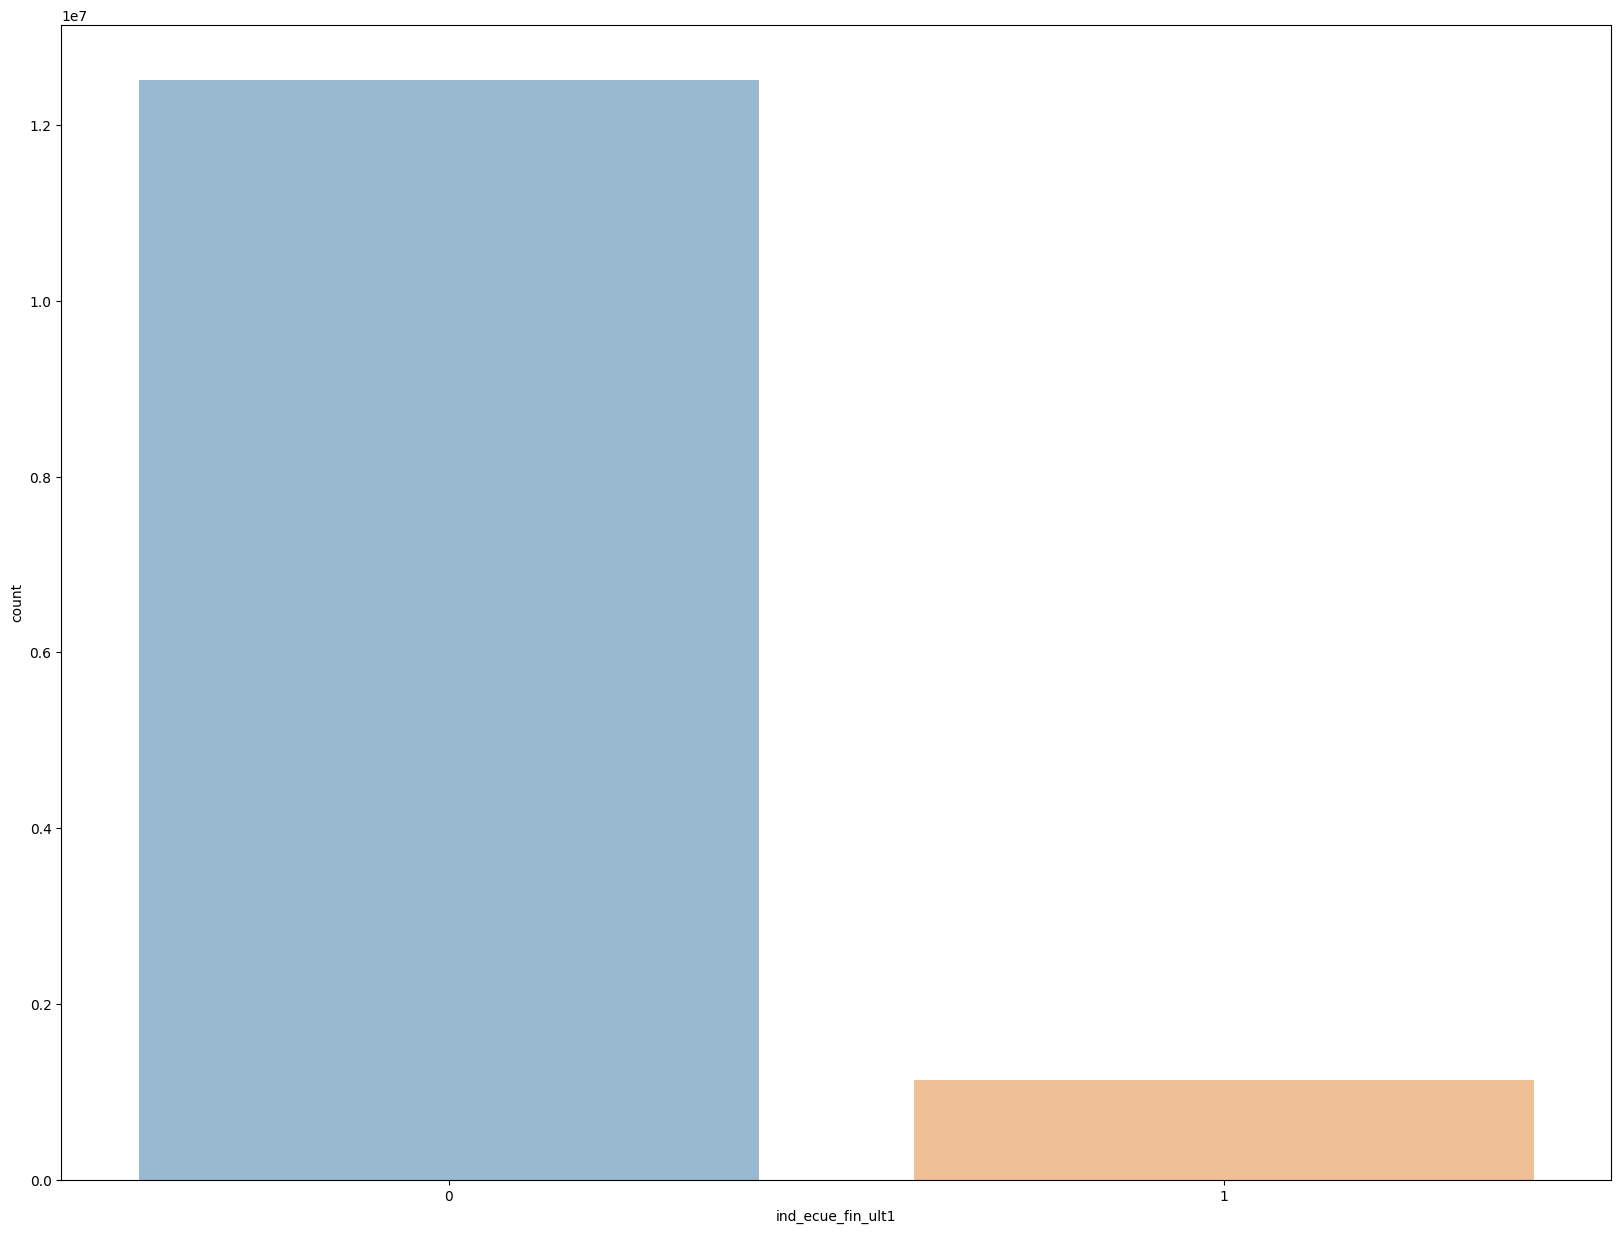

--------------------------------------------------
col :  ind_fond_fin_ult1


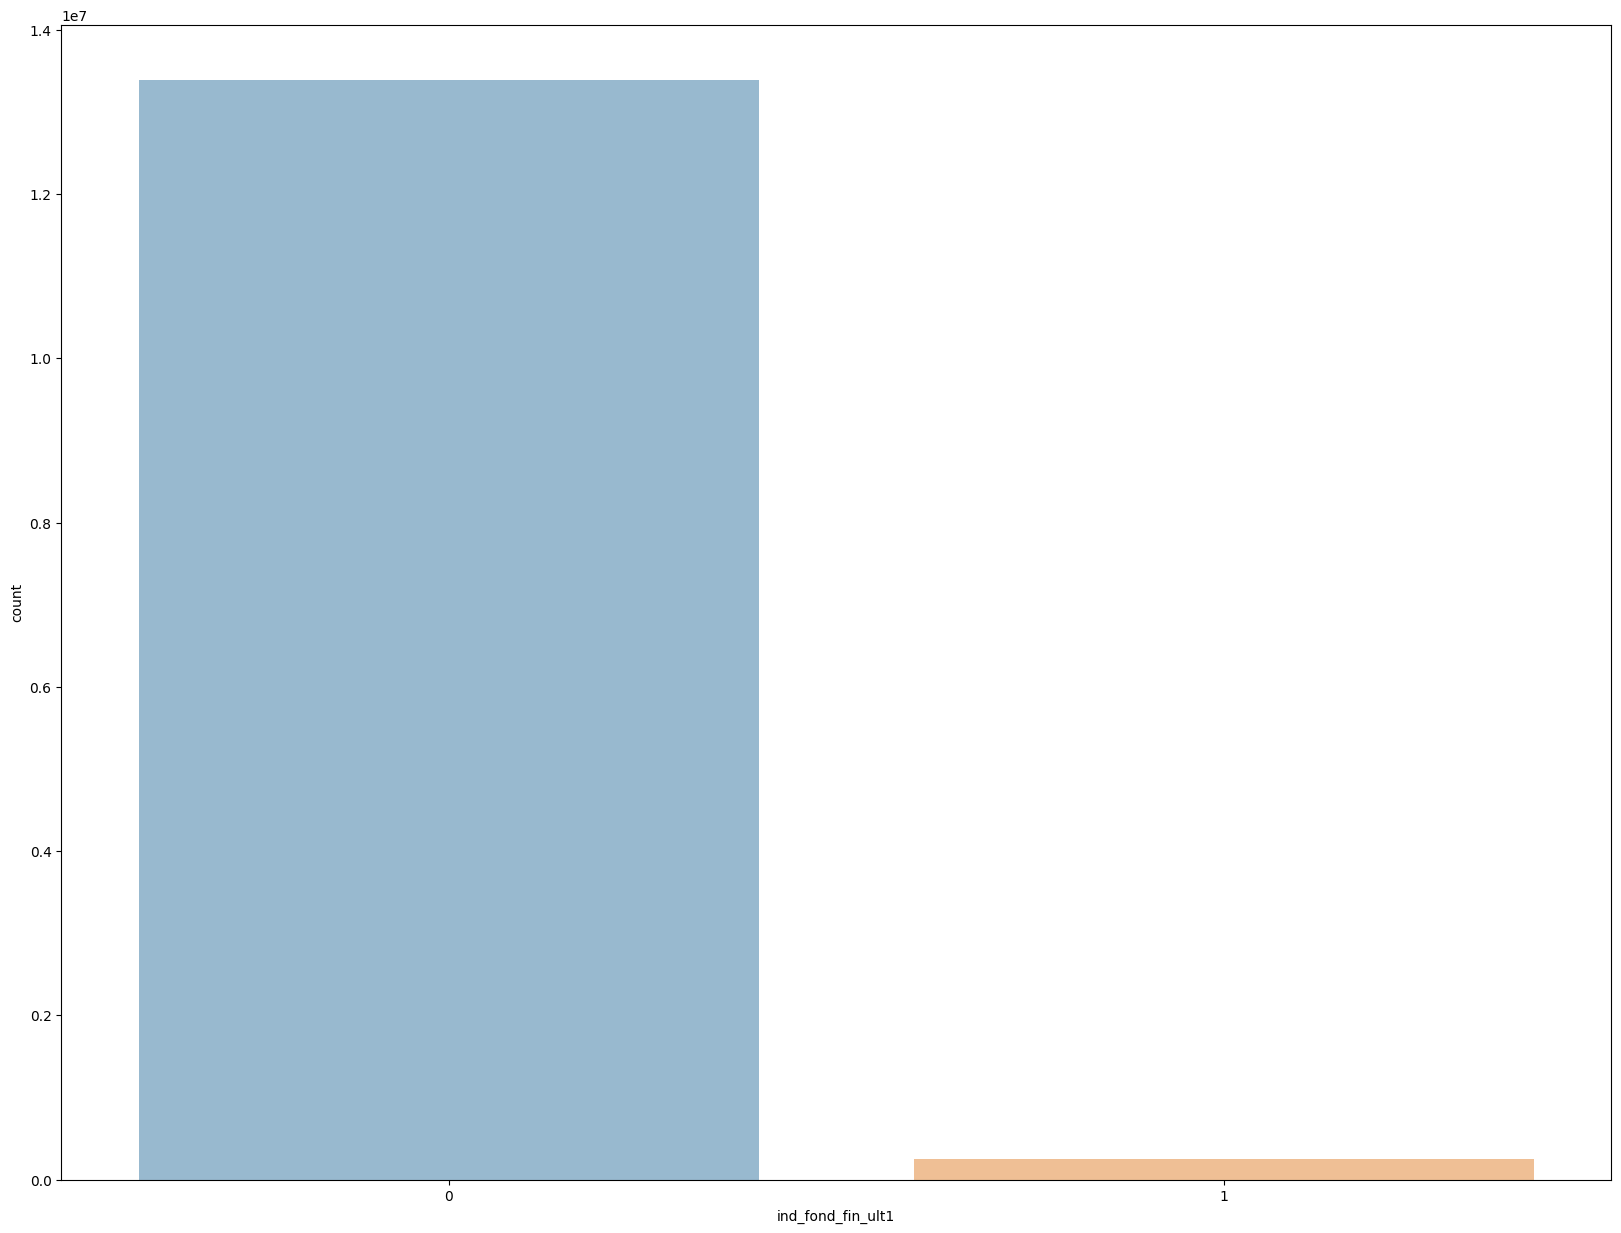

--------------------------------------------------
col :  ind_hip_fin_ult1


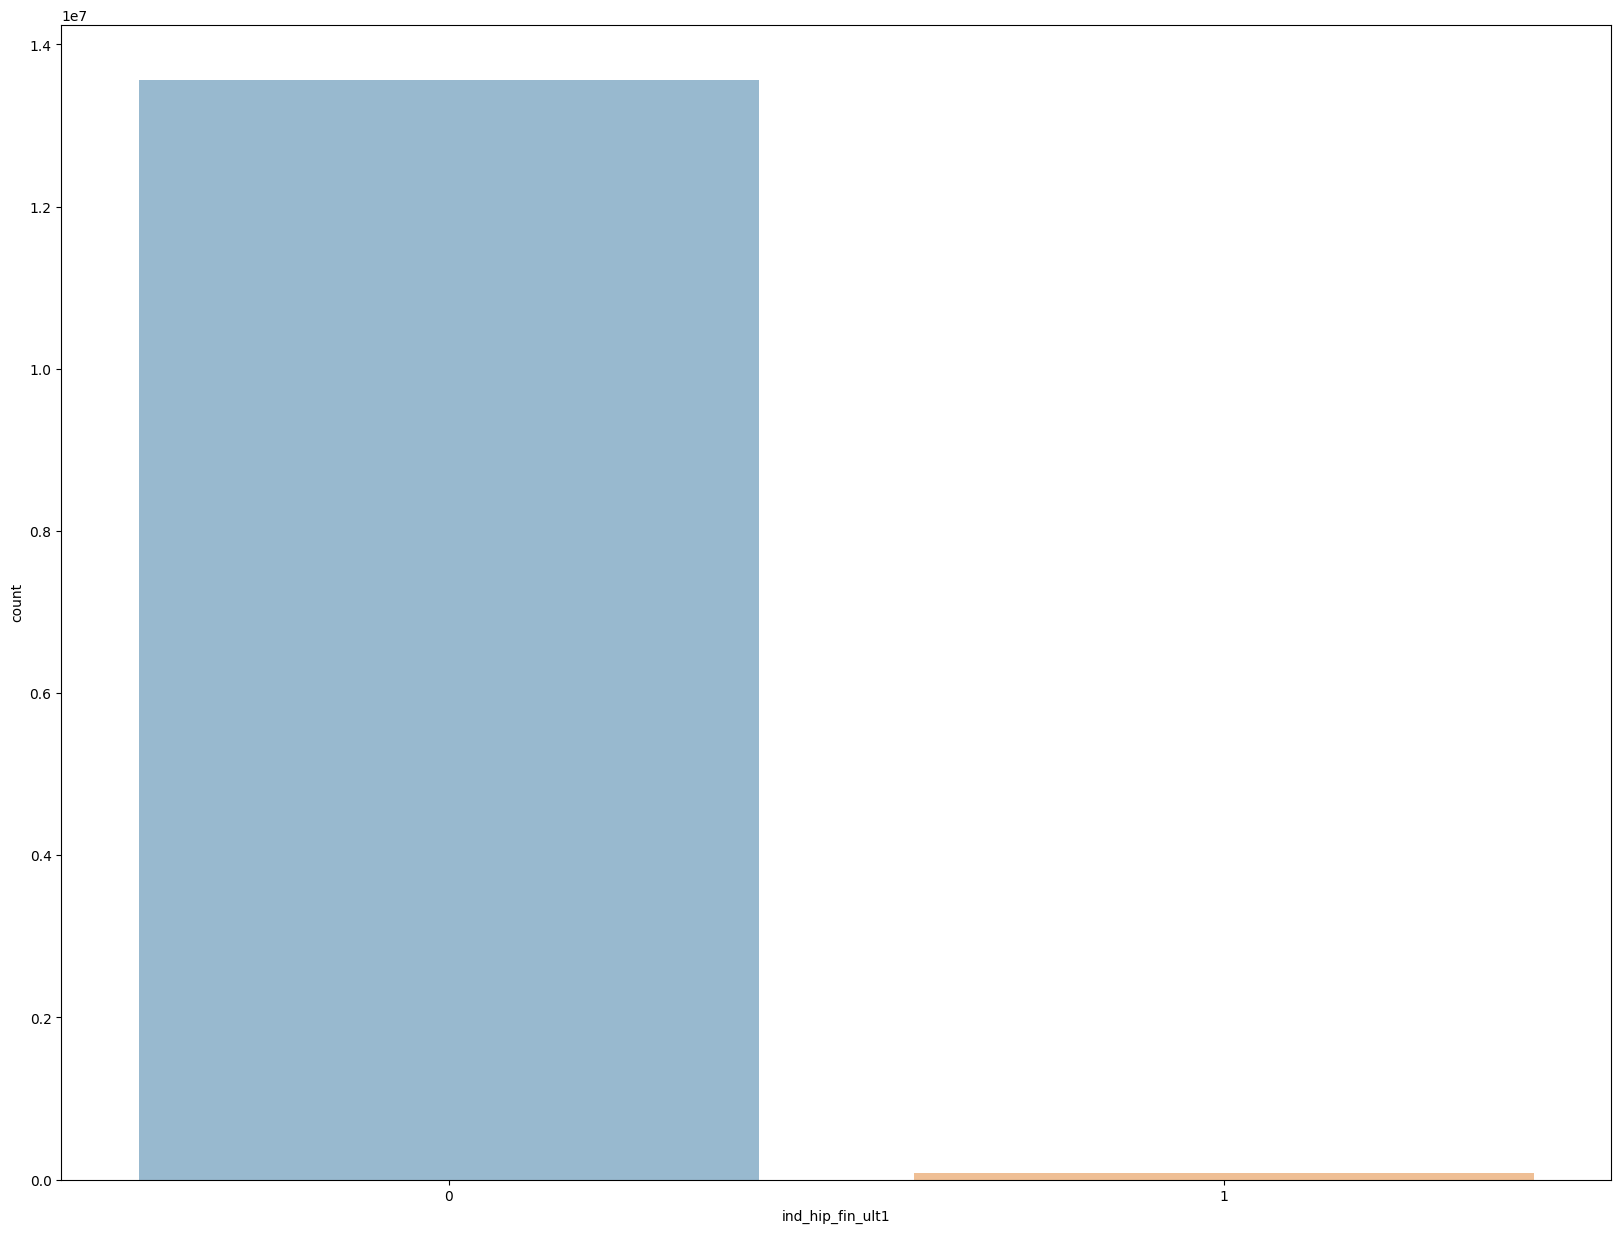

--------------------------------------------------
col :  ind_plan_fin_ult1


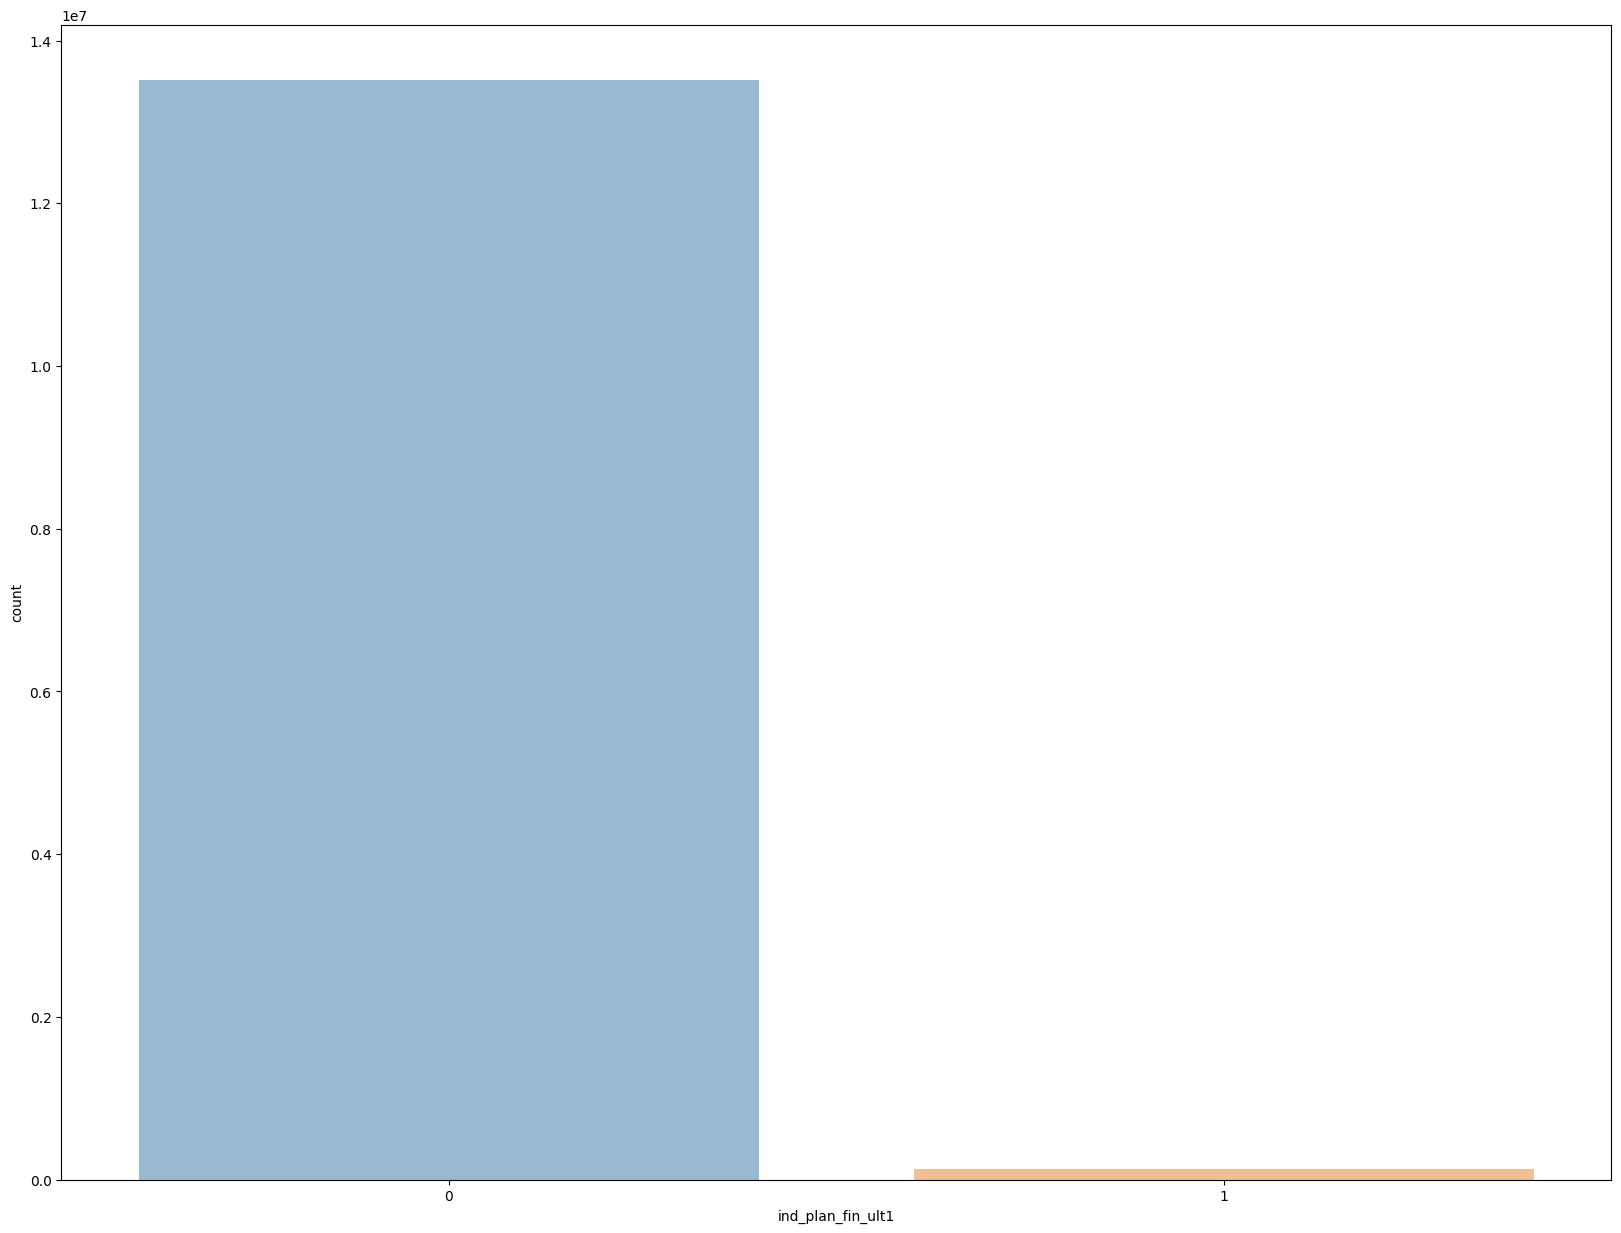

--------------------------------------------------
col :  ind_pres_fin_ult1


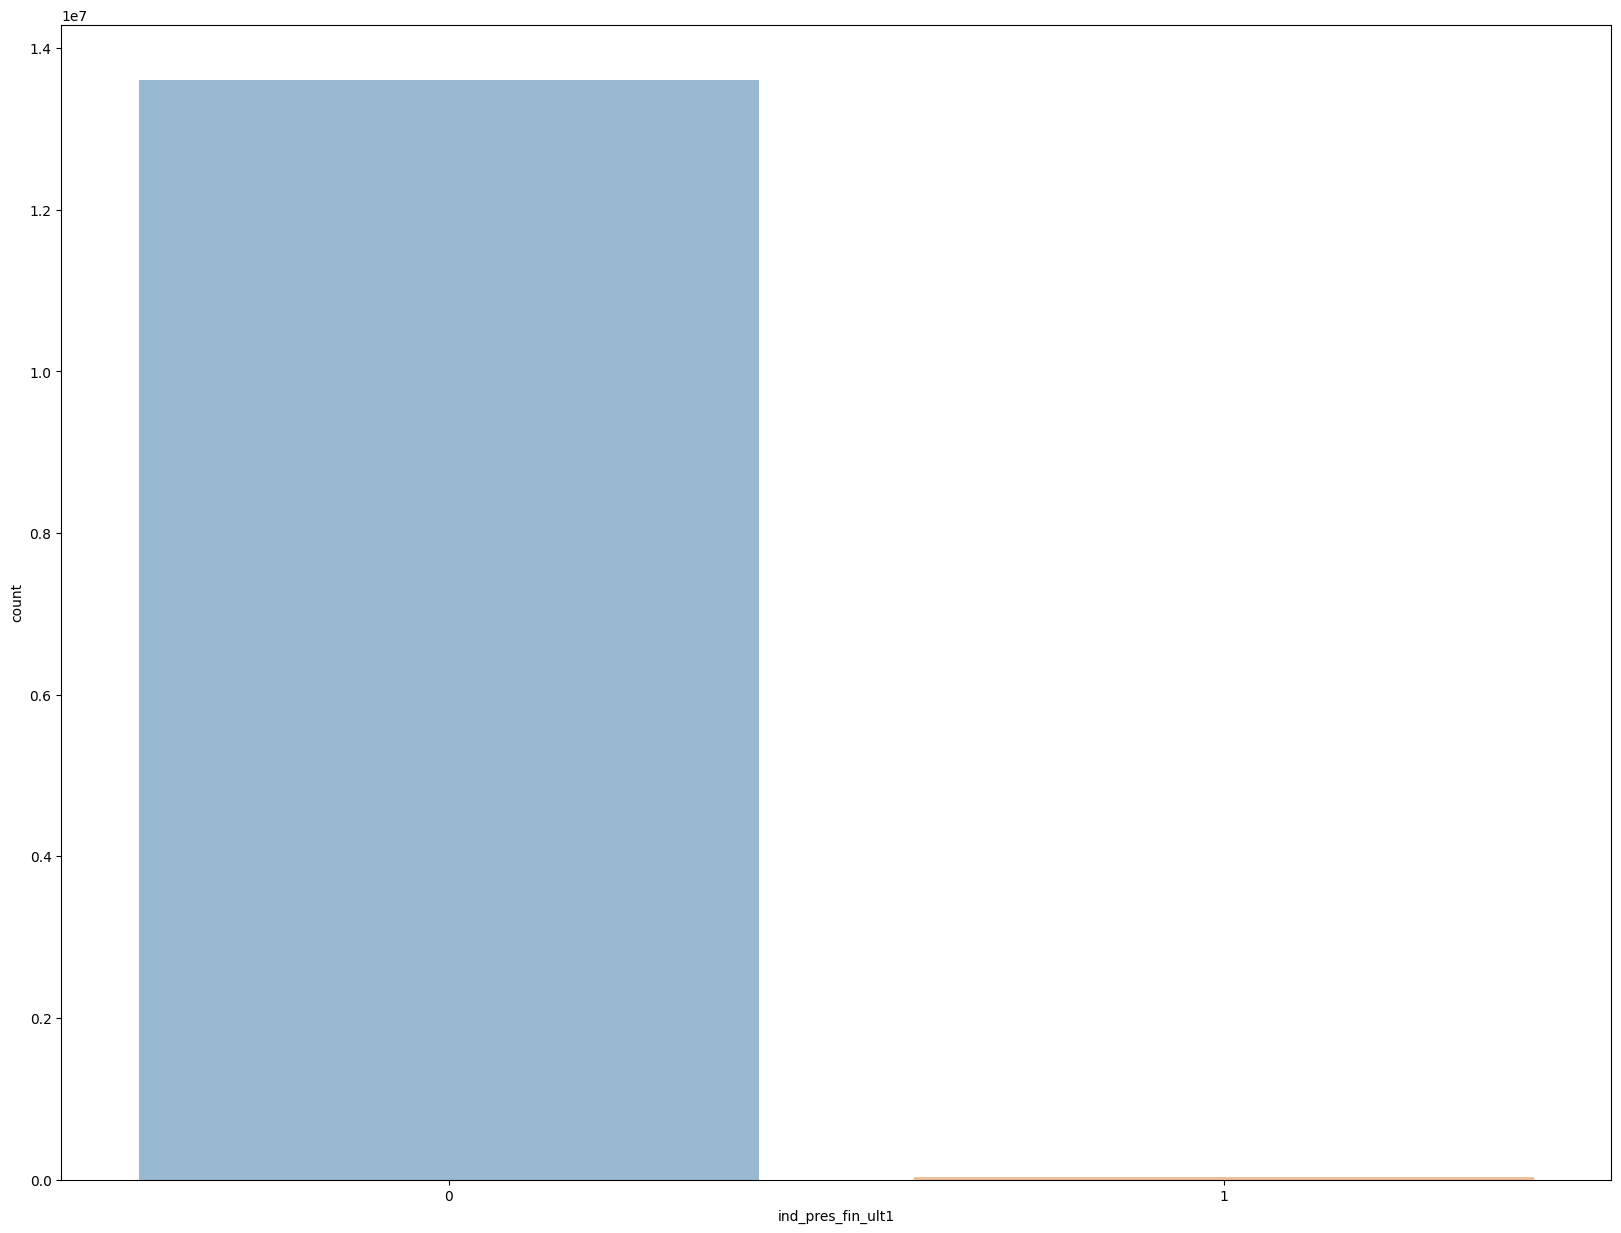

--------------------------------------------------
col :  ind_reca_fin_ult1


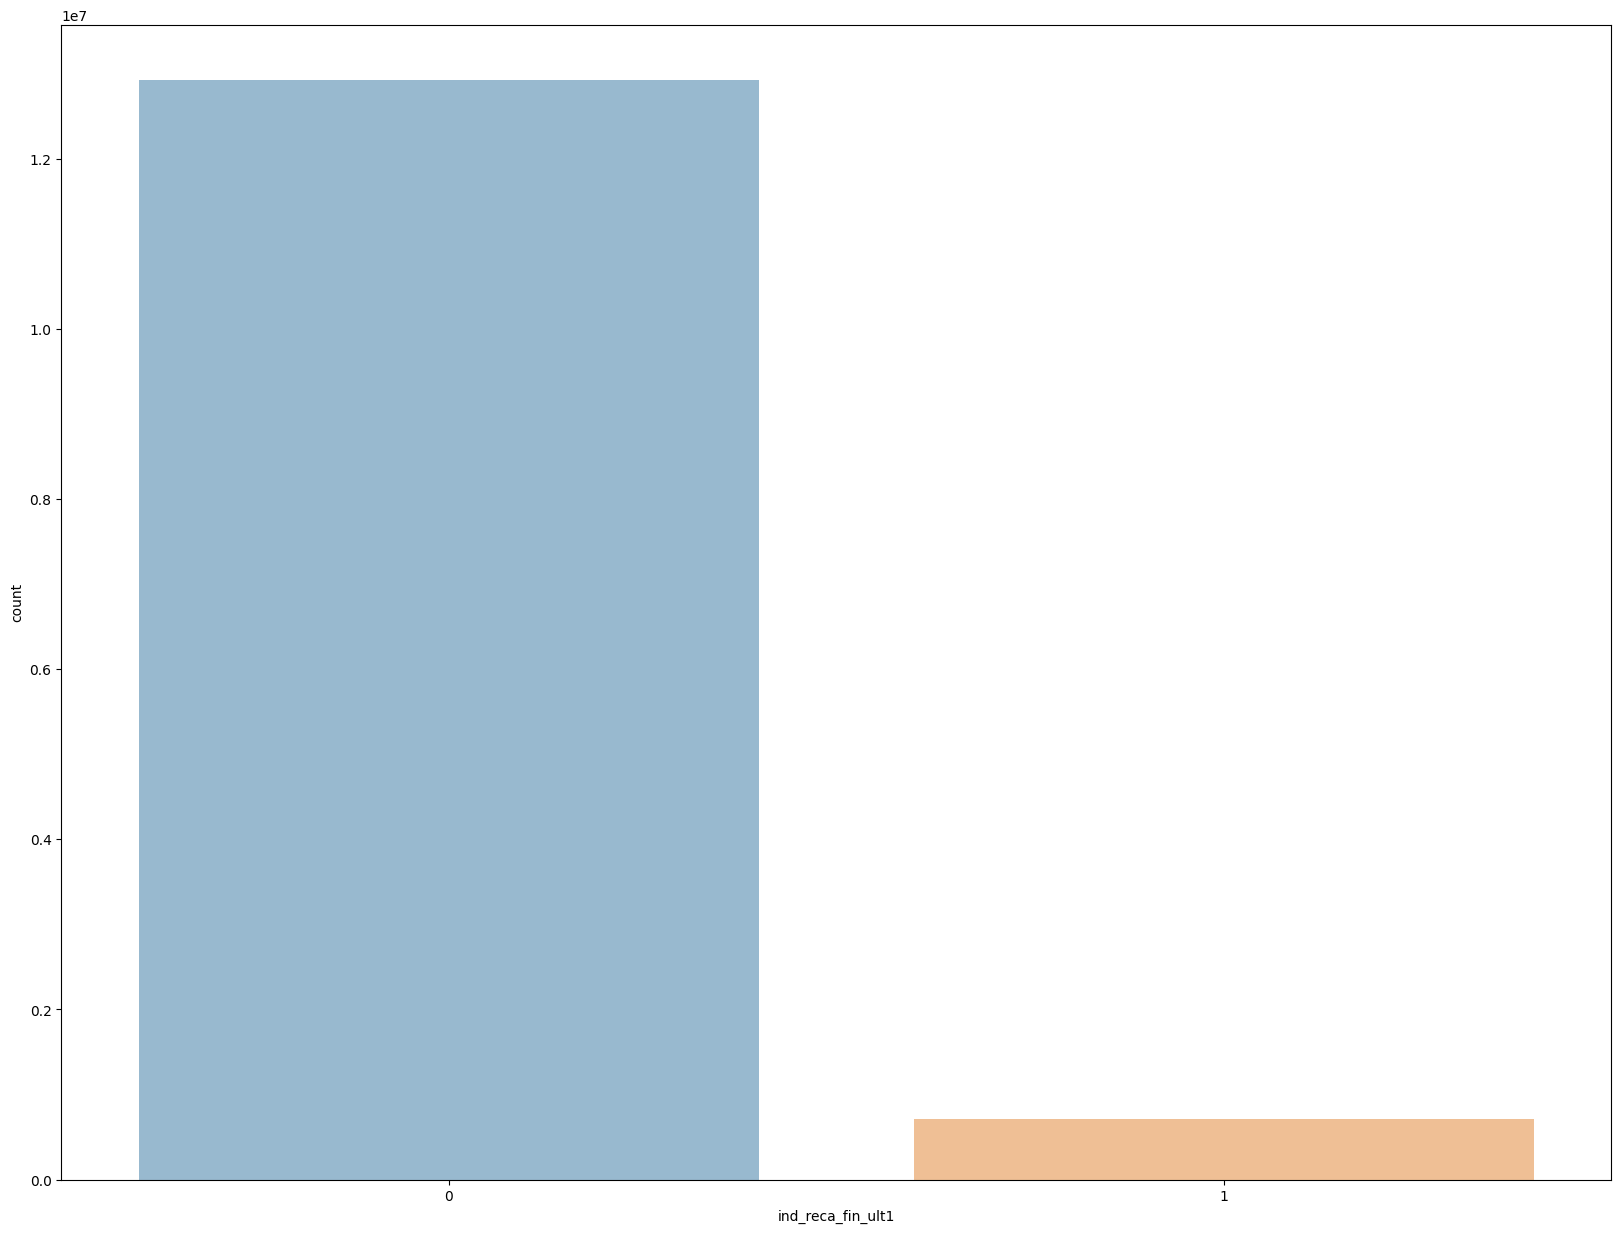

--------------------------------------------------
col :  ind_tjcr_fin_ult1


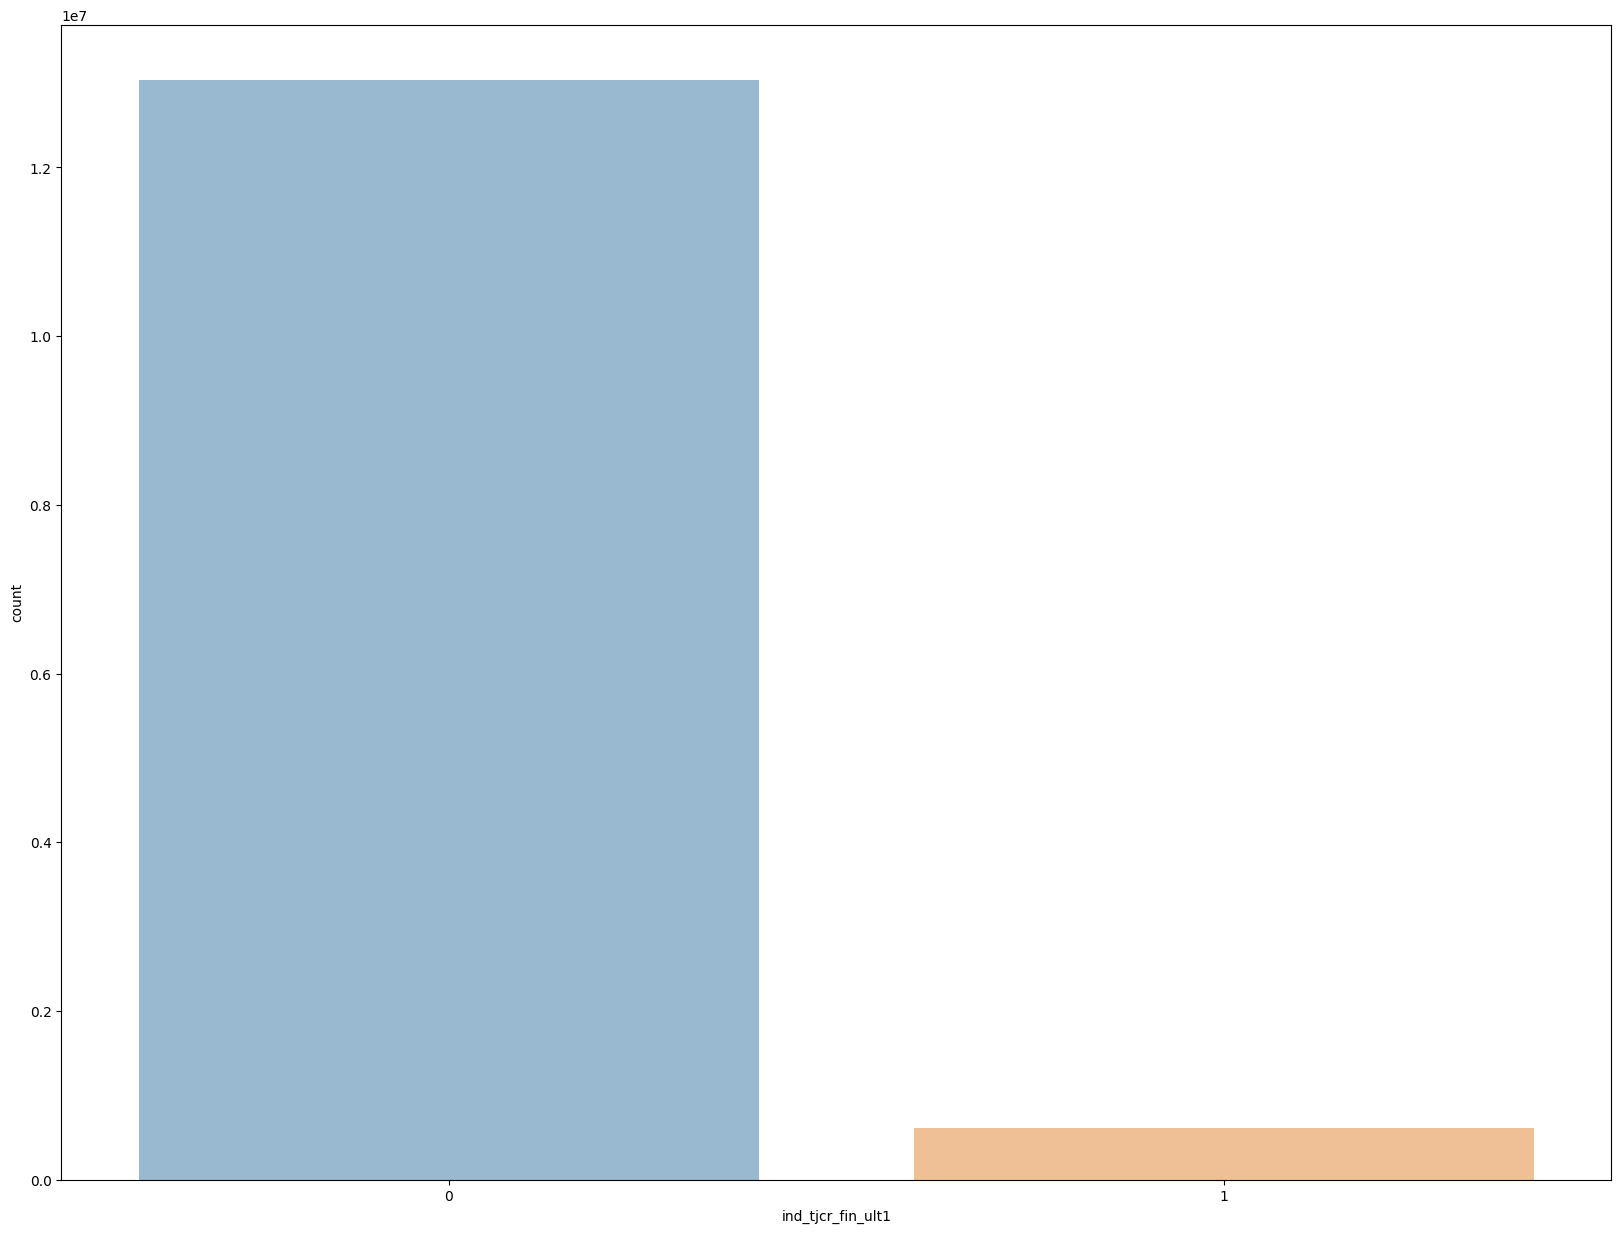

--------------------------------------------------
col :  ind_valo_fin_ult1


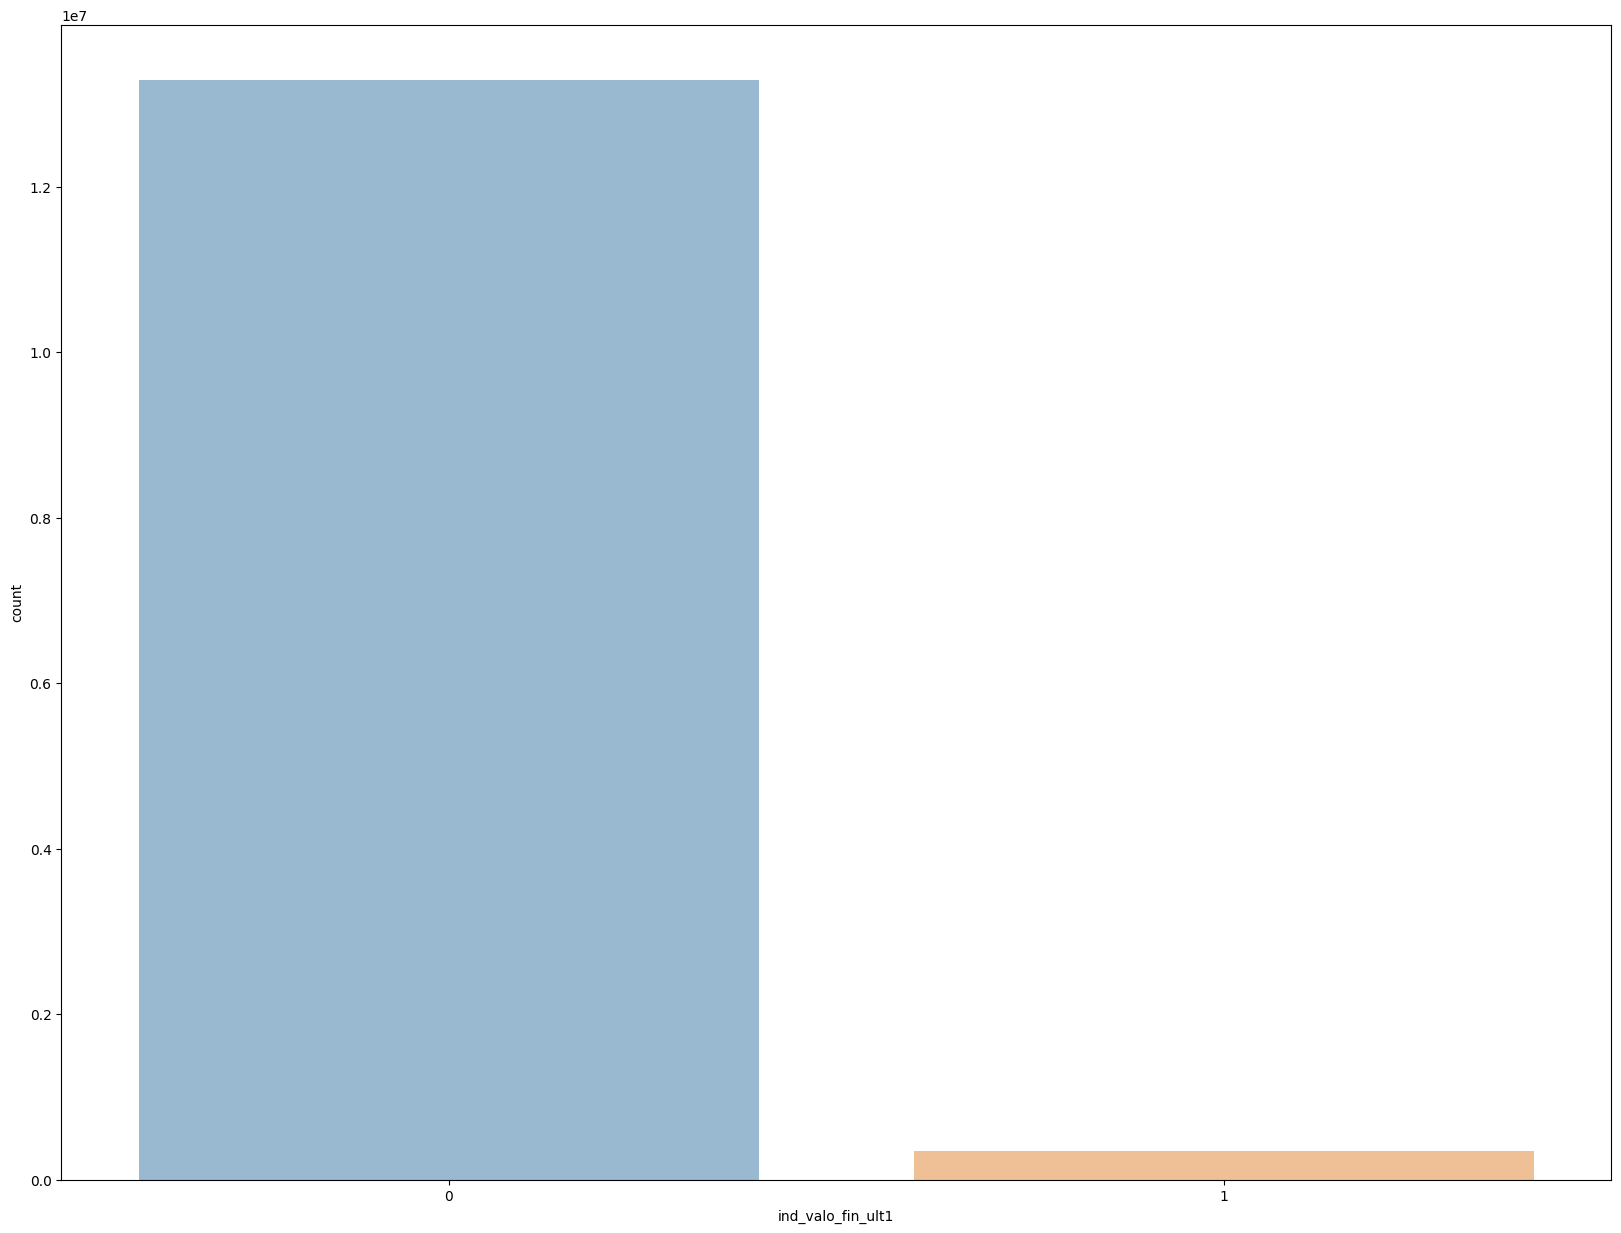

--------------------------------------------------
col :  ind_viv_fin_ult1


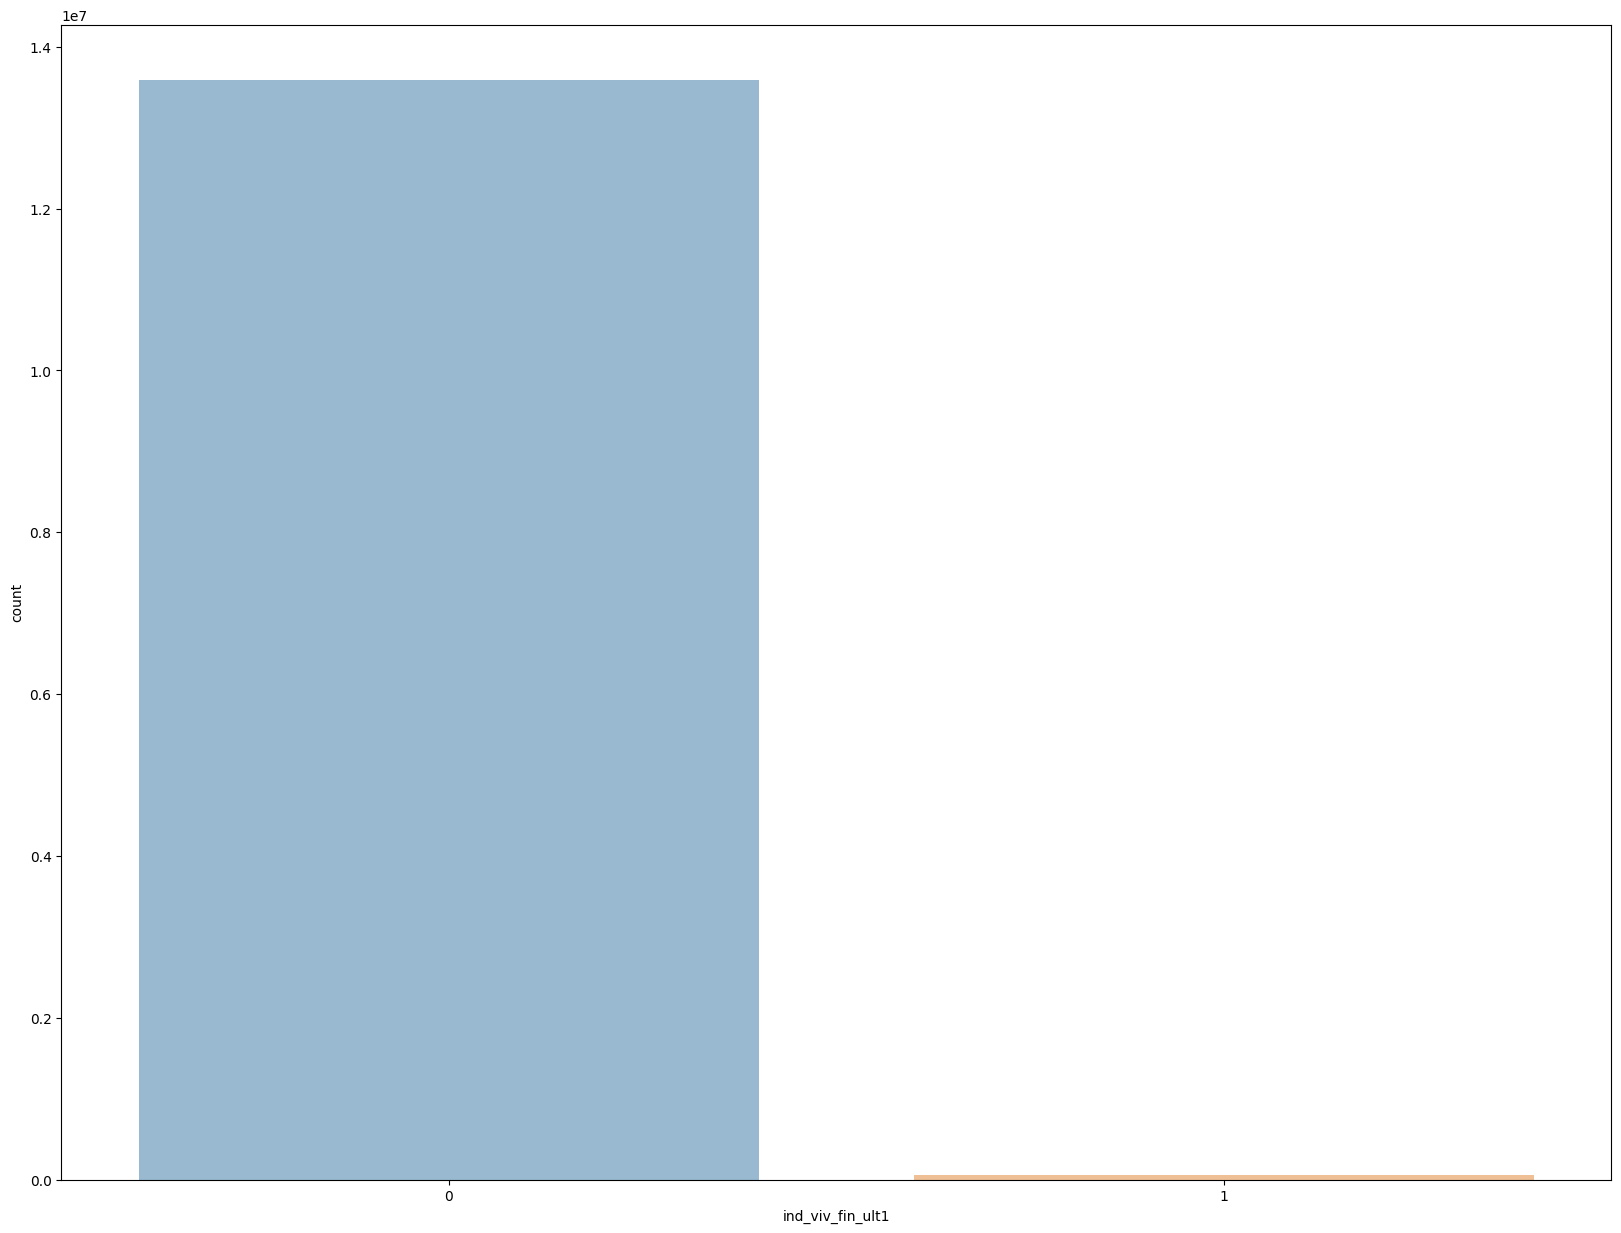

--------------------------------------------------
col :  ind_nomina_ult1


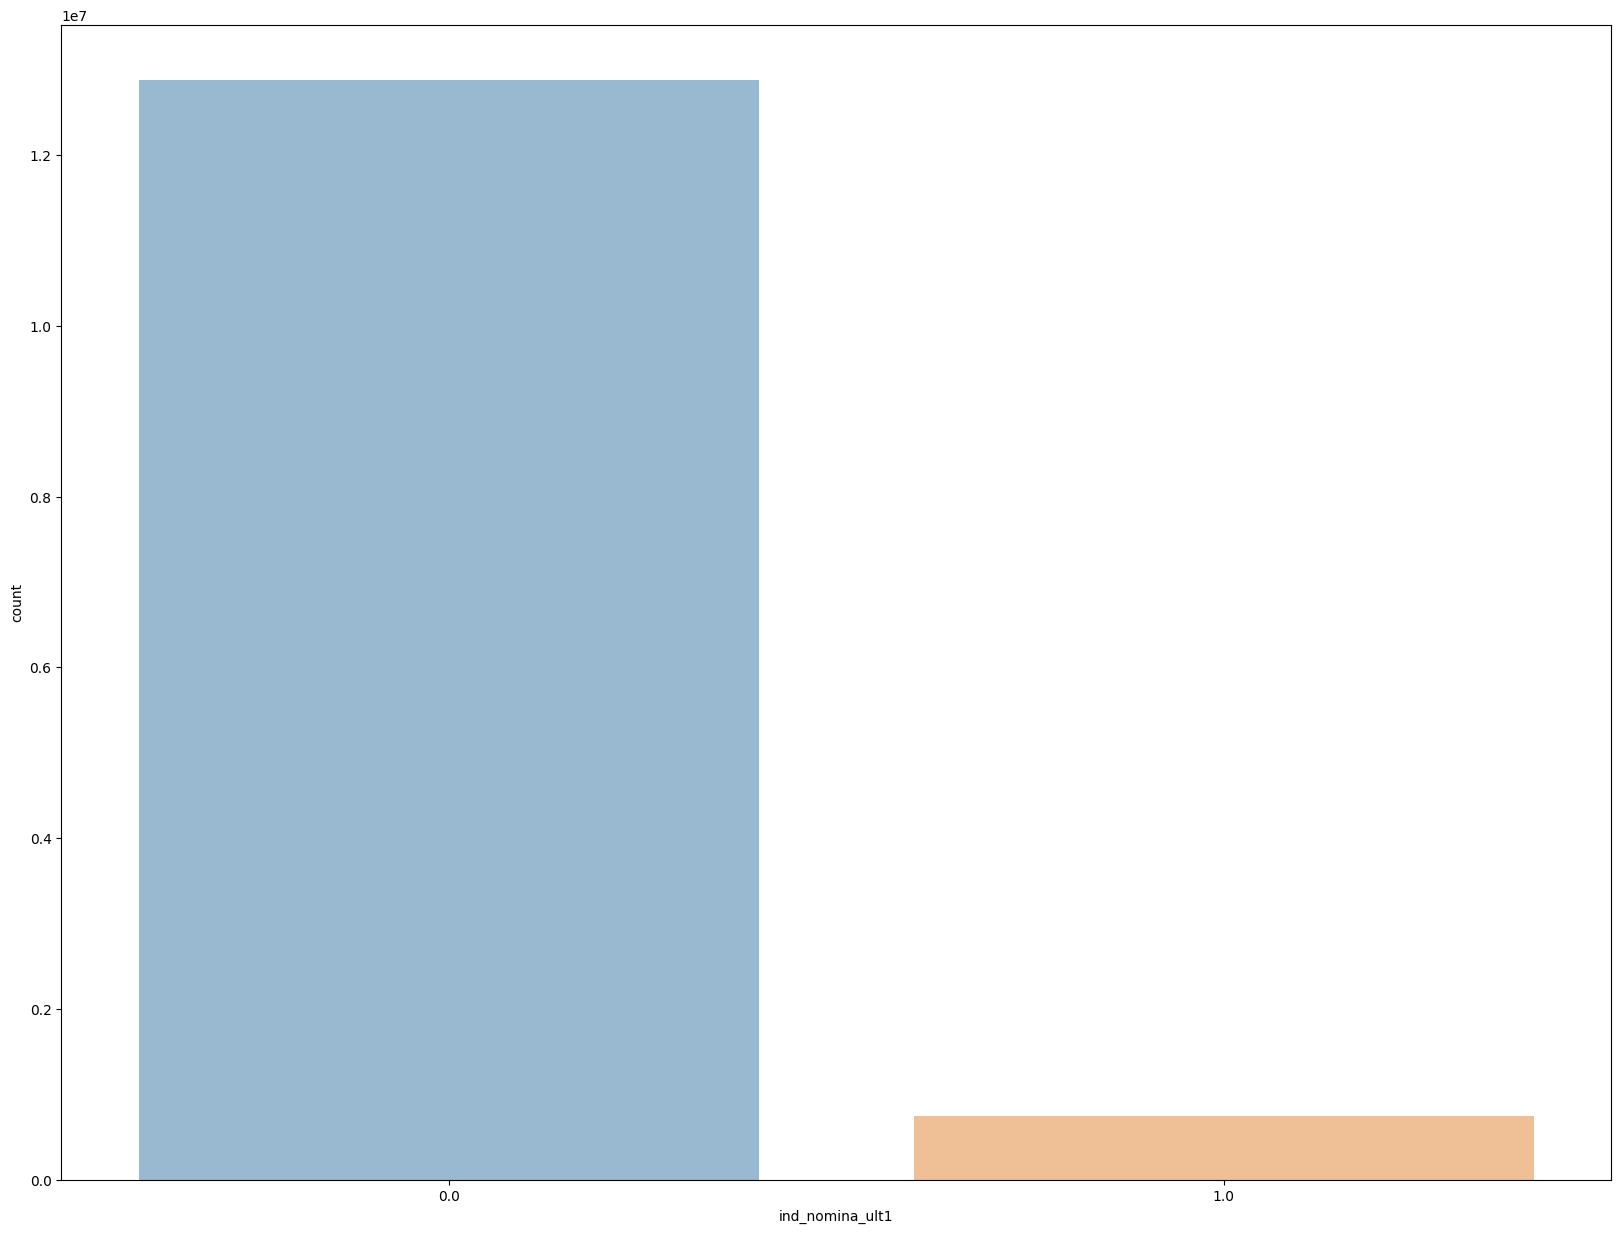

--------------------------------------------------
col :  ind_nom_pens_ult1


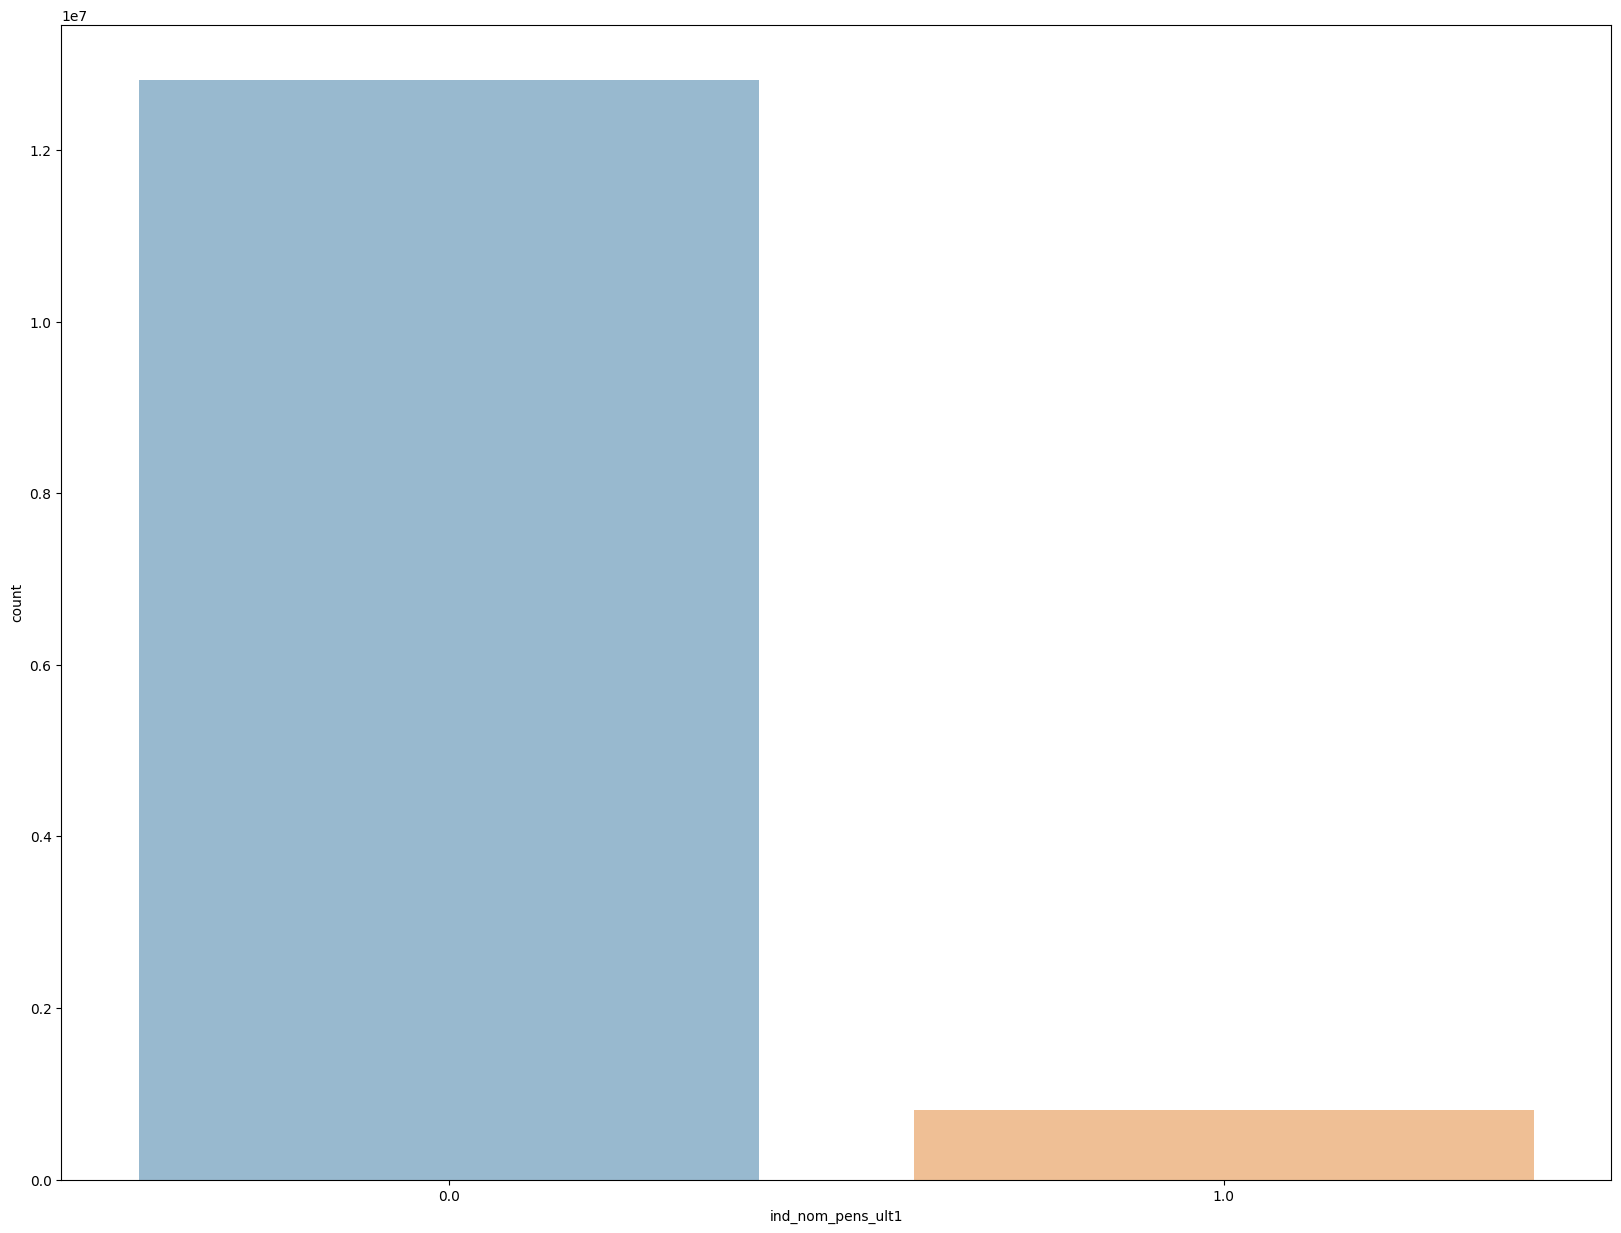

--------------------------------------------------
col :  ind_recibo_ult1


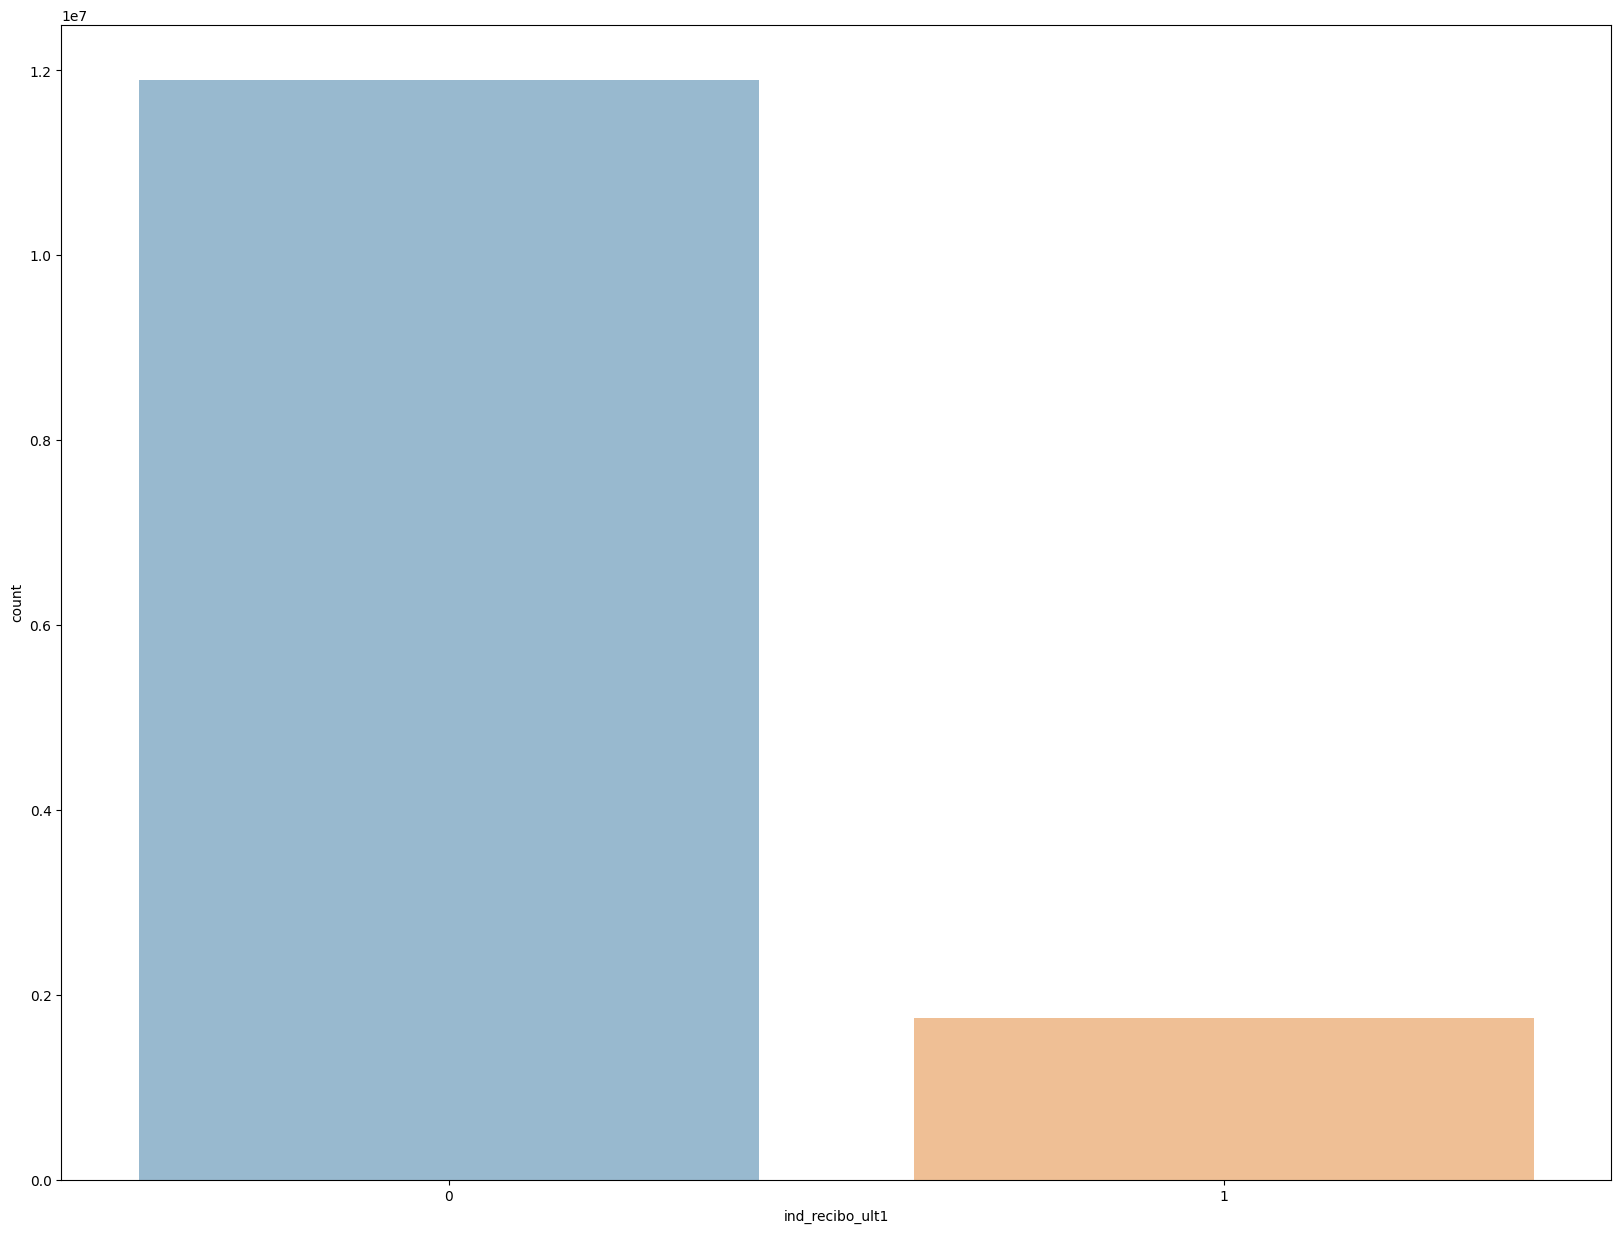

In [13]:
skip_cols = ['ncodpers', 'renta']
for col in trn.columns:
    if col in skip_cols:
        continue

    print('-' * 50)
    print('col : ', col)

    f, ax = plt.subplots(figsize=(20, 15))
    sns.countplot(x=col, data=trn, alpha=0.5)
    plt.show()

# Product Features Table

Product Features are boolean variables that contains 0 and 1 only. 

| Feature | Description | Data Type | Characteristics | Notes |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| ind_ahor_fin_ult1 | Saving Account | int64 | | |
| ind_aval_fin_ult1 | Current Accounts | int64 | | |
| ind_cco_fin_ult1 | Derivada Account | int64 | | |
| ind_cno_fin_ult1 | Payroll Account | int64 | | |
| ind_ctju_fin_ult1 | Junior Account | int64 | | |
| ind_ctma_fin_ult1 | Más particular Account | int64 | | |
| ind_ctop_fin_ult1 | particular Account | int64 | | |
| ind_ctpp_fin_ult1 | particular Plus Account | int64 | | |
| ind_deco_fin_ult1 | Short-term deposits | int64 | | |
| ind_deme_fin_ult1 | Medium-term deposits | int64 | | |
| ind_dela_fin_ult1 | Long-term deposits | int64 | | |
| ind_ecue_fin_ult1 | e-account | int64 | | |
| ind_fond_fin_ult1 | Funds | int64 | | |
| ind_hip_fin_ult1 | Mortgage | int64 | | |
| ind_plan_fin_ult1 | Pensions | int64 | | |
| ind_pres_fin_ult1 | Loans | int64 | | |
| ind_reca_fin_ult1 | Taxes | int64 | | |
| ind_tjcr_fin_ult1 | Credit Card | int64 | | |
| ind_valo_fin_ult1 | Securities | int64 | | |
| ind_viv_fin_ult1 | Home Account | int64 | | |
| ind_nomina_ult1 | Payroll | float64 | | Convert to Integer |
| ind_nom_pens_ult1 | Pensions | float64 | | Convert to Integer |
| ind_recibo_ult1 | Direct Debit | int64 | | |

## Visualize time series data

Previous visualization shows the aggregated date of 1 year and 6 months of data. It does not provide insightful information when the data requires the trends and the flow of data depends on given dates. For example, product features have only 0 and 1 binary data, and it does not provide good ideas to feature engineering or data processing through aggregated density plots. 

Here we provide time series visualization.

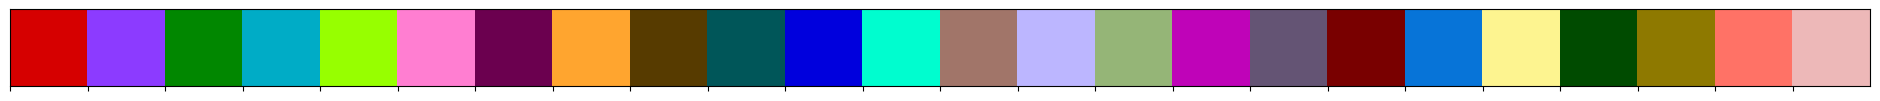

In [14]:
# Create Color list
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=24)
sns.palplot(palette)
color_list = list(palette.as_hex())

Text(0, 0.5, 'Aggregated Sum')

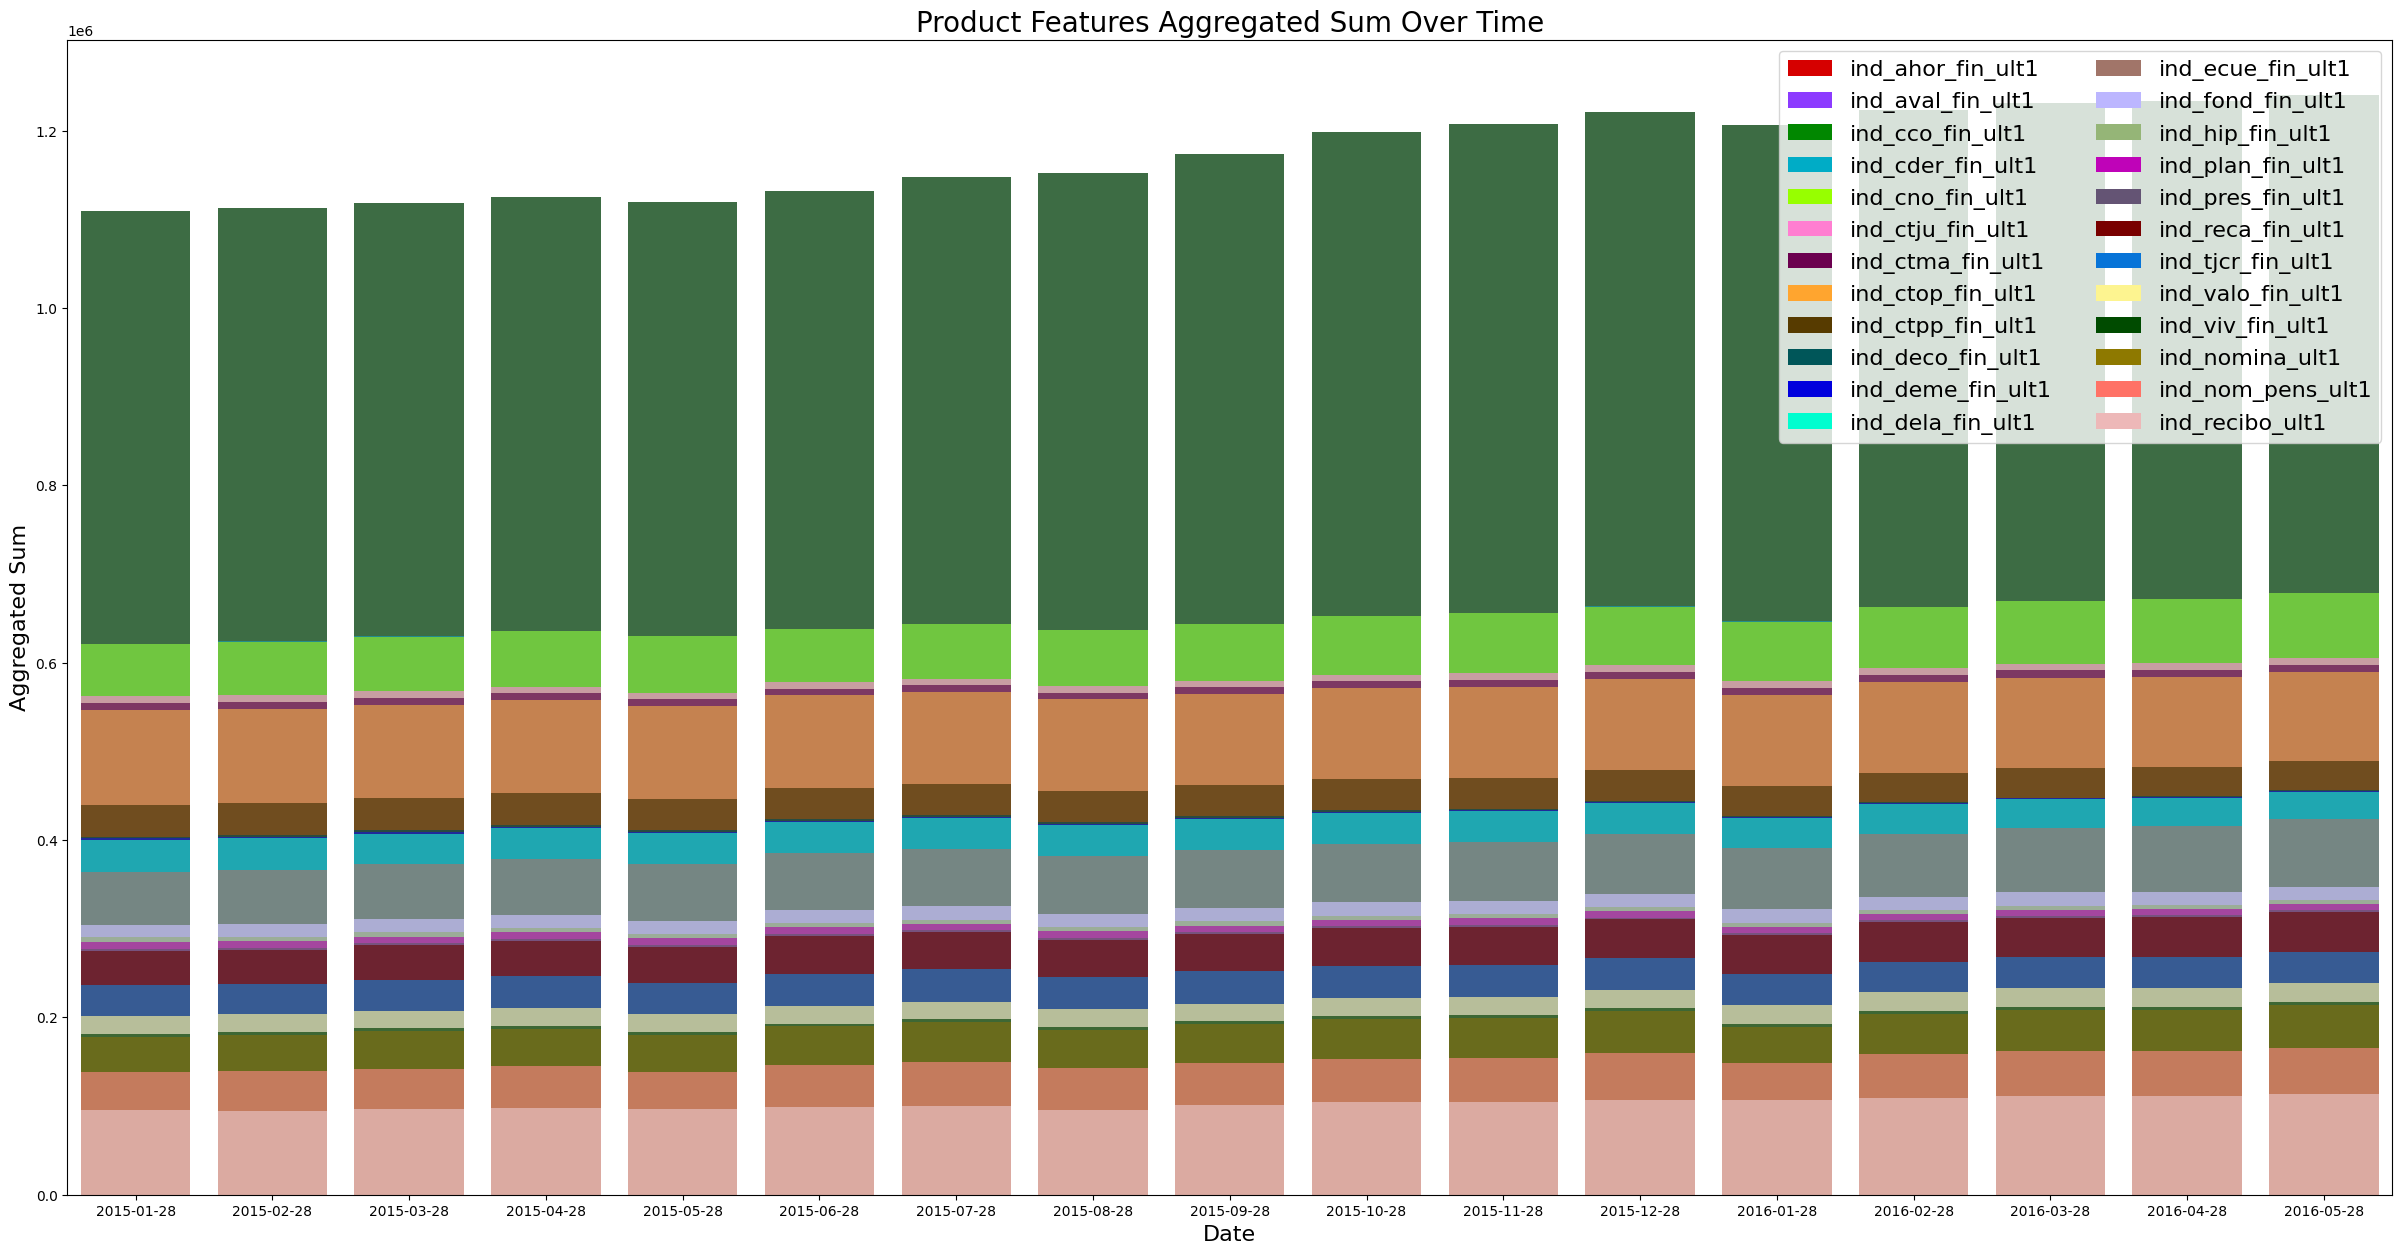

In [15]:
# Extract months from fecha_dato which is date feature
months = trn['fecha_dato'].unique().tolist()

label_cols = trn.columns[24:].tolist()

label_over_time = []

for i in range(len(label_cols)):
    # aggregate sum by using groupby on fecha_dato, date of the 
    label_sum = trn.groupby(['fecha_dato'])[label_cols[i]].agg('sum')
    # for each label, create list of sums of that label over fecha_dato, (over time)
    label_over_time.append(label_sum.tolist())

label_sum_over_time = []
for i in range(len(label_cols)):
    # to show aggregation of sum over time, sum 1~n items starting i to n.
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))

f, ax = plt.subplots(figsize=(30, 15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_over_time[i], color=color_list[i%24], alpha=0.7)

plt.legend([plt.Rectangle((0,0), 1,1,fc=color_list[i%24], edgecolor = 'none') 
            for i in range(len(label_cols))], label_cols, loc=1, ncols = 2, prop={'size': 16})
plt.title("Product Features Aggregated Sum Over Time", fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Aggregated Sum', fontsize=16)

As time passes, we can see the overall number of products increased. It shows the gradually increseament in the customers. We can also see aggregated sum plot by its percentage.

Text(0, 0.5, 'Aggregated Sum %')

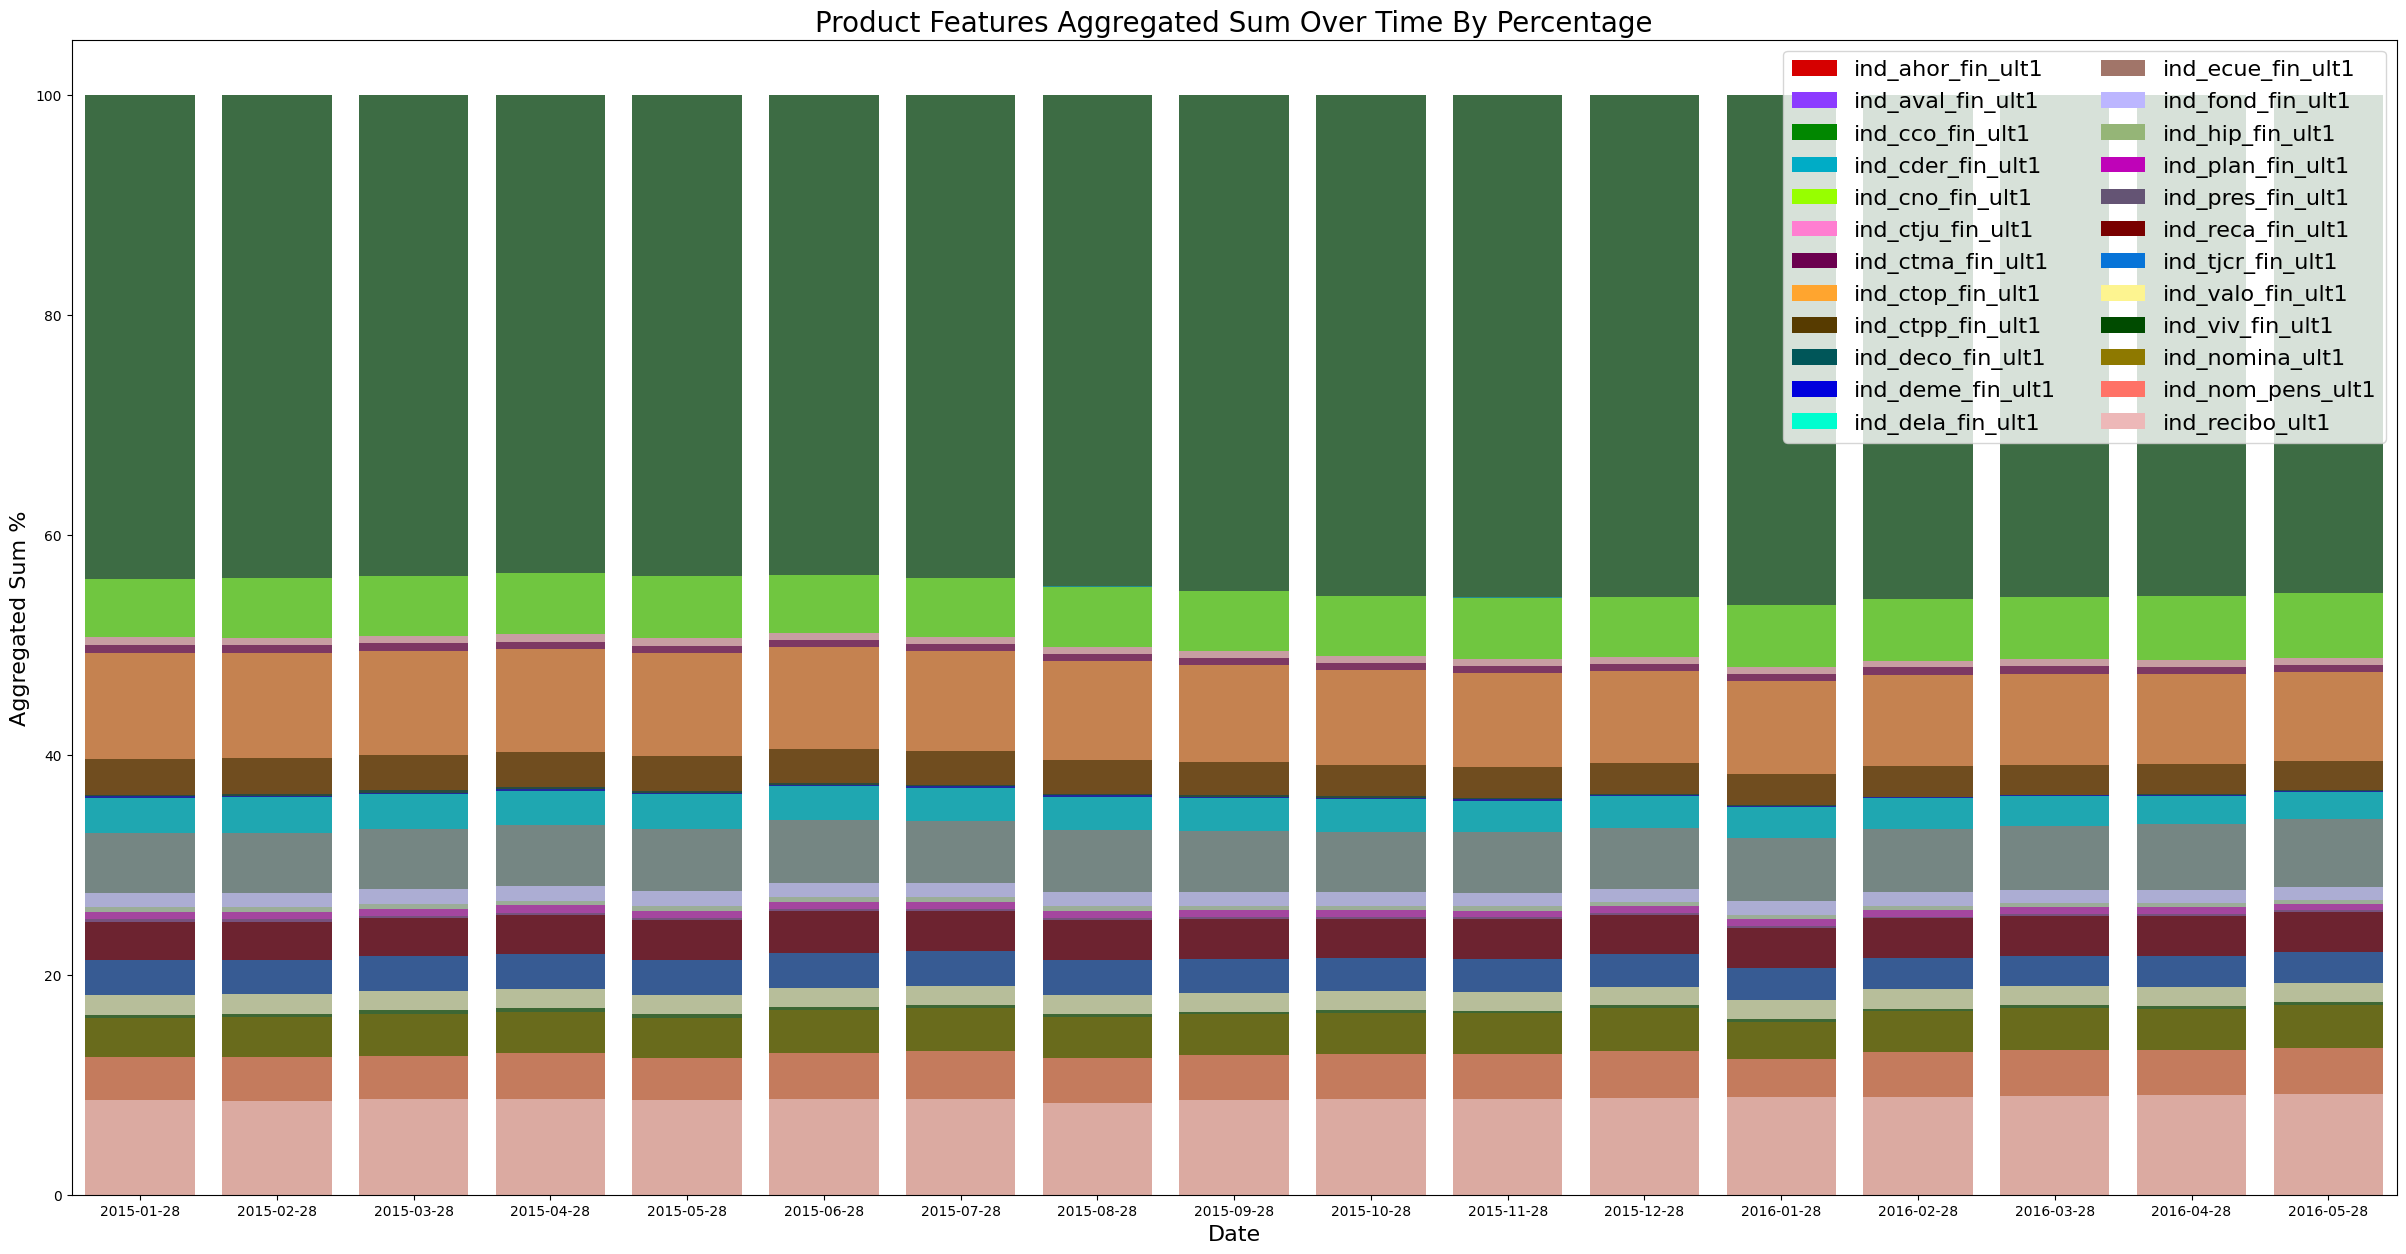

In [16]:
label_sum_percent = (label_sum_over_time / (np.asarray(label_sum_over_time).max(axis=0))) * 100

f, ax = plt.subplots(figsize=(30, 15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_percent[i], color=color_list[i%24], alpha=0.7)

plt.legend([plt.Rectangle((0,0), 1,1,fc=color_list[i%24], edgecolor = 'none') 
            for i in range(len(label_cols))], label_cols, loc=1, ncols = 2, prop={'size': 16})
plt.title("Product Features Aggregated Sum Over Time By Percentage", fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Aggregated Sum %', fontsize=16)

From this plot, we can see that ind_cco_fin_ult1 has the most density through out all months. However its plot does not show significant trends among the months for the product features. It looks like most of the features shows similar percentage through out the months.

3 purpose of EDA:
1. Visualize and find the statistical insight of the data
2. Find the feature transformation idea
3. Find the characteristics

The previous stacked bar graph only shows the total stock of the product, not the monthly trend of the 'new purchase' you want. What we need to visualize and analyze is the new purchase, but given data is monthly owned products. We need to additional analysis to find this new purchase trends.

In [17]:
# Convert date to integer
# There are total 17 months from 2015-01 to 2016-06
# Convert those range into 1 to 17
def date_to_int(str_date):
    Y, M, D = [int(a) for a in str_date.strip().split("-")]
    int_date = (int(Y) - 2015) * 12 + int(M)
    
    return int_date

In [18]:
# Extract Products -> our prediction for new purchases
prods = trn.columns[24:].tolist()

# create new column which is integer form of date
trn['int_date'] = trn['fecha_dato'].map(date_to_int).astype(np.int8)

# Create lag data of int_date with column name appending prev
trn_lag = trn.copy()
trn_lag['int_date'] += 1
trn_lag.columns = [col + '_prev' if col not in ['ncodpers', 'int_date'] else col for col in trn.columns]

In [19]:
trn.head(10)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,int_date
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
5,2015-01-28,1050615,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,45.0,TOLEDO,0.0,22220.04,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
6,2015-01-28,1050616,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,24.0,LEON,0.0,295590.36,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
7,2015-01-28,1050617,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,113316.66,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
8,2015-01-28,1050619,N,ES,H,24,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,20.0,GIPUZKOA,0.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
9,2015-01-28,1050620,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,10.0,CACERES,0.0,113194.98,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1


In [20]:
trn_lag.head(10)

,fecha_dato_prev,ncodpers,ind_empleado_prev,pais_residencia_prev,sexo_prev,age_prev,fecha_alta_prev,ind_nuevo_prev,antiguedad_prev,indrel_prev,ult_fec_cli_1t_prev,indrel_1mes_prev,tiprel_1mes_prev,indresi_prev,indext_prev,conyuemp_prev,canal_entrada_prev,indfall_prev,tipodom_prev,cod_prov_prev,nomprov_prev,ind_actividad_cliente_prev,renta_prev,segmento_prev,ind_ahor_fin_ult1_prev,ind_aval_fin_ult1_prev,ind_cco_fin_ult1_prev,ind_cder_fin_ult1_prev,ind_cno_fin_ult1_prev,ind_ctju_fin_ult1_prev,ind_ctma_fin_ult1_prev,ind_ctop_fin_ult1_prev,ind_ctpp_fin_ult1_prev,ind_deco_fin_ult1_prev,ind_deme_fin_ult1_prev,ind_dela_fin_ult1_prev,ind_ecue_fin_ult1_prev,ind_fond_fin_ult1_prev,ind_hip_fin_ult1_prev,ind_plan_fin_ult1_prev,ind_pres_fin_ult1_prev,ind_reca_fin_ult1_prev,ind_tjcr_fin_ult1_prev,ind_valo_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nomina_ult1_prev,ind_nom_pens_ult1_prev,ind_recibo_ult1_prev,int_date
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
5,2015-01-28,1050615,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,45.0,TOLEDO,0.0,22220.04,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
6,2015-01-28,1050616,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,24.0,LEON,0.0,295590.36,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
7,2015-01-28,1050617,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,113316.66,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
8,2015-01-28,1050619,N,ES,H,24,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,20.0,GIPUZKOA,0.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2
9,2015-01-28,1050620,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,10.0,CACERES,0.0,113194.98,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2


In [21]:
# by merging lag data with original data, we get previous month data.
df_trn = trn.merge(trn_lag, on=['ncodpers','int_date'], how='left')

del trn, trn_lag

In [22]:
df_trn.head(10)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,int_date,fecha_dato_prev,ind_empleado_prev,pais_residencia_prev,sexo_prev,age_prev,fecha_alta_prev,ind_nuevo_prev,antiguedad_prev,indrel_prev,ult_fec_cli_1t_prev,indrel_1mes_prev,tiprel_1mes_prev,indresi_prev,indext_prev,conyuemp_prev,canal_entrada_prev,indfall_prev,tipodom_prev,cod_prov_prev,nomprov_prev,ind_actividad_cliente_prev,renta_prev,segmento_prev,ind_ahor_fin_ult1_prev,ind_aval_fin_ult1_prev,ind_cco_fin_ult1_prev,ind_cder_fin_ult1_prev,ind_cno_fin_ult1_prev,ind_ctju_fin_ult1_prev,ind_ctma_fin_ult1_prev,ind_ctop_fin_ult1_prev,ind_ctpp_fin_ult1_prev,ind_deco_fin_ult1_prev,ind_deme_fin_ult1_prev,ind_dela_fin_ult1_prev,ind_ecue_fin_ult1_prev,ind_fond_fin_ult1_prev,ind_hip_fin_ult1_prev,ind_plan_fin_ult1_prev,ind_pres_fin_ult1_prev,ind_reca_fin_ult1_prev,ind_tjcr_fin_ult1_prev,ind_valo_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nomina_ult1_prev,ind_nom_pens_ult1_prev,ind_recibo_ult1_prev
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-01-28,1050615,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,45.0,TOLEDO,0.0,22220.04,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-01-28,1050616,N,ES,H,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,24.0,LEON,0.0,295590.36,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [23]:
# for the previous month products that have null data, replace with 0
for prod in prods:
    prev = prod + '_prev'
    df_trn[prev].fillna(0, inplace=True)

# Create new purchase by comparing previous and current purchase
for prod in prods:
    padd = prod + '_add'
    prev = prod + '_prev'
    # for product that is purchased this month, but not in previous month, we indicate it with prod_add
    df_trn[padd] = ((df_trn[prod] == 1) & (df_trn[prev] == 0)).astype(np.int8)

In [24]:
df_trn.head(10)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,int_date,fecha_dato_prev,ind_empleado_prev,pais_residencia_prev,sexo_prev,age_prev,fecha_alta_prev,ind_nuevo_prev,antiguedad_prev,indrel_prev,ult_fec_cli_1t_prev,indrel_1mes_prev,tiprel_1mes_prev,indresi_prev,indext_prev,conyuemp_prev,canal_entrada_prev,indfall_prev,tipodom_prev,cod_prov_prev,nomprov_prev,ind_actividad_cliente_prev,renta_prev,segmento_prev,ind_ahor_fin_ult1_prev,ind_aval_fin_ult1_prev,ind_cco_fin_ult1_prev,ind_cder_fin_ult1_prev,ind_cno_fin_ult1_prev,ind_ctju_fin_ult1_prev,ind_ctma_fin_ult1_prev,ind_ctop_fin_ult1_prev,ind_ctpp_fin_ult1_prev,ind_deco_fin_ult1_prev,ind_deme_fin_ult1_prev,ind_dela_fin_ult1_prev,ind_ecue_fin_ult1_prev,ind_fond_fin_ult1_prev,ind_hip_fin_ult1_prev,ind_plan_fin_ult1_prev,ind_pres_fin_ult1_prev,ind_reca_fin_ult1_prev,ind_tjcr_fin_ult1_prev,ind_valo_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nomina_ult1_prev,ind_nom_pens_ult1_prev,ind_recibo_ult1_prev,ind_ahor_fin_ult1_add,ind_aval_fin_ult1_add,ind_cco_fin_ult1_add,ind_cder_fin_ult1_add,ind_cno_fin_ult1_add,ind_ctju_fin_ult1_add,ind_ctma_fin_ult1_add,ind_ctop_fin_ult1_add,ind_ctpp_fin_ult1_add,ind_deco_fin_ult1_add,ind_deme_fin_ult1_add,ind_dela_fin_ult1_add,ind_ecue_fin_ult1_add,ind_fond_fin_ult1_add,ind_hip_fin_ult1_add,ind_plan_fin_ult1_add,ind_pres_fin_ult1_add,ind_reca_fin_ult1_add,ind_tjcr_fin_ult1_add,ind_valo_fin_ult1_add,ind_viv_fin_ult1_add,ind_nomina_ult1_add,ind_nom_pens_ult1_add,ind_recibo_ult1_add
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [25]:
# Extract Excel for those new purchased products. Calling them labels.csv
add_cols = [prod + '_add' for prod in prods]
labels = df_trn[add_cols].copy()
labels.columns = prods
labels.to_csv('./data/labels.csv', index=False)

Visualize new purchase using labels.csv

Text(0, 0.5, 'Aggregated Sum')

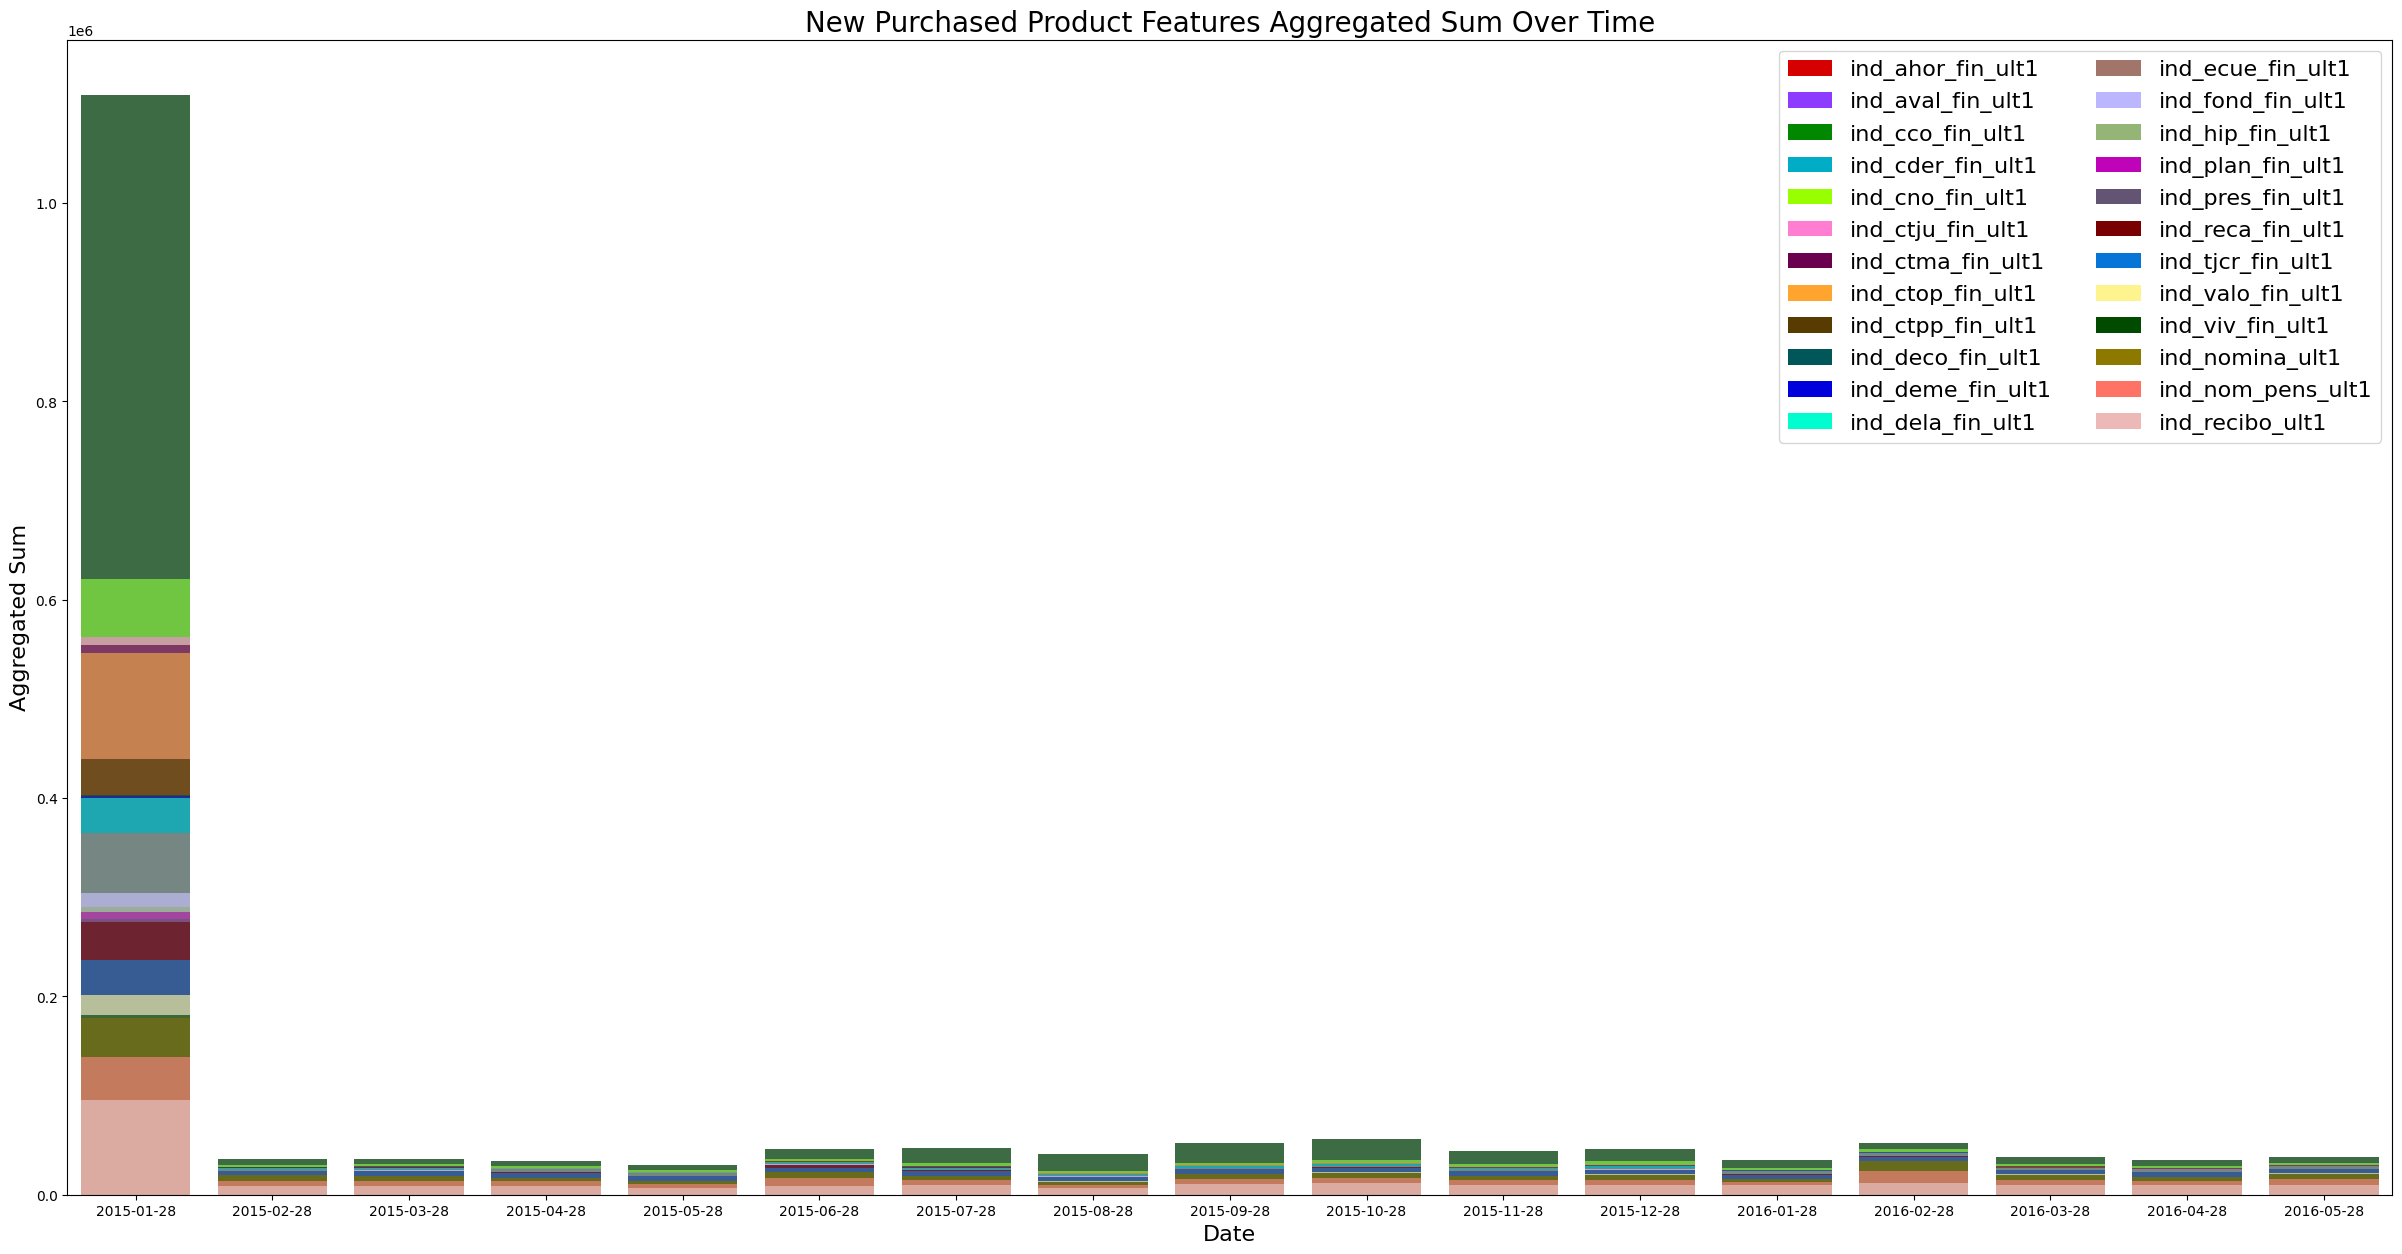

In [27]:
fecha_dato = df_trn['fecha_dato']

labels['date'] = fecha_dato
months = np.unique(fecha_dato).tolist()
label_cols = labels.columns.tolist()[:24]

label_over_time = []
for i in range(len(label_cols)):
    label_over_time.append(labels.groupby(['date'])[label_cols[i]].agg('sum').tolist())
    
label_sum_over_time = []
for i in range(len(label_cols)):
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))

f, ax = plt.subplots(figsize=(30, 15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_over_time[i], color = color_list[i%24], alpha=0.7)
    
plt.legend([plt.Rectangle((0,0),1,1,fc=color_list[i%24], edgecolor = 'none') 
            for i in range(len(label_cols))], label_cols, loc=1, ncol = 2, prop={'size':16})
plt.title("New Purchased Product Features Aggregated Sum Over Time", fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Aggregated Sum', fontsize=16)

In [28]:
labels.groupby(['date']).sum()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
date,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-28,88,19,487855,301,58763,7757,8418,106471,36195,1513,1620,36010,60381,13865,5007,7430,2349,38288,35613,20263,3234,38995,43331,95601
2015-02-28,1,1,5831,12,1964,54,409,261,174,808,33,786,1492,456,5,31,10,221,3545,270,8,5723,5729,8394
2015-03-28,0,1,5694,18,1852,74,408,292,167,763,23,906,1619,578,8,26,16,220,5176,212,4,4570,4566,9273
2015-04-28,0,1,5335,12,2068,69,324,282,173,485,26,880,1486,501,4,24,22,877,4724,198,5,2742,5712,8471
2015-05-28,0,0,5355,7,1987,84,308,298,174,435,25,1005,1480,438,11,24,13,343,4191,213,4,3430,3409,7183
2015-06-28,0,0,9457,9,1934,55,349,222,154,503,33,1085,1219,246,4,21,8,2942,4755,159,3,5161,8229,9131
2015-07-28,0,0,15585,11,2888,79,356,265,165,526,24,1282,1106,207,6,28,5,598,5021,240,9,4569,5026,9320
2015-08-28,0,0,16559,11,2448,65,347,231,145,508,33,1073,930,224,1,22,13,266,4383,447,2,2987,3005,7186
2015-09-28,0,0,20255,7,1811,52,582,191,122,581,30,1411,1081,133,8,23,13,272,4466,331,2,4727,4799,11303


it shows mostly on 2015-01-28 for the new purchased products becaused it is first month of the data and it is considered as first purchased. In order to see the other months' new purchase counts, it is good to see the relative values.

Text(0, 0.5, 'Aggregated Sum %')

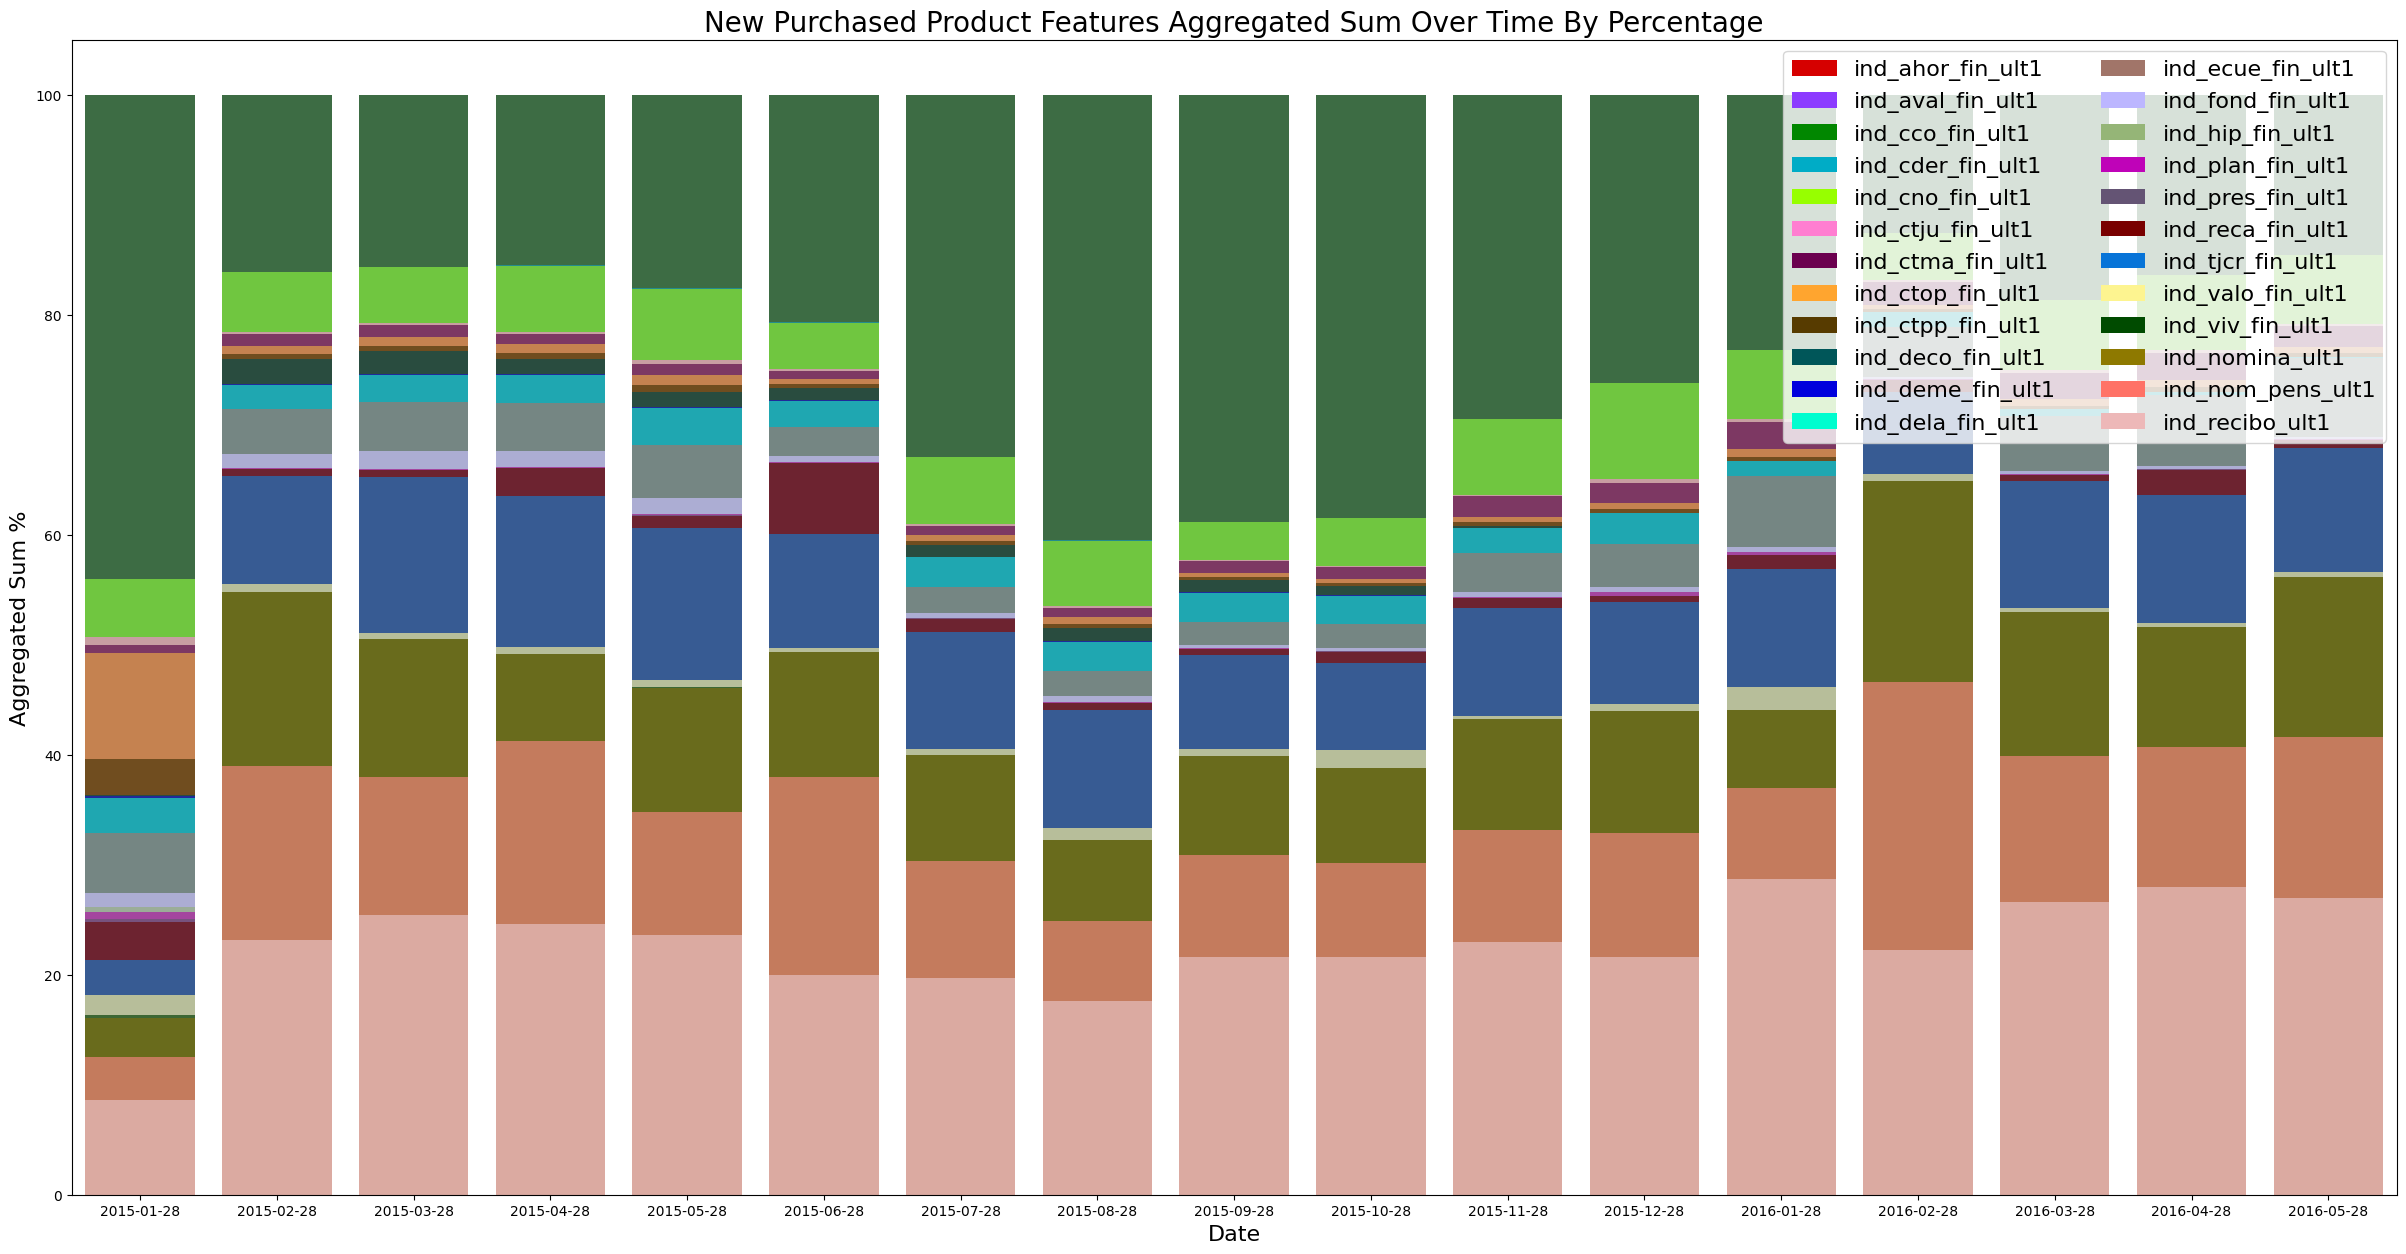

In [29]:
label_sum_percent = (label_sum_over_time / (np.asarray(label_sum_over_time)).max(axis=0)) * 100

f, ax = plt.subplots(figsize=(30, 15))

for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_percent[i], color=color_list[i%24], alpha=0.7)

plt.legend([plt.Rectangle((0,0),1,1,fc=color_list[i%24], edgecolor = 'none') 
            for i in range(len(label_cols))], label_cols, loc=1, ncol = 2, prop={'size':16})
plt.title("New Purchased Product Features Aggregated Sum Over Time By Percentage", fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Aggregated Sum %', fontsize=16)

Few interesting notice on the plot:
- ind_cco_fin_ult1 has highest density on 2015-08 and generally high density around 7-10 of 2015. Then it starts to reduce around winter time such as 2015-02 and 2016-02-05
- ind_reca_fin_ult1 has highest density on 2015-06 while mostly has low density in other months
- ind_nomina_ult1 and ind_nom_pens_ult1 show low density around summer time, month of 7-9. And it show relatively high density around winter time, month of 02.
- ind_cco_fin_ult1, ind_tjcr_fin_ult1, ind_nomina_ult1, ind_nom_pens_ult1, ind_recibo_fin_ult1 are the top 5 mostly purchased products over the time.
- There are few products that are not purchased most of the time such as ind_ahor_fin_ult1, ind_aval_fin_ult1

In [31]:
# if the product is all 0, that means all customers did not purchase. We can remove those products
no_product = (df_trn[prods].sum(axis=1) == 0)

0           False
1           False
2           False
3           False
4           False
            ...  
13647304    False
13647305    False
13647306    False
13647307    False
13647308    False
Length: 13647309, dtype: bool

In [33]:
no_product

False

# Summary of EDA

- feature like 'age', 'antiguedad', 'indrel_1mes' should be numeric but it is type of object. It is required to data transformation
- There are some missing variables. Features like product may be replaced with 0 for indication of no purchases. For customer features and date, we need to come up with methods to handles missing values
- For those binary variables, convert them to int64 for memory optimization
- Some customer features like indrel_1mes, representing customer types, does not provide enough information. It is not clear what former primary means.
- The goal of this model is to predict the new product to purchase not an existing products. Thus it is required to extract new purchases separately like how we extract labels.csv
- New purchase data shows seasonality trends. It is necessary to choose whether to train all data with a single model or to train by extracting only a specific month. Another way is to train multiple models based on different seasons.